# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    # replace all whitespace with ' '
    data.replace('\t',' ')
    data.replace('\n',' ')

    # to lower all alphabetical characters
    data.lower()

    voc2ind = {}
    intdata = np.zeros(len(data))
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    charindex = 0
    dataindex = 0
    for char in data:
        if (char not in voc2ind.keys()):
          voc2ind[char] = charindex
          charindex += 1
        intdata[dataindex] = voc2ind[char]
        dataindex += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    trainsize = math.ceil(len(data) * 0.8)

    train_text = intdata[0:trainsize]
    test_text = intdata[trainsize:len(intdata)]

    # print(len(data))
    # print(trainsize)
    # print(len(train_text))
    # print(len(test_text))
    print("voc2ind length = " + str(len(voc2ind)))
    print("ind2cov length = " + str(len(ind2voc)))

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

voc2ind length = 91
ind2cov length = 91


#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        print(len(self.vocab))

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        dataset = dataset['tokens']
        new_len = math.floor(len(dataset) / batch_size) * batch_size
        dataset = dataset[0:new_len]
        num_batches = math.ceil(len(dataset) / (sequence_length * batch_size))
        self.batch_size = batch_size # save for idx conversion
        self.dataset = dataset

        sequences = []
        indices = [*range(len(dataset))]
        last_seq_len = 0
        for i in range(batch_size):
          start_idx = int(i * (len(dataset)/batch_size))
          for j in range(num_batches):
            seq = []
            if (start_idx + sequence_length >= len(dataset)):
              seq = indices[start_idx:len(dataset) - 1]
              last_seq_len = len(seq)
            else:
              seq = indices[start_idx:(start_idx + sequence_length)]
            start_idx += sequence_length
            sequences.append(seq)

        for i in range(len(sequences)):
          if ((i+1) % num_batches == 0):
            seq = sequences[i]
            sequences[i] = seq[0:last_seq_len]

        for seq in sequences:
          if (len(seq) == 0):
            sequences.remove(seq);

        self.sequences = sequences
        self.indices = indices
          

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return len(self.sequences)
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        num = len(self.sequences) / self.batch_size
        reordered_idx = int(((idx * num) / len(self.sequences)) + ((idx * num) % len(self.sequences)))

        seq = self.sequences[reordered_idx]
        data = [self.dataset[x] for x in seq]
        label = [self.dataset[x+1] for x in seq]
        return torch.Tensor(data).long(), torch.Tensor(label).long()

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        print(type(self.vocab_size))
        print(type(self.feature_size))
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
TEMPERATURE = 1.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []

    # get first character
    output = output.view(1, -1)
    output = output / max(TEMPERATURE, 1e-20)
    output = F.softmax(output, dim=1)

    # use max
    index = torch.argmax(output)
    c = vocab.array_to_words([index])
    outputs.append(index)

    for ii in range(sequence_length):
        # TODO
        # generate next character
        output, hidden = model.inference(vocab.words_to_array(c).to(device), hidden.to(device))
        index = torch.argmax(output)
        c = vocab.array_to_words([index])
        outputs.append(index)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []

    # get first character
    output = output.view(1, -1)
    output = output / max(TEMPERATURE, 1e-20)
    output = F.softmax(output, dim=1)

    # use max
    index = torch.multinomial(input = output.to(device), num_samples = 1)
    outputs.append(index)

    for ii in range(sequence_length):
        # TODO
        output, hidden = model.inference(index.to(device), hidden.to(device))
        index = torch.multinomial(input = output.to(device), num_samples = 1)
        outputs.append(index)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    beams = [([], output, hidden, 0)]

    # TODO
    for i in range(sequence_length):
      new_beams = []
      for beam in beams:
        index = torch.multinomial(input = beam[1].to(device), num_samples = 1)
        dist, hidden = model.inference(index.to(device), beam[2].to(device))

        indices = torch.multinomial(input = dist, num_samples = beam_width, replacement=True)
        for i in indices[0]:
          words = beam[0].copy()
          words.append(i)
          dist2 = dist[0]
          likelihood = math.log(dist2[i])
          new_beams.append((words, dist, hidden, beam[3] + likelihood))
      
      new_beams.sort(key = lambda t: t[3])
      size = len(new_beams)
      beams = new_beams[size - beam_width: size]

    outputs = beams[len(beams) - 1][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            # print("data: " + str(data))
            # print("label: " + str(label))
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0003
    USE_CUDA = True
    PRINT_INTERVAL = 10
    VERSION = '2.7'
    LOG_PATH = DATA_PATH + VERSION + '/logs/log.pk' + VERSION


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints/' + VERSION)

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            test_perplexities.append((epoch, math.exp(test_loss)))
            print("perplexity: " + str(test_perplexities))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/' + VERSION + '/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/' + VERSION + '/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')

        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        ep, val = zip(*test_perplexities)
        print(ep)
        print(val)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')

        return model, vocab, device

final_model, vocab, device = main()

91
91
Using device cuda
num workers: 2
<class 'int'>
<class 'int'>
Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	wU**RW**$wb_F$oj/$sWwjzj0wFF5C*j*k$$^ok$$qH$$D

;wwwYbsCb""z"ewjoo'`o$obqC*C-bb=wj$$qwwwwo^


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	CqHYqH/$qbCCbjyO'b0Yjj$jWC,z$qbqzubF-
OUo$o$FSZZj$$b$$qwwwWwj$sbq**$C


CqEjqwjCCjjyt$XO$Yk$q


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	qzEWwwYqbCCbww/s$jV_Yqwwojk5V{Y$CCqw**obb_^&$qbq$$wwYtwoL`*$**jj77qbqzuCCk

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 17.6347, Accuracy: 12418/1254400 (1%)



  2%|▏         | 3/196 [00:00<00:39,  4.94it/s]

Train Epoch: 0 [0/50176 (0%)]	Loss: 17.654907


  7%|▋         | 13/196 [00:01<00:18,  9.84it/s]

Train Epoch: 0 [2560/50176 (5%)]	Loss: 7.185877


 12%|█▏        | 23/196 [00:02<00:14, 11.84it/s]

Train Epoch: 0 [5120/50176 (10%)]	Loss: 4.169936


 17%|█▋        | 33/196 [00:02<00:13, 12.29it/s]

Train Epoch: 0 [7680/50176 (15%)]	Loss: 3.002902


 22%|██▏       | 43/196 [00:03<00:12, 12.36it/s]

Train Epoch: 0 [10240/50176 (20%)]	Loss: 2.449069


 27%|██▋       | 53/196 [00:04<00:11, 12.26it/s]

Train Epoch: 0 [12800/50176 (26%)]	Loss: 2.248846


 32%|███▏      | 63/196 [00:05<00:10, 12.31it/s]

Train Epoch: 0 [15360/50176 (31%)]	Loss: 2.404170


 37%|███▋      | 73/196 [00:06<00:10, 12.29it/s]

Train Epoch: 0 [17920/50176 (36%)]	Loss: 2.472462


 42%|████▏     | 83/196 [00:06<00:09, 12.39it/s]

Train Epoch: 0 [20480/50176 (41%)]	Loss: 2.591333


 47%|████▋     | 93/196 [00:07<00:08, 12.27it/s]

Train Epoch: 0 [23040/50176 (46%)]	Loss: 2.158668


 53%|█████▎    | 103/196 [00:08<00:07, 12.36it/s]

Train Epoch: 0 [25600/50176 (51%)]	Loss: 2.021495


 55%|█████▍    | 107/196 [00:09<00:07, 11.82it/s]

Interrupted
Saving final model
Saved /content/checkpoints/2.7/000.pt



ValueError: ignored

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Master has given Dobby a '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Master has given Dobby a lot of the way of the way of the walls of the walls of the walls of the walls of the walls of the walls of the corner of the walls of the walls of the corner of the walls of the walls of the corner of 
generated with sample	 Master has given Dobby a !" He shout Harry
way.

"What was a fourtence who was one for long my of-fiate him -"
"Tret's on the goast, humming, Potter how it would hear sorry of whenezunts happen in the whole
Volfor-L-Cxu_n- the
generated with sample	 Master has given Dobby a Antive Potions looking us alive decontroter," he said. "I isn't - do what told you things ?"

"Mr.. We org!" he slambed in voice...Y he noticed the plafet with him. He huddering a from why he was sitti
generated with sample	 Master has given Dobby a abTe of his own bed.
Daight make out - going out of the form."
The sock of way of his face's head where shine indingular and burning at the classling down the flat on his toward sounded after able clay
gen

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



## Part 8.1: Train on a different text corpus
We chose to train on the complete works of Mark Twain downloaded as plain text from Project Gutenberg.


In [ ]:
# Run part 0 first

# Get dataset ----------------------------------------------------------------------------------
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'pg3200.txt')):
    os.chdir(BASE_PATH)
    !wget http://www.gutenberg.org/cache/epub/3200/pg3200.txt
    !cp pt_util.py /content
    !cp pg3200.txt /content
os.chdir('/content')

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

# Preprocess data ----------------------------------------------------------------------------------
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    # replace all whitespace with ' '
    data.replace('\t',' ')
    data.replace('\n',' ')

    # to lower all alphabetical characters
    data.lower()

    voc2ind = {}
    intdata = np.zeros(len(data))
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    charindex = 0
    dataindex = 0
    for char in data:
        if (char not in voc2ind.keys()):
          voc2ind[char] = charindex
          charindex += 1
        intdata[dataindex] = voc2ind[char]
        dataindex += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    trainsize = math.ceil(len(data) * 0.8)

    train_text = intdata[0:trainsize]
    test_text = intdata[trainsize:len(intdata)]

    # print(len(data))
    # print(trainsize)
    # print(len(train_text))
    # print(len(test_text))
    print("voc2ind length = " + str(len(voc2ind)))
    print("ind2cov length = " + str(len(ind2voc)))

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'twain_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'twain_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'pg3200.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

# Load Data ----------------------------------------------------------------------------------
class TwainDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(TwainDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        print(len(self.vocab))

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        dataset = dataset['tokens']
        new_len = math.floor(len(dataset) / batch_size) * batch_size
        dataset = dataset[0:new_len]
        num_batches = math.ceil(len(dataset) / (sequence_length * batch_size))
        self.batch_size = batch_size # save for idx conversion
        self.dataset = dataset

        sequences = []
        indices = [*range(len(dataset))]
        last_seq_len = 0
        for i in range(batch_size):
          start_idx = int(i * (len(dataset)/batch_size))
          for j in range(num_batches):
            seq = []
            if (start_idx + sequence_length >= len(dataset)):
              seq = indices[start_idx:len(dataset) - 1]
              last_seq_len = len(seq)
            else:
              seq = indices[start_idx:(start_idx + sequence_length)]
            start_idx += sequence_length
            sequences.append(seq)

        for i in range(len(sequences)):
          if ((i+1) % num_batches == 0):
            seq = sequences[i]
            sequences[i] = seq[0:last_seq_len]

        for seq in sequences:
          if (len(seq) == 0):
            sequences.remove(seq);

        self.sequences = sequences
        self.indices = indices
          

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return len(self.sequences)
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        num = len(self.sequences) / self.batch_size
        reordered_idx = int(((idx * num) / len(self.sequences)) + ((idx * num) % len(self.sequences)))

        seq = self.sequences[reordered_idx]
        data = [self.dataset[x] for x in seq]
        label = [self.dataset[x+1] for x in seq]
        return torch.Tensor(data).long(), torch.Tensor(label).long()

    def vocab_size(self):
        return len(self.vocab)

# Defining Network ------------------------------------------------------------
TEMPERATURE = 0.5

class TwainNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(TwainNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        print(type(self.vocab_size))
        print(type(self.feature_size))
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)\

# Character Generation --------------------------------------------------------
TEMPERATURE = 1.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []

    # get first character
    output = output.view(1, -1)
    output = output / max(TEMPERATURE, 1e-20)
    output = F.softmax(output, dim=1)

    # use max
    index = torch.argmax(output)
    c = vocab.array_to_words([index])
    outputs.append(index)

    for ii in range(sequence_length):
        # TODO
        # generate next character
        output, hidden = model.inference(vocab.words_to_array(c).to(device), hidden.to(device))
        index = torch.argmax(output)
        c = vocab.array_to_words([index])
        outputs.append(index)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []

    # get first character
    output = output.view(1, -1)
    output = output / max(TEMPERATURE, 1e-20)
    output = F.softmax(output, dim=1)

    # use max
    index = torch.multinomial(input = output.to(device), num_samples = 1)
    outputs.append(index)

    for ii in range(sequence_length):
        # TODO
        output, hidden = model.inference(index.to(device), hidden.to(device))
        index = torch.multinomial(input = output.to(device), num_samples = 1)
        outputs.append(index)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    beams = [([], output, hidden, 0)]

    # TODO
    for i in range(sequence_length):
      new_beams = []
      for beam in beams:
        index = torch.multinomial(input = beam[1].to(device), num_samples = 1)
        dist, hidden = model.inference(index.to(device), beam[2].to(device))

        indices = torch.multinomial(input = dist, num_samples = beam_width, replacement=True)
        for i in indices[0]:
          words = beam[0].copy()
          words.append(i)
          dist2 = dist[0]
          likelihood = math.log(dist2[i])
          new_beams.append((words, dist, hidden, beam[3] + likelihood))
      
      new_beams.sort(key = lambda t: t[3])
      size = len(new_beams)
      beams = new_beams[size - beam_width: size]

    outputs = beams[len(beams) - 1][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Training -----------------------------------------------------------------------
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            # print("data: " + str(data))
            # print("label: " + str(label))
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy


voc2ind length = 95
ind2cov length = 95


95
95
Using device cuda
num workers: 2
<class 'int'>
<class 'int'>
Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	;J28L00C8TTg?'''Xu 0uUu0+0b[t;0mUkU!,@T,SXhQ#u+PDDBUI,@GG?DTw0|0(U'W[T0tT0U!UGc0@T0u+PDDB38uU;GUUk.0


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	TG+((H\P0([t;0U;8'0UU0ZU100T00T([BB&03t?'Zw0q00(U0G"tUGo0uDPt([t;0l[W''U0Z,000G\tT0000Tmm|\?XC8uUU*t


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	/[G+0(;;U0(;0G0d+mmqwwHQGo00(U;U0(;0G0d+mmm(5(;;U0GUU,G0000(U0T\0mmjyXX0O\p.00(

  0%|          | 0/491 [00:00<?, ?it/s]

Input	egantly equipped to bear you off
where we shall be joined in wedlock with the first connubial rights
GT	gantly equipped to bear you off
where we shall be joined in wedlock with the first connubial rights.
pred	';[T02u0UUg?BIIU0000XU\C0u+PtNttw/(;;U0/U0G(88'0''0[\tT6SmtT0/U/2NW"X/1Xn(0(Uvtt

X0llTTT(?t80;?;bnG



Test set: Average loss: 17.8296, Accuracy: 33809/3148800 (1%)



  1%|          | 3/491 [00:00<01:31,  5.34it/s]

Train Epoch: 0 [0/125696 (0%)]	Loss: 16.540325


  3%|▎         | 13/491 [00:01<00:45, 10.46it/s]

Train Epoch: 0 [2560/125696 (2%)]	Loss: 7.096409


  5%|▍         | 23/491 [00:01<00:37, 12.45it/s]

Train Epoch: 0 [5120/125696 (4%)]	Loss: 4.305169


  7%|▋         | 33/491 [00:02<00:36, 12.63it/s]

Train Epoch: 0 [7680/125696 (6%)]	Loss: 3.145782


  9%|▉         | 43/491 [00:03<00:35, 12.68it/s]

Train Epoch: 0 [10240/125696 (8%)]	Loss: 2.564846


 11%|█         | 53/491 [00:04<00:34, 12.56it/s]

Train Epoch: 0 [12800/125696 (10%)]	Loss: 2.364665


 13%|█▎        | 63/491 [00:05<00:33, 12.73it/s]

Train Epoch: 0 [15360/125696 (12%)]	Loss: 2.260078


 15%|█▍        | 73/491 [00:05<00:33, 12.58it/s]

Train Epoch: 0 [17920/125696 (14%)]	Loss: 2.157049


 17%|█▋        | 83/491 [00:06<00:32, 12.54it/s]

Train Epoch: 0 [20480/125696 (16%)]	Loss: 2.403534


 19%|█▉        | 93/491 [00:07<00:31, 12.54it/s]

Train Epoch: 0 [23040/125696 (18%)]	Loss: 2.531709


 21%|██        | 103/491 [00:08<00:30, 12.55it/s]

Train Epoch: 0 [25600/125696 (20%)]	Loss: 2.196886


 23%|██▎       | 113/491 [00:09<00:29, 12.68it/s]

Train Epoch: 0 [28160/125696 (22%)]	Loss: 2.078788


 25%|██▌       | 123/491 [00:09<00:29, 12.42it/s]

Train Epoch: 0 [30720/125696 (24%)]	Loss: 2.072575


 27%|██▋       | 133/491 [00:10<00:28, 12.61it/s]

Train Epoch: 0 [33280/125696 (26%)]	Loss: 2.147975


 29%|██▉       | 143/491 [00:11<00:27, 12.48it/s]

Train Epoch: 0 [35840/125696 (29%)]	Loss: 2.122783


 31%|███       | 153/491 [00:12<00:27, 12.30it/s]

Train Epoch: 0 [38400/125696 (31%)]	Loss: 2.531485


 33%|███▎      | 163/491 [00:13<00:26, 12.46it/s]

Train Epoch: 0 [40960/125696 (33%)]	Loss: 2.146060


 35%|███▌      | 173/491 [00:13<00:25, 12.65it/s]

Train Epoch: 0 [43520/125696 (35%)]	Loss: 2.037522


 37%|███▋      | 183/491 [00:14<00:24, 12.74it/s]

Train Epoch: 0 [46080/125696 (37%)]	Loss: 1.983044


 39%|███▉      | 193/491 [00:15<00:23, 12.52it/s]

Train Epoch: 0 [48640/125696 (39%)]	Loss: 2.032243


 41%|████▏     | 203/491 [00:16<00:22, 12.68it/s]

Train Epoch: 0 [51200/125696 (41%)]	Loss: 2.004516


 43%|████▎     | 213/491 [00:17<00:22, 12.36it/s]

Train Epoch: 0 [53760/125696 (43%)]	Loss: 2.002873


 45%|████▌     | 223/491 [00:17<00:21, 12.67it/s]

Train Epoch: 0 [56320/125696 (45%)]	Loss: 1.979808


 47%|████▋     | 233/491 [00:18<00:20, 12.67it/s]

Train Epoch: 0 [58880/125696 (47%)]	Loss: 1.906024


 49%|████▉     | 243/491 [00:19<00:20, 12.25it/s]

Train Epoch: 0 [61440/125696 (49%)]	Loss: 1.906448


 52%|█████▏    | 253/491 [00:20<00:19, 12.33it/s]

Train Epoch: 0 [64000/125696 (51%)]	Loss: 1.939750


 54%|█████▎    | 263/491 [00:21<00:18, 12.64it/s]

Train Epoch: 0 [66560/125696 (53%)]	Loss: 2.054848


 56%|█████▌    | 273/491 [00:21<00:17, 12.37it/s]

Train Epoch: 0 [69120/125696 (55%)]	Loss: 1.983052


 58%|█████▊    | 283/491 [00:22<00:16, 12.39it/s]

Train Epoch: 0 [71680/125696 (57%)]	Loss: 1.951849


 60%|█████▉    | 293/491 [00:23<00:15, 12.39it/s]

Train Epoch: 0 [74240/125696 (59%)]	Loss: 1.920389


 62%|██████▏   | 303/491 [00:24<00:15, 12.45it/s]

Train Epoch: 0 [76800/125696 (61%)]	Loss: 1.871669


 64%|██████▎   | 313/491 [00:25<00:14, 12.38it/s]

Train Epoch: 0 [79360/125696 (63%)]	Loss: 1.846428


 66%|██████▌   | 323/491 [00:25<00:13, 12.31it/s]

Train Epoch: 0 [81920/125696 (65%)]	Loss: 2.266672


 68%|██████▊   | 333/491 [00:26<00:12, 12.39it/s]

Train Epoch: 0 [84480/125696 (67%)]	Loss: 2.020344


 70%|██████▉   | 343/491 [00:27<00:12, 12.30it/s]

Train Epoch: 0 [87040/125696 (69%)]	Loss: 1.944128


 72%|███████▏  | 353/491 [00:28<00:11, 12.38it/s]

Train Epoch: 0 [89600/125696 (71%)]	Loss: 1.929278


 74%|███████▍  | 363/491 [00:29<00:10, 12.36it/s]

Train Epoch: 0 [92160/125696 (73%)]	Loss: 1.843341


 76%|███████▌  | 373/491 [00:29<00:09, 12.38it/s]

Train Epoch: 0 [94720/125696 (75%)]	Loss: 1.838192


 78%|███████▊  | 383/491 [00:30<00:08, 12.35it/s]

Train Epoch: 0 [97280/125696 (77%)]	Loss: 1.822620


 80%|████████  | 393/491 [00:31<00:07, 12.34it/s]

Train Epoch: 0 [99840/125696 (79%)]	Loss: 1.921690


 82%|████████▏ | 403/491 [00:32<00:07, 12.34it/s]

Train Epoch: 0 [102400/125696 (81%)]	Loss: 1.998567


 84%|████████▍ | 413/491 [00:33<00:06, 12.35it/s]

Train Epoch: 0 [104960/125696 (84%)]	Loss: 2.138761


 86%|████████▌ | 423/491 [00:33<00:05, 12.36it/s]

Train Epoch: 0 [107520/125696 (86%)]	Loss: 2.095915


 88%|████████▊ | 433/491 [00:34<00:04, 12.34it/s]

Train Epoch: 0 [110080/125696 (88%)]	Loss: 1.882678


 90%|█████████ | 443/491 [00:35<00:03, 12.35it/s]

Train Epoch: 0 [112640/125696 (90%)]	Loss: 1.826341


 92%|█████████▏| 453/491 [00:36<00:03, 12.35it/s]

Train Epoch: 0 [115200/125696 (92%)]	Loss: 1.773074


 94%|█████████▍| 463/491 [00:37<00:02, 12.36it/s]

Train Epoch: 0 [117760/125696 (94%)]	Loss: 1.795147


 96%|█████████▋| 473/491 [00:38<00:01, 12.37it/s]

Train Epoch: 0 [120320/125696 (96%)]	Loss: 1.778714


 98%|█████████▊| 483/491 [00:38<00:00, 12.37it/s]

Train Epoch: 0 [122880/125696 (98%)]	Loss: 1.795361


100%|██████████| 491/491 [00:39<00:00, 12.41it/s]

Train Epoch: 0 [125440/125696 (100%)]	Loss: 1.780035


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	eear ahacguireyny  aoa a wade aos r angd ty tou  arrsaseeon ah ce aa dtn ersds an tou  aroc ss -ah d


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou have anpms d ta  andandorpe arvl  ah bhe cainn  aou have aorl d ta ancaid   and tast ac d an


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae   aaawaaod  
"".ss ahe e aaawaaod   Ihe e aaeme ao be aotmowrt t out thet  
owr y aadf an the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. oe  wade been ng dth   
 hes w  in    he    aou ht   ahet tonpng  and tonld 't cnow  aut the  wad te thet thet "

"hes  ahes   aou   aor aho e ahke   ahet thet the   ahet e ahet tni  ow aou  a ve  s r



  0%|          | 2/491 [00:00<01:45,  4.65it/s]

Train Epoch: 1 [0/125696 (0%)]	Loss: 1.788483


  2%|▏         | 12/491 [00:01<00:49,  9.62it/s]

Train Epoch: 1 [2560/125696 (2%)]	Loss: 1.755016


  4%|▍         | 22/491 [00:02<00:39, 11.76it/s]

Train Epoch: 1 [5120/125696 (4%)]	Loss: 1.796532


  7%|▋         | 32/491 [00:02<00:37, 12.28it/s]

Train Epoch: 1 [7680/125696 (6%)]	Loss: 1.792985


  9%|▊         | 42/491 [00:03<00:36, 12.37it/s]

Train Epoch: 1 [10240/125696 (8%)]	Loss: 1.779299


 11%|█         | 52/491 [00:04<00:35, 12.27it/s]

Train Epoch: 1 [12800/125696 (10%)]	Loss: 1.806994


 13%|█▎        | 62/491 [00:05<00:34, 12.32it/s]

Train Epoch: 1 [15360/125696 (12%)]	Loss: 1.876469


 15%|█▍        | 72/491 [00:06<00:33, 12.36it/s]

Train Epoch: 1 [17920/125696 (14%)]	Loss: 1.865748


 17%|█▋        | 82/491 [00:06<00:33, 12.29it/s]

Train Epoch: 1 [20480/125696 (16%)]	Loss: 1.795450


 19%|█▊        | 92/491 [00:07<00:32, 12.29it/s]

Train Epoch: 1 [23040/125696 (18%)]	Loss: 1.756276


 21%|██        | 102/491 [00:08<00:31, 12.32it/s]

Train Epoch: 1 [25600/125696 (20%)]	Loss: 1.724267


 23%|██▎       | 112/491 [00:09<00:30, 12.30it/s]

Train Epoch: 1 [28160/125696 (22%)]	Loss: 1.738230


 25%|██▍       | 122/491 [00:10<00:30, 12.27it/s]

Train Epoch: 1 [30720/125696 (24%)]	Loss: 1.742495


 27%|██▋       | 132/491 [00:10<00:29, 12.34it/s]

Train Epoch: 1 [33280/125696 (26%)]	Loss: 1.785268


 29%|██▉       | 142/491 [00:11<00:28, 12.30it/s]

Train Epoch: 1 [35840/125696 (29%)]	Loss: 1.754828


 31%|███       | 152/491 [00:12<00:27, 12.32it/s]

Train Epoch: 1 [38400/125696 (31%)]	Loss: 1.722700


 33%|███▎      | 162/491 [00:13<00:26, 12.30it/s]

Train Epoch: 1 [40960/125696 (33%)]	Loss: 1.734201


 35%|███▌      | 172/491 [00:14<00:25, 12.36it/s]

Train Epoch: 1 [43520/125696 (35%)]	Loss: 1.721695


 37%|███▋      | 182/491 [00:14<00:25, 12.29it/s]

Train Epoch: 1 [46080/125696 (37%)]	Loss: 1.767552


 39%|███▉      | 192/491 [00:15<00:24, 12.32it/s]

Train Epoch: 1 [48640/125696 (39%)]	Loss: 1.738272


 41%|████      | 202/491 [00:16<00:23, 12.33it/s]

Train Epoch: 1 [51200/125696 (41%)]	Loss: 1.740958


 43%|████▎     | 212/491 [00:17<00:22, 12.30it/s]

Train Epoch: 1 [53760/125696 (43%)]	Loss: 1.698250


 45%|████▌     | 222/491 [00:18<00:21, 12.31it/s]

Train Epoch: 1 [56320/125696 (45%)]	Loss: 1.755757


 47%|████▋     | 232/491 [00:19<00:20, 12.35it/s]

Train Epoch: 1 [58880/125696 (47%)]	Loss: 1.884735


 49%|████▉     | 242/491 [00:19<00:20, 12.35it/s]

Train Epoch: 1 [61440/125696 (49%)]	Loss: 1.793888


 51%|█████▏    | 252/491 [00:20<00:19, 12.32it/s]

Train Epoch: 1 [64000/125696 (51%)]	Loss: 1.786933


 53%|█████▎    | 262/491 [00:21<00:18, 12.27it/s]

Train Epoch: 1 [66560/125696 (53%)]	Loss: 1.725363


 55%|█████▌    | 272/491 [00:22<00:17, 12.35it/s]

Train Epoch: 1 [69120/125696 (55%)]	Loss: 1.704942


 57%|█████▋    | 282/491 [00:23<00:16, 12.30it/s]

Train Epoch: 1 [71680/125696 (57%)]	Loss: 1.735186


 59%|█████▉    | 292/491 [00:23<00:16, 12.32it/s]

Train Epoch: 1 [74240/125696 (59%)]	Loss: 1.706855


 62%|██████▏   | 302/491 [00:24<00:15, 12.32it/s]

Train Epoch: 1 [76800/125696 (61%)]	Loss: 1.723853


 64%|██████▎   | 312/491 [00:25<00:14, 12.32it/s]

Train Epoch: 1 [79360/125696 (63%)]	Loss: 1.707876


 66%|██████▌   | 322/491 [00:26<00:13, 12.31it/s]

Train Epoch: 1 [81920/125696 (65%)]	Loss: 1.710729


 68%|██████▊   | 332/491 [00:27<00:12, 12.34it/s]

Train Epoch: 1 [84480/125696 (67%)]	Loss: 1.724930


 70%|██████▉   | 342/491 [00:27<00:12, 12.29it/s]

Train Epoch: 1 [87040/125696 (69%)]	Loss: 1.692255


 72%|███████▏  | 352/491 [00:28<00:11, 12.37it/s]

Train Epoch: 1 [89600/125696 (71%)]	Loss: 1.721751


 74%|███████▎  | 362/491 [00:29<00:10, 12.37it/s]

Train Epoch: 1 [92160/125696 (73%)]	Loss: 1.684409


 76%|███████▌  | 372/491 [00:30<00:09, 12.34it/s]

Train Epoch: 1 [94720/125696 (75%)]	Loss: 1.699384


 78%|███████▊  | 382/491 [00:31<00:08, 12.37it/s]

Train Epoch: 1 [97280/125696 (77%)]	Loss: 1.693431


 80%|███████▉  | 392/491 [00:32<00:08, 12.33it/s]

Train Epoch: 1 [99840/125696 (79%)]	Loss: 1.668817


 82%|████████▏ | 402/491 [00:32<00:07, 12.36it/s]

Train Epoch: 1 [102400/125696 (81%)]	Loss: 1.674204


 84%|████████▍ | 412/491 [00:33<00:06, 12.38it/s]

Train Epoch: 1 [104960/125696 (84%)]	Loss: 1.752588


 86%|████████▌ | 422/491 [00:34<00:05, 12.32it/s]

Train Epoch: 1 [107520/125696 (86%)]	Loss: 1.725934


 88%|████████▊ | 432/491 [00:35<00:04, 12.36it/s]

Train Epoch: 1 [110080/125696 (88%)]	Loss: 1.642402


 90%|█████████ | 442/491 [00:36<00:03, 12.32it/s]

Train Epoch: 1 [112640/125696 (90%)]	Loss: 1.661909


 92%|█████████▏| 452/491 [00:36<00:03, 12.20it/s]

Train Epoch: 1 [115200/125696 (92%)]	Loss: 1.637519


 94%|█████████▍| 462/491 [00:37<00:02, 12.33it/s]

Train Epoch: 1 [117760/125696 (94%)]	Loss: 1.661190


 96%|█████████▌| 472/491 [00:38<00:01, 12.35it/s]

Train Epoch: 1 [120320/125696 (96%)]	Loss: 1.665851


 98%|█████████▊| 482/491 [00:39<00:00, 12.34it/s]

Train Epoch: 1 [122880/125696 (98%)]	Loss: 1.708070


100%|██████████| 491/491 [00:40<00:00, 12.24it/s]

Train Epoch: 1 [125440/125696 (100%)]	Loss: 1.708182


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	eetr thacguirtyny  toa t tade toeer ened ty tou  trosiseinn ah te at  tn erest tn tou  troy d  -ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Iou tave tnpmted te  andantobpi trvl  ah the taint  tou tave tonl d te t fiid   tnd tastuuc d tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e taataepd  
"
.s, the e teataepd   Ihe e taeme th te tottonbtet out thet  
owr y tadf tn the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. I  s -the the r   theughtthe r tnher  
oe e  theught theughtthe  re   ane  ne  tou  toght ess  theughttheoe  the e  thet "

"     ot ing the e thrn  the totter   the e  theoe s tuistey tn tot cg tner 



  1%|          | 3/491 [00:00<01:39,  4.93it/s]

Train Epoch: 2 [0/125696 (0%)]	Loss: 1.753459


  3%|▎         | 13/491 [00:01<00:48,  9.79it/s]

Train Epoch: 2 [2560/125696 (2%)]	Loss: 1.857739


  5%|▍         | 23/491 [00:02<00:39, 11.81it/s]

Train Epoch: 2 [5120/125696 (4%)]	Loss: 1.773424


  7%|▋         | 33/491 [00:02<00:37, 12.25it/s]

Train Epoch: 2 [7680/125696 (6%)]	Loss: 1.695573


  9%|▉         | 43/491 [00:03<00:36, 12.34it/s]

Train Epoch: 2 [10240/125696 (8%)]	Loss: 1.648878


 11%|█         | 53/491 [00:04<00:35, 12.32it/s]

Train Epoch: 2 [12800/125696 (10%)]	Loss: 1.646121


 13%|█▎        | 63/491 [00:05<00:34, 12.34it/s]

Train Epoch: 2 [15360/125696 (12%)]	Loss: 1.633044


 15%|█▍        | 73/491 [00:06<00:33, 12.33it/s]

Train Epoch: 2 [17920/125696 (14%)]	Loss: 1.634314


 17%|█▋        | 83/491 [00:06<00:33, 12.35it/s]

Train Epoch: 2 [20480/125696 (16%)]	Loss: 1.662695


 19%|█▉        | 93/491 [00:07<00:32, 12.33it/s]

Train Epoch: 2 [23040/125696 (18%)]	Loss: 1.625611


 21%|██        | 103/491 [00:08<00:31, 12.34it/s]

Train Epoch: 2 [25600/125696 (20%)]	Loss: 1.604196


 23%|██▎       | 113/491 [00:09<00:30, 12.31it/s]

Train Epoch: 2 [28160/125696 (22%)]	Loss: 1.637784


 25%|██▌       | 123/491 [00:10<00:30, 12.04it/s]

Train Epoch: 2 [30720/125696 (24%)]	Loss: 1.629256


 27%|██▋       | 133/491 [00:11<00:29, 12.19it/s]

Train Epoch: 2 [33280/125696 (26%)]	Loss: 1.677238


 29%|██▉       | 143/491 [00:11<00:28, 12.23it/s]

Train Epoch: 2 [35840/125696 (29%)]	Loss: 1.647828


 31%|███       | 153/491 [00:12<00:27, 12.18it/s]

Train Epoch: 2 [38400/125696 (31%)]	Loss: 1.630917


 33%|███▎      | 163/491 [00:13<00:27, 12.02it/s]

Train Epoch: 2 [40960/125696 (33%)]	Loss: 1.631585


 35%|███▌      | 173/491 [00:14<00:26, 11.95it/s]

Train Epoch: 2 [43520/125696 (35%)]	Loss: 1.608236


 37%|███▋      | 183/491 [00:15<00:25, 12.04it/s]

Train Epoch: 2 [46080/125696 (37%)]	Loss: 1.643699


 39%|███▉      | 193/491 [00:15<00:24, 11.99it/s]

Train Epoch: 2 [48640/125696 (39%)]	Loss: 1.631983


 41%|████▏     | 203/491 [00:16<00:24, 11.90it/s]

Train Epoch: 2 [51200/125696 (41%)]	Loss: 1.615815


 43%|████▎     | 213/491 [00:17<00:23, 11.95it/s]

Train Epoch: 2 [53760/125696 (43%)]	Loss: 1.626284


 45%|████▌     | 223/491 [00:18<00:22, 11.88it/s]

Train Epoch: 2 [56320/125696 (45%)]	Loss: 1.640055


 47%|████▋     | 233/491 [00:19<00:21, 11.98it/s]

Train Epoch: 2 [58880/125696 (47%)]	Loss: 1.621008


 49%|████▉     | 243/491 [00:20<00:21, 11.81it/s]

Train Epoch: 2 [61440/125696 (49%)]	Loss: 1.622689


 52%|█████▏    | 253/491 [00:20<00:19, 11.95it/s]

Train Epoch: 2 [64000/125696 (51%)]	Loss: 1.652691


 54%|█████▎    | 263/491 [00:21<00:19, 11.93it/s]

Train Epoch: 2 [66560/125696 (53%)]	Loss: 1.625990


 56%|█████▌    | 273/491 [00:22<00:18, 11.76it/s]

Train Epoch: 2 [69120/125696 (55%)]	Loss: 1.618011


 58%|█████▊    | 283/491 [00:23<00:17, 11.97it/s]

Train Epoch: 2 [71680/125696 (57%)]	Loss: 1.680363


 60%|█████▉    | 293/491 [00:24<00:16, 11.83it/s]

Train Epoch: 2 [74240/125696 (59%)]	Loss: 1.650740


 62%|██████▏   | 303/491 [00:25<00:16, 11.64it/s]

Train Epoch: 2 [76800/125696 (61%)]	Loss: 1.622528


 64%|██████▎   | 313/491 [00:26<00:15, 11.73it/s]

Train Epoch: 2 [79360/125696 (63%)]	Loss: 1.608042


 66%|██████▌   | 323/491 [00:26<00:14, 11.74it/s]

Train Epoch: 2 [81920/125696 (65%)]	Loss: 1.639674


 68%|██████▊   | 333/491 [00:27<00:13, 11.60it/s]

Train Epoch: 2 [84480/125696 (67%)]	Loss: 1.668799


 70%|██████▉   | 343/491 [00:28<00:12, 11.72it/s]

Train Epoch: 2 [87040/125696 (69%)]	Loss: 1.627970


 72%|███████▏  | 353/491 [00:29<00:11, 11.72it/s]

Train Epoch: 2 [89600/125696 (71%)]	Loss: 1.642695


 74%|███████▍  | 363/491 [00:30<00:10, 11.65it/s]

Train Epoch: 2 [92160/125696 (73%)]	Loss: 1.588792


 76%|███████▌  | 373/491 [00:31<00:10, 11.74it/s]

Train Epoch: 2 [94720/125696 (75%)]	Loss: 1.599072


 78%|███████▊  | 383/491 [00:32<00:09, 11.70it/s]

Train Epoch: 2 [97280/125696 (77%)]	Loss: 1.584095


 80%|████████  | 393/491 [00:32<00:08, 11.65it/s]

Train Epoch: 2 [99840/125696 (79%)]	Loss: 1.589360


 82%|████████▏ | 403/491 [00:33<00:07, 11.61it/s]

Train Epoch: 2 [102400/125696 (81%)]	Loss: 1.578820


 84%|████████▍ | 413/491 [00:34<00:06, 11.55it/s]

Train Epoch: 2 [104960/125696 (84%)]	Loss: 1.631532


 86%|████████▌ | 423/491 [00:35<00:05, 11.64it/s]

Train Epoch: 2 [107520/125696 (86%)]	Loss: 1.625711


 88%|████████▊ | 433/491 [00:36<00:05, 11.54it/s]

Train Epoch: 2 [110080/125696 (88%)]	Loss: 1.557865


 90%|█████████ | 443/491 [00:37<00:04, 11.66it/s]

Train Epoch: 2 [112640/125696 (90%)]	Loss: 1.593552


 92%|█████████▏| 453/491 [00:38<00:03, 11.54it/s]

Train Epoch: 2 [115200/125696 (92%)]	Loss: 1.578529


 94%|█████████▍| 463/491 [00:38<00:02, 11.63it/s]

Train Epoch: 2 [117760/125696 (94%)]	Loss: 1.594810


 96%|█████████▋| 473/491 [00:39<00:01, 11.59it/s]

Train Epoch: 2 [120320/125696 (96%)]	Loss: 1.577756


 98%|█████████▊| 483/491 [00:40<00:00, 11.67it/s]

Train Epoch: 2 [122880/125696 (98%)]	Loss: 1.610414


100%|██████████| 491/491 [00:41<00:00, 11.86it/s]

Train Epoch: 2 [125440/125696 (100%)]	Loss: 1.593754


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	eear ahovsuiltyny  aot a wade aoeer ined ty aou  hrosishion hh he aa danterest on tou  froy r  -ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Iou aave anpcted te  andandobpi arvls ah hhe chynt  aou aave aonled te a fiid   and tastuoied tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	os  ai e aaawaood  
"
.s, aheye wa warod   Ihe e wheme th be aotoo bt tnout thet  
owr y aadf an the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. ut theoe rd

"- ou g  ae would he an tuistion  ahet  

"                       ..................   . . . .   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 



  0%|          | 2/491 [00:00<01:45,  4.63it/s]

Train Epoch: 3 [0/125696 (0%)]	Loss: 1.606463


  2%|▏         | 12/491 [00:01<00:51,  9.33it/s]

Train Epoch: 3 [2560/125696 (2%)]	Loss: 1.569376


  4%|▍         | 22/491 [00:02<00:41, 11.29it/s]

Train Epoch: 3 [5120/125696 (4%)]	Loss: 1.621809


  7%|▋         | 32/491 [00:02<00:39, 11.70it/s]

Train Epoch: 3 [7680/125696 (6%)]	Loss: 1.594524


  9%|▊         | 42/491 [00:03<00:38, 11.77it/s]

Train Epoch: 3 [10240/125696 (8%)]	Loss: 1.583802


 11%|█         | 52/491 [00:04<00:36, 11.97it/s]

Train Epoch: 3 [12800/125696 (10%)]	Loss: 1.587115


 13%|█▎        | 62/491 [00:05<00:36, 11.78it/s]

Train Epoch: 3 [15360/125696 (12%)]	Loss: 1.574435


 15%|█▍        | 72/491 [00:06<00:35, 11.69it/s]

Train Epoch: 3 [17920/125696 (14%)]	Loss: 1.577704


 17%|█▋        | 82/491 [00:07<00:34, 11.86it/s]

Train Epoch: 3 [20480/125696 (16%)]	Loss: 1.578185


 19%|█▊        | 92/491 [00:07<00:33, 11.90it/s]

Train Epoch: 3 [23040/125696 (18%)]	Loss: 1.566829


 21%|██        | 102/491 [00:08<00:32, 11.80it/s]

Train Epoch: 3 [25600/125696 (20%)]	Loss: 1.539202


 23%|██▎       | 112/491 [00:09<00:32, 11.78it/s]

Train Epoch: 3 [28160/125696 (22%)]	Loss: 1.571699


 25%|██▍       | 122/491 [00:10<00:31, 11.82it/s]

Train Epoch: 3 [30720/125696 (24%)]	Loss: 1.569750


 27%|██▋       | 132/491 [00:11<00:29, 11.98it/s]

Train Epoch: 3 [33280/125696 (26%)]	Loss: 1.606385


 29%|██▉       | 142/491 [00:12<00:29, 11.82it/s]

Train Epoch: 3 [35840/125696 (29%)]	Loss: 1.590186


 31%|███       | 152/491 [00:13<00:28, 11.77it/s]

Train Epoch: 3 [38400/125696 (31%)]	Loss: 1.581270


 33%|███▎      | 162/491 [00:13<00:27, 11.87it/s]

Train Epoch: 3 [40960/125696 (33%)]	Loss: 1.573389


 35%|███▌      | 172/491 [00:14<00:27, 11.75it/s]

Train Epoch: 3 [43520/125696 (35%)]	Loss: 1.557399


 37%|███▋      | 182/491 [00:15<00:26, 11.80it/s]

Train Epoch: 3 [46080/125696 (37%)]	Loss: 1.585036


 39%|███▉      | 192/491 [00:16<00:25, 11.90it/s]

Train Epoch: 3 [48640/125696 (39%)]	Loss: 1.570613


 41%|████      | 202/491 [00:17<00:24, 11.80it/s]

Train Epoch: 3 [51200/125696 (41%)]	Loss: 1.552581


 43%|████▎     | 212/491 [00:18<00:23, 11.97it/s]

Train Epoch: 3 [53760/125696 (43%)]	Loss: 1.550588


 45%|████▌     | 222/491 [00:18<00:22, 11.84it/s]

Train Epoch: 3 [56320/125696 (45%)]	Loss: 1.568508


 47%|████▋     | 232/491 [00:19<00:21, 12.00it/s]

Train Epoch: 3 [58880/125696 (47%)]	Loss: 1.552213


 49%|████▉     | 242/491 [00:20<00:21, 11.83it/s]

Train Epoch: 3 [61440/125696 (49%)]	Loss: 1.573988


 51%|█████▏    | 252/491 [00:21<00:20, 11.94it/s]

Train Epoch: 3 [64000/125696 (51%)]	Loss: 1.611111


 53%|█████▎    | 262/491 [00:22<00:19, 11.94it/s]

Train Epoch: 3 [66560/125696 (53%)]	Loss: 1.573459


 55%|█████▌    | 272/491 [00:23<00:18, 11.83it/s]

Train Epoch: 3 [69120/125696 (55%)]	Loss: 1.560960


 57%|█████▋    | 282/491 [00:24<00:17, 11.87it/s]

Train Epoch: 3 [71680/125696 (57%)]	Loss: 1.586928


 59%|█████▉    | 292/491 [00:24<00:16, 11.79it/s]

Train Epoch: 3 [74240/125696 (59%)]	Loss: 1.588435


 62%|██████▏   | 302/491 [00:25<00:16, 11.65it/s]

Train Epoch: 3 [76800/125696 (61%)]	Loss: 1.573907


 64%|██████▎   | 312/491 [00:26<00:15, 11.74it/s]

Train Epoch: 3 [79360/125696 (63%)]	Loss: 1.565936


 66%|██████▌   | 322/491 [00:27<00:14, 11.88it/s]

Train Epoch: 3 [81920/125696 (65%)]	Loss: 1.571957


 68%|██████▊   | 332/491 [00:28<00:13, 11.71it/s]

Train Epoch: 3 [84480/125696 (67%)]	Loss: 1.584934


 70%|██████▉   | 342/491 [00:29<00:12, 11.84it/s]

Train Epoch: 3 [87040/125696 (69%)]	Loss: 1.569340


 72%|███████▏  | 352/491 [00:29<00:11, 11.84it/s]

Train Epoch: 3 [89600/125696 (71%)]	Loss: 1.575656


 74%|███████▎  | 362/491 [00:30<00:10, 11.82it/s]

Train Epoch: 3 [92160/125696 (73%)]	Loss: 1.555258


 76%|███████▌  | 372/491 [00:31<00:10, 11.73it/s]

Train Epoch: 3 [94720/125696 (75%)]	Loss: 1.563773


 78%|███████▊  | 382/491 [00:32<00:09, 11.92it/s]

Train Epoch: 3 [97280/125696 (77%)]	Loss: 1.555711


 80%|███████▉  | 392/491 [00:33<00:08, 11.62it/s]

Train Epoch: 3 [99840/125696 (79%)]	Loss: 1.566422


 82%|████████▏ | 402/491 [00:34<00:07, 11.63it/s]

Train Epoch: 3 [102400/125696 (81%)]	Loss: 1.561738


 84%|████████▍ | 412/491 [00:35<00:06, 11.70it/s]

Train Epoch: 3 [104960/125696 (84%)]	Loss: 1.570590


 86%|████████▌ | 422/491 [00:35<00:05, 11.81it/s]

Train Epoch: 3 [107520/125696 (86%)]	Loss: 1.565514


 88%|████████▊ | 432/491 [00:36<00:05, 11.59it/s]

Train Epoch: 3 [110080/125696 (88%)]	Loss: 1.515164


 90%|█████████ | 442/491 [00:37<00:04, 11.70it/s]

Train Epoch: 3 [112640/125696 (90%)]	Loss: 1.544905


 92%|█████████▏| 452/491 [00:38<00:03, 11.82it/s]

Train Epoch: 3 [115200/125696 (92%)]	Loss: 1.524142


 94%|█████████▍| 462/491 [00:39<00:02, 11.80it/s]

Train Epoch: 3 [117760/125696 (94%)]	Loss: 1.550102


 96%|█████████▌| 472/491 [00:40<00:01, 11.58it/s]

Train Epoch: 3 [120320/125696 (96%)]	Loss: 1.540750


 98%|█████████▊| 482/491 [00:41<00:00, 11.70it/s]

Train Epoch: 3 [122880/125696 (98%)]	Loss: 1.573923


100%|██████████| 491/491 [00:41<00:00, 11.72it/s]

Train Epoch: 3 [125440/125696 (100%)]	Loss: 1.555907


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	eear ahacsuillyey  aot a wade aoeecmined ty aou  hrosishion hh he aa dantenest an tour broyers -ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Iou aave anpcted te  andancappi arvls ah bhe cayrt  aou aave aonled ty t liidt  and tastiaied tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ai e aa waood  
T
.s, aheye wa waood   Ihe e whene th be aotoo bt tnout thet  
ovrsy aadf an the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. Iutferl ng


                                                                                        . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

'                  



  0%|          | 2/491 [00:00<01:44,  4.69it/s]

Train Epoch: 4 [0/125696 (0%)]	Loss: 1.572941


  2%|▏         | 12/491 [00:01<00:50,  9.41it/s]

Train Epoch: 4 [2560/125696 (2%)]	Loss: 1.523086


  4%|▍         | 22/491 [00:02<00:42, 11.07it/s]

Train Epoch: 4 [5120/125696 (4%)]	Loss: 1.569244


  7%|▋         | 32/491 [00:02<00:39, 11.61it/s]

Train Epoch: 4 [7680/125696 (6%)]	Loss: 1.575801


  9%|▊         | 42/491 [00:03<00:38, 11.67it/s]

Train Epoch: 4 [10240/125696 (8%)]	Loss: 1.553319


 11%|█         | 52/491 [00:04<00:37, 11.56it/s]

Train Epoch: 4 [12800/125696 (10%)]	Loss: 1.551155


 13%|█▎        | 62/491 [00:05<00:36, 11.69it/s]

Train Epoch: 4 [15360/125696 (12%)]	Loss: 1.551390


 15%|█▍        | 72/491 [00:06<00:36, 11.46it/s]

Train Epoch: 4 [17920/125696 (14%)]	Loss: 1.525195


 17%|█▋        | 82/491 [00:07<00:35, 11.60it/s]

Train Epoch: 4 [20480/125696 (16%)]	Loss: 1.538914


 19%|█▊        | 92/491 [00:08<00:34, 11.50it/s]

Train Epoch: 4 [23040/125696 (18%)]	Loss: 1.537916


 21%|██        | 102/491 [00:08<00:33, 11.49it/s]

Train Epoch: 4 [25600/125696 (20%)]	Loss: 1.512731


 23%|██▎       | 112/491 [00:09<00:33, 11.47it/s]

Train Epoch: 4 [28160/125696 (22%)]	Loss: 1.541811


 25%|██▍       | 122/491 [00:10<00:32, 11.43it/s]

Train Epoch: 4 [30720/125696 (24%)]	Loss: 1.542836


 27%|██▋       | 132/491 [00:11<00:31, 11.46it/s]

Train Epoch: 4 [33280/125696 (26%)]	Loss: 1.560849


 29%|██▉       | 142/491 [00:12<00:30, 11.39it/s]

Train Epoch: 4 [35840/125696 (29%)]	Loss: 1.554357


 31%|███       | 152/491 [00:13<00:29, 11.59it/s]

Train Epoch: 4 [38400/125696 (31%)]	Loss: 1.539696


 33%|███▎      | 162/491 [00:14<00:28, 11.59it/s]

Train Epoch: 4 [40960/125696 (33%)]	Loss: 1.538387


 35%|███▌      | 172/491 [00:15<00:27, 11.49it/s]

Train Epoch: 4 [43520/125696 (35%)]	Loss: 1.528864


 37%|███▋      | 182/491 [00:15<00:26, 11.49it/s]

Train Epoch: 4 [46080/125696 (37%)]	Loss: 1.561864


 39%|███▉      | 192/491 [00:16<00:26, 11.47it/s]

Train Epoch: 4 [48640/125696 (39%)]	Loss: 1.542678


 41%|████      | 202/491 [00:17<00:25, 11.46it/s]

Train Epoch: 4 [51200/125696 (41%)]	Loss: 1.521550


 43%|████▎     | 212/491 [00:18<00:24, 11.45it/s]

Train Epoch: 4 [53760/125696 (43%)]	Loss: 1.525242


 45%|████▌     | 222/491 [00:19<00:23, 11.46it/s]

Train Epoch: 4 [56320/125696 (45%)]	Loss: 1.537557


 47%|████▋     | 232/491 [00:20<00:22, 11.53it/s]

Train Epoch: 4 [58880/125696 (47%)]	Loss: 1.520727


 49%|████▉     | 242/491 [00:21<00:21, 11.54it/s]

Train Epoch: 4 [61440/125696 (49%)]	Loss: 1.547716


 51%|█████▏    | 252/491 [00:22<00:20, 11.58it/s]

Train Epoch: 4 [64000/125696 (51%)]	Loss: 1.581045


 53%|█████▎    | 262/491 [00:22<00:20, 11.35it/s]

Train Epoch: 4 [66560/125696 (53%)]	Loss: 1.534272


 55%|█████▌    | 272/491 [00:23<00:19, 11.39it/s]

Train Epoch: 4 [69120/125696 (55%)]	Loss: 1.560152


 57%|█████▋    | 282/491 [00:24<00:18, 11.39it/s]

Train Epoch: 4 [71680/125696 (57%)]	Loss: 1.575286


 59%|█████▉    | 292/491 [00:25<00:17, 11.42it/s]

Train Epoch: 4 [74240/125696 (59%)]	Loss: 1.577146


 62%|██████▏   | 302/491 [00:26<00:16, 11.39it/s]

Train Epoch: 4 [76800/125696 (61%)]	Loss: 1.560355


 64%|██████▎   | 312/491 [00:27<00:15, 11.39it/s]

Train Epoch: 4 [79360/125696 (63%)]	Loss: 1.525471


 66%|██████▌   | 322/491 [00:28<00:14, 11.51it/s]

Train Epoch: 4 [81920/125696 (65%)]	Loss: 1.537626


 68%|██████▊   | 332/491 [00:29<00:13, 11.50it/s]

Train Epoch: 4 [84480/125696 (67%)]	Loss: 1.554040


 70%|██████▉   | 342/491 [00:29<00:13, 11.42it/s]

Train Epoch: 4 [87040/125696 (69%)]	Loss: 1.534001


 72%|███████▏  | 352/491 [00:30<00:12, 11.40it/s]

Train Epoch: 4 [89600/125696 (71%)]	Loss: 1.543856


 74%|███████▎  | 362/491 [00:31<00:11, 11.33it/s]

Train Epoch: 4 [92160/125696 (73%)]	Loss: 1.509481


 76%|███████▌  | 372/491 [00:32<00:10, 11.46it/s]

Train Epoch: 4 [94720/125696 (75%)]	Loss: 1.530724


 78%|███████▊  | 382/491 [00:33<00:09, 11.62it/s]

Train Epoch: 4 [97280/125696 (77%)]	Loss: 1.520412


 80%|███████▉  | 392/491 [00:34<00:08, 11.46it/s]

Train Epoch: 4 [99840/125696 (79%)]	Loss: 1.530162


 82%|████████▏ | 402/491 [00:35<00:07, 11.36it/s]

Train Epoch: 4 [102400/125696 (81%)]	Loss: 1.516828


 84%|████████▍ | 412/491 [00:36<00:06, 11.39it/s]

Train Epoch: 4 [104960/125696 (84%)]	Loss: 1.529310


 86%|████████▌ | 422/491 [00:36<00:06, 11.42it/s]

Train Epoch: 4 [107520/125696 (86%)]	Loss: 1.539515


 88%|████████▊ | 432/491 [00:37<00:05, 11.39it/s]

Train Epoch: 4 [110080/125696 (88%)]	Loss: 1.493208


 90%|█████████ | 442/491 [00:38<00:04, 11.38it/s]

Train Epoch: 4 [112640/125696 (90%)]	Loss: 1.520687


 92%|█████████▏| 452/491 [00:39<00:03, 11.44it/s]

Train Epoch: 4 [115200/125696 (92%)]	Loss: 1.496354


 94%|█████████▍| 462/491 [00:40<00:02, 11.43it/s]

Train Epoch: 4 [117760/125696 (94%)]	Loss: 1.523085


 96%|█████████▌| 472/491 [00:41<00:01, 11.43it/s]

Train Epoch: 4 [120320/125696 (96%)]	Loss: 1.512597


 98%|█████████▊| 482/491 [00:42<00:00, 11.52it/s]

Train Epoch: 4 [122880/125696 (98%)]	Loss: 1.548052


100%|██████████| 491/491 [00:43<00:00, 11.41it/s]

Train Epoch: 4 [125440/125696 (100%)]	Loss: 1.528580


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 ear ahacsuilleey  aot a wade noeermined ty tou  hrosishion oh he aa dantenest on tour brocers -ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou cave nnpcted te  andancappi arvls ah bhe cayrt  aou aave aonled te t ltydt  and trstiaied tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ai e aaawaood  
T
es, aheye wa warod   Ihene whene th be aotdoubt.tnout thet  
ovrsy aadf an the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. Ihet ws the e s   a wade neen yd  ahet ihe e s  

"-ou g mhe e  ahet is yhe e  aheue pheue  

"  ws ahet h  aou e    h l, Iheue p er y s   ahet iou g d  

"hes was erer  ahet ihes wou  aheue wou   r-




  0%|          | 2/491 [00:00<01:45,  4.63it/s]

Train Epoch: 5 [0/125696 (0%)]	Loss: 1.547068


  2%|▏         | 12/491 [00:01<00:51,  9.26it/s]

Train Epoch: 5 [2560/125696 (2%)]	Loss: 1.510929


  4%|▍         | 22/491 [00:02<00:42, 11.13it/s]

Train Epoch: 5 [5120/125696 (4%)]	Loss: 1.535835


  7%|▋         | 32/491 [00:02<00:39, 11.50it/s]

Train Epoch: 5 [7680/125696 (6%)]	Loss: 1.531542


  9%|▊         | 42/491 [00:03<00:39, 11.47it/s]

Train Epoch: 5 [10240/125696 (8%)]	Loss: 1.517780


 11%|█         | 52/491 [00:04<00:38, 11.52it/s]

Train Epoch: 5 [12800/125696 (10%)]	Loss: 1.527561


 13%|█▎        | 62/491 [00:05<00:37, 11.50it/s]

Train Epoch: 5 [15360/125696 (12%)]	Loss: 1.528995


 15%|█▍        | 72/491 [00:06<00:36, 11.48it/s]

Train Epoch: 5 [17920/125696 (14%)]	Loss: 1.495542


 17%|█▋        | 82/491 [00:07<00:35, 11.41it/s]

Train Epoch: 5 [20480/125696 (16%)]	Loss: 1.512728


 19%|█▊        | 92/491 [00:08<00:34, 11.60it/s]

Train Epoch: 5 [23040/125696 (18%)]	Loss: 1.507748


 21%|██        | 102/491 [00:09<00:33, 11.65it/s]

Train Epoch: 5 [25600/125696 (20%)]	Loss: 1.485032


 23%|██▎       | 112/491 [00:09<00:32, 11.51it/s]

Train Epoch: 5 [28160/125696 (22%)]	Loss: 1.508323


 25%|██▍       | 122/491 [00:10<00:32, 11.41it/s]

Train Epoch: 5 [30720/125696 (24%)]	Loss: 1.517136


 27%|██▋       | 132/491 [00:11<00:31, 11.51it/s]

Train Epoch: 5 [33280/125696 (26%)]	Loss: 1.532519


 29%|██▉       | 142/491 [00:12<00:30, 11.52it/s]

Train Epoch: 5 [35840/125696 (29%)]	Loss: 1.528567


 31%|███       | 152/491 [00:13<00:29, 11.47it/s]

Train Epoch: 5 [38400/125696 (31%)]	Loss: 1.508734


 33%|███▎      | 162/491 [00:14<00:28, 11.43it/s]

Train Epoch: 5 [40960/125696 (33%)]	Loss: 1.515171


 35%|███▌      | 172/491 [00:15<00:27, 11.44it/s]

Train Epoch: 5 [43520/125696 (35%)]	Loss: 1.506196


 37%|███▋      | 182/491 [00:15<00:26, 11.50it/s]

Train Epoch: 5 [46080/125696 (37%)]	Loss: 1.531991


 39%|███▉      | 192/491 [00:16<00:25, 11.51it/s]

Train Epoch: 5 [48640/125696 (39%)]	Loss: 1.523037


 41%|████      | 202/491 [00:17<00:25, 11.53it/s]

Train Epoch: 5 [51200/125696 (41%)]	Loss: 1.496237


 43%|████▎     | 212/491 [00:18<00:24, 11.51it/s]

Train Epoch: 5 [53760/125696 (43%)]	Loss: 1.506355


 45%|████▌     | 222/491 [00:19<00:23, 11.42it/s]

Train Epoch: 5 [56320/125696 (45%)]	Loss: 1.520859


 47%|████▋     | 232/491 [00:20<00:22, 11.48it/s]

Train Epoch: 5 [58880/125696 (47%)]	Loss: 1.498701


 49%|████▉     | 242/491 [00:21<00:21, 11.43it/s]

Train Epoch: 5 [61440/125696 (49%)]	Loss: 1.525014


 51%|█████▏    | 252/491 [00:22<00:21, 11.33it/s]

Train Epoch: 5 [64000/125696 (51%)]	Loss: 1.556332


 53%|█████▎    | 262/491 [00:22<00:20, 11.40it/s]

Train Epoch: 5 [66560/125696 (53%)]	Loss: 1.511755


 55%|█████▌    | 272/491 [00:23<00:19, 11.42it/s]

Train Epoch: 5 [69120/125696 (55%)]	Loss: 1.517576


 57%|█████▋    | 282/491 [00:24<00:18, 11.51it/s]

Train Epoch: 5 [71680/125696 (57%)]	Loss: 1.539388


 59%|█████▉    | 292/491 [00:25<00:17, 11.31it/s]

Train Epoch: 5 [74240/125696 (59%)]	Loss: 1.529511


 62%|██████▏   | 302/491 [00:26<00:16, 11.34it/s]

Train Epoch: 5 [76800/125696 (61%)]	Loss: 1.522752


 64%|██████▎   | 312/491 [00:27<00:15, 11.41it/s]

Train Epoch: 5 [79360/125696 (63%)]	Loss: 1.503747


 66%|██████▌   | 322/491 [00:28<00:14, 11.34it/s]

Train Epoch: 5 [81920/125696 (65%)]	Loss: 1.518140


 68%|██████▊   | 332/491 [00:29<00:14, 11.33it/s]

Train Epoch: 5 [84480/125696 (67%)]	Loss: 1.533945


 70%|██████▉   | 342/491 [00:30<00:13, 11.37it/s]

Train Epoch: 5 [87040/125696 (69%)]	Loss: 1.519625


 72%|███████▏  | 352/491 [00:30<00:12, 11.37it/s]

Train Epoch: 5 [89600/125696 (71%)]	Loss: 1.527775


 74%|███████▎  | 362/491 [00:31<00:11, 11.36it/s]

Train Epoch: 5 [92160/125696 (73%)]	Loss: 1.498167


 76%|███████▌  | 372/491 [00:32<00:10, 11.43it/s]

Train Epoch: 5 [94720/125696 (75%)]	Loss: 1.508181


 78%|███████▊  | 382/491 [00:33<00:09, 11.28it/s]

Train Epoch: 5 [97280/125696 (77%)]	Loss: 1.511781


 80%|███████▉  | 392/491 [00:34<00:08, 11.30it/s]

Train Epoch: 5 [99840/125696 (79%)]	Loss: 1.534884


 82%|████████▏ | 402/491 [00:35<00:07, 11.44it/s]

Train Epoch: 5 [102400/125696 (81%)]	Loss: 1.502945


 84%|████████▍ | 412/491 [00:36<00:06, 11.44it/s]

Train Epoch: 5 [104960/125696 (84%)]	Loss: 1.507074


 86%|████████▌ | 422/491 [00:37<00:06, 11.39it/s]

Train Epoch: 5 [107520/125696 (86%)]	Loss: 1.523089


 88%|████████▊ | 432/491 [00:37<00:05, 11.36it/s]

Train Epoch: 5 [110080/125696 (88%)]	Loss: 1.479854


 90%|█████████ | 442/491 [00:38<00:04, 11.20it/s]

Train Epoch: 5 [112640/125696 (90%)]	Loss: 1.502935


 92%|█████████▏| 452/491 [00:39<00:03, 11.17it/s]

Train Epoch: 5 [115200/125696 (92%)]	Loss: 1.476901


 94%|█████████▍| 462/491 [00:40<00:02, 11.17it/s]

Train Epoch: 5 [117760/125696 (94%)]	Loss: 1.511462


 96%|█████████▌| 472/491 [00:41<00:01, 11.37it/s]

Train Epoch: 5 [120320/125696 (96%)]	Loss: 1.497308


 98%|█████████▊| 482/491 [00:42<00:00, 11.28it/s]

Train Epoch: 5 [122880/125696 (98%)]	Loss: 1.532879


100%|██████████| 491/491 [00:43<00:00, 11.35it/s]

Train Epoch: 5 [125440/125696 (100%)]	Loss: 1.511948


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar ohacsuilleey  aot i wade noeermined ty tou  frosishion oh be aa dantenest on tour pricer  -ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou cave nnpcted te  andancappi arvls ah bhe cayrt  aou wave nanled te t ltydt  and trstiaied tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ai e aeawarod  
T
os, ahene wa warod   Ihene waene th be aotdoubt.onout thet  
ovr y wadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. onlents tover shet s  aou le  n 


         . .  ell  
het s wote  ahen e   e sou g mhen  t  s aou g d "

"het s  r n aover -eare  
hes e    heue ees  ahene   
hene s ahet wheee oeu g aou  elfes   sou



  1%|          | 3/491 [00:00<01:46,  4.58it/s]

Train Epoch: 6 [0/125696 (0%)]	Loss: 1.527637


  3%|▎         | 13/491 [00:01<00:52,  9.11it/s]

Train Epoch: 6 [2560/125696 (2%)]	Loss: 1.492244


  5%|▍         | 23/491 [00:02<00:42, 10.94it/s]

Train Epoch: 6 [5120/125696 (4%)]	Loss: 1.521939


  7%|▋         | 33/491 [00:03<00:40, 11.21it/s]

Train Epoch: 6 [7680/125696 (6%)]	Loss: 1.516349


  9%|▉         | 43/491 [00:03<00:39, 11.22it/s]

Train Epoch: 6 [10240/125696 (8%)]	Loss: 1.493301


 11%|█         | 53/491 [00:04<00:38, 11.40it/s]

Train Epoch: 6 [12800/125696 (10%)]	Loss: 1.507530


 13%|█▎        | 63/491 [00:05<00:37, 11.31it/s]

Train Epoch: 6 [15360/125696 (12%)]	Loss: 1.499456


 15%|█▍        | 73/491 [00:06<00:36, 11.33it/s]

Train Epoch: 6 [17920/125696 (14%)]	Loss: 1.476499


 17%|█▋        | 83/491 [00:07<00:35, 11.42it/s]

Train Epoch: 6 [20480/125696 (16%)]	Loss: 1.510313


 19%|█▉        | 93/491 [00:08<00:34, 11.39it/s]

Train Epoch: 6 [23040/125696 (18%)]	Loss: 1.492415


 21%|██        | 103/491 [00:09<00:34, 11.34it/s]

Train Epoch: 6 [25600/125696 (20%)]	Loss: 1.477186


 23%|██▎       | 113/491 [00:10<00:33, 11.31it/s]

Train Epoch: 6 [28160/125696 (22%)]	Loss: 1.498017


 25%|██▌       | 123/491 [00:11<00:32, 11.29it/s]

Train Epoch: 6 [30720/125696 (24%)]	Loss: 1.497452


 27%|██▋       | 133/491 [00:11<00:31, 11.35it/s]

Train Epoch: 6 [33280/125696 (26%)]	Loss: 1.517079


 29%|██▉       | 143/491 [00:12<00:30, 11.29it/s]

Train Epoch: 6 [35840/125696 (29%)]	Loss: 1.505153


 31%|███       | 153/491 [00:13<00:29, 11.30it/s]

Train Epoch: 6 [38400/125696 (31%)]	Loss: 1.492845


 33%|███▎      | 163/491 [00:14<00:28, 11.37it/s]

Train Epoch: 6 [40960/125696 (33%)]	Loss: 1.501040


 35%|███▌      | 173/491 [00:15<00:28, 11.28it/s]

Train Epoch: 6 [43520/125696 (35%)]	Loss: 1.489212


 37%|███▋      | 183/491 [00:16<00:27, 11.19it/s]

Train Epoch: 6 [46080/125696 (37%)]	Loss: 1.520788


 39%|███▉      | 193/491 [00:17<00:26, 11.37it/s]

Train Epoch: 6 [48640/125696 (39%)]	Loss: 1.511281


 41%|████▏     | 203/491 [00:18<00:25, 11.27it/s]

Train Epoch: 6 [51200/125696 (41%)]	Loss: 1.569092


 43%|████▎     | 213/491 [00:18<00:24, 11.41it/s]

Train Epoch: 6 [53760/125696 (43%)]	Loss: 1.603133


 45%|████▌     | 223/491 [00:19<00:23, 11.27it/s]

Train Epoch: 6 [56320/125696 (45%)]	Loss: 1.555943


 47%|████▋     | 233/491 [00:20<00:22, 11.24it/s]

Train Epoch: 6 [58880/125696 (47%)]	Loss: 1.505548


 49%|████▉     | 243/491 [00:21<00:22, 11.26it/s]

Train Epoch: 6 [61440/125696 (49%)]	Loss: 1.517585


 52%|█████▏    | 253/491 [00:22<00:20, 11.34it/s]

Train Epoch: 6 [64000/125696 (51%)]	Loss: 1.537107


 54%|█████▎    | 263/491 [00:23<00:20, 11.21it/s]

Train Epoch: 6 [66560/125696 (53%)]	Loss: 1.489182


 56%|█████▌    | 273/491 [00:24<00:19, 11.35it/s]

Train Epoch: 6 [69120/125696 (55%)]	Loss: 1.485838


 58%|█████▊    | 283/491 [00:25<00:18, 11.23it/s]

Train Epoch: 6 [71680/125696 (57%)]	Loss: 1.510631


 60%|█████▉    | 293/491 [00:26<00:17, 11.28it/s]

Train Epoch: 6 [74240/125696 (59%)]	Loss: 1.505995


 62%|██████▏   | 303/491 [00:26<00:16, 11.40it/s]

Train Epoch: 6 [76800/125696 (61%)]	Loss: 1.502897


 64%|██████▎   | 313/491 [00:27<00:15, 11.30it/s]

Train Epoch: 6 [79360/125696 (63%)]	Loss: 1.483440


 66%|██████▌   | 323/491 [00:28<00:14, 11.32it/s]

Train Epoch: 6 [81920/125696 (65%)]	Loss: 1.499575


 68%|██████▊   | 333/491 [00:29<00:14, 11.20it/s]

Train Epoch: 6 [84480/125696 (67%)]	Loss: 1.522284


 70%|██████▉   | 343/491 [00:30<00:13, 11.33it/s]

Train Epoch: 6 [87040/125696 (69%)]	Loss: 1.500620


 72%|███████▏  | 353/491 [00:31<00:12, 11.33it/s]

Train Epoch: 6 [89600/125696 (71%)]	Loss: 1.520425


 74%|███████▍  | 363/491 [00:32<00:11, 11.26it/s]

Train Epoch: 6 [92160/125696 (73%)]	Loss: 1.476845


 76%|███████▌  | 373/491 [00:33<00:10, 11.42it/s]

Train Epoch: 6 [94720/125696 (75%)]	Loss: 1.491912


 78%|███████▊  | 383/491 [00:34<00:09, 11.30it/s]

Train Epoch: 6 [97280/125696 (77%)]	Loss: 1.491786


 80%|████████  | 393/491 [00:34<00:08, 11.18it/s]

Train Epoch: 6 [99840/125696 (79%)]	Loss: 1.501762


 82%|████████▏ | 403/491 [00:35<00:07, 11.24it/s]

Train Epoch: 6 [102400/125696 (81%)]	Loss: 1.483293


 84%|████████▍ | 413/491 [00:36<00:06, 11.34it/s]

Train Epoch: 6 [104960/125696 (84%)]	Loss: 1.493588


 86%|████████▌ | 423/491 [00:37<00:06, 11.26it/s]

Train Epoch: 6 [107520/125696 (86%)]	Loss: 1.506918


 88%|████████▊ | 433/491 [00:38<00:05, 11.35it/s]

Train Epoch: 6 [110080/125696 (88%)]	Loss: 1.458593


 90%|█████████ | 443/491 [00:39<00:04, 11.20it/s]

Train Epoch: 6 [112640/125696 (90%)]	Loss: 1.488161


 92%|█████████▏| 453/491 [00:40<00:03, 11.34it/s]

Train Epoch: 6 [115200/125696 (92%)]	Loss: 1.467081


 94%|█████████▍| 463/491 [00:41<00:02, 11.35it/s]

Train Epoch: 6 [117760/125696 (94%)]	Loss: 1.496646


 96%|█████████▋| 473/491 [00:42<00:01, 11.28it/s]

Train Epoch: 6 [120320/125696 (96%)]	Loss: 1.483906


 98%|█████████▊| 483/491 [00:42<00:00, 11.23it/s]

Train Epoch: 6 [122880/125696 (98%)]	Loss: 1.523382


100%|██████████| 491/491 [00:43<00:00, 11.24it/s]

Train Epoch: 6 [125440/125696 (100%)]	Loss: 1.500799


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar aoodsuillyey  aot t wade noeermined ty tou  prrsithion oh be ia danterest on tour pricer ,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	a   Tou cave nnpcted ten andancappi arvls ah bhe ctyrtt aou aave nonled te tnltydt  and trstiaied tt


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ai e aerwaood  
T
os, theye wa warod   Ihene waeme to be aotdoubt.tnout thet  
ovr y aadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. Iou aovd
dt-
and thene se 
 erple  aoom thesttluen  e ler tote   hes  theue s derdh ng  and thet se   and thenr heom  and thet s tou g 
 Thes yng   aou g dner 

"ell,  s le l,  
"eat ver yhe r      l 



  0%|          | 2/491 [00:00<01:45,  4.64it/s]

Train Epoch: 7 [0/125696 (0%)]	Loss: 1.516185


  2%|▏         | 12/491 [00:01<00:51,  9.25it/s]

Train Epoch: 7 [2560/125696 (2%)]	Loss: 1.470086


  4%|▍         | 22/491 [00:02<00:42, 11.08it/s]

Train Epoch: 7 [5120/125696 (4%)]	Loss: 1.509363


  7%|▋         | 32/491 [00:02<00:40, 11.39it/s]

Train Epoch: 7 [7680/125696 (6%)]	Loss: 1.504011


  9%|▊         | 42/491 [00:03<00:38, 11.51it/s]

Train Epoch: 7 [10240/125696 (8%)]	Loss: 1.482395


 11%|█         | 52/491 [00:04<00:38, 11.35it/s]

Train Epoch: 7 [12800/125696 (10%)]	Loss: 1.496024


 13%|█▎        | 62/491 [00:05<00:37, 11.39it/s]

Train Epoch: 7 [15360/125696 (12%)]	Loss: 1.491216


 15%|█▍        | 72/491 [00:06<00:36, 11.46it/s]

Train Epoch: 7 [17920/125696 (14%)]	Loss: 1.465084


 17%|█▋        | 82/491 [00:07<00:35, 11.43it/s]

Train Epoch: 7 [20480/125696 (16%)]	Loss: 1.482963


 19%|█▊        | 92/491 [00:08<00:35, 11.37it/s]

Train Epoch: 7 [23040/125696 (18%)]	Loss: 1.475021


 21%|██        | 102/491 [00:09<00:34, 11.40it/s]

Train Epoch: 7 [25600/125696 (20%)]	Loss: 1.464773


 23%|██▎       | 112/491 [00:09<00:33, 11.35it/s]

Train Epoch: 7 [28160/125696 (22%)]	Loss: 1.481169


 25%|██▍       | 122/491 [00:10<00:32, 11.40it/s]

Train Epoch: 7 [30720/125696 (24%)]	Loss: 1.480570


 27%|██▋       | 132/491 [00:11<00:31, 11.36it/s]

Train Epoch: 7 [33280/125696 (26%)]	Loss: 1.500921


 29%|██▉       | 142/491 [00:12<00:30, 11.41it/s]

Train Epoch: 7 [35840/125696 (29%)]	Loss: 1.490262


 31%|███       | 152/491 [00:13<00:29, 11.43it/s]

Train Epoch: 7 [38400/125696 (31%)]	Loss: 1.483301


 33%|███▎      | 162/491 [00:14<00:29, 11.30it/s]

Train Epoch: 7 [40960/125696 (33%)]	Loss: 1.488113


 35%|███▌      | 172/491 [00:15<00:28, 11.28it/s]

Train Epoch: 7 [43520/125696 (35%)]	Loss: 1.473980


 37%|███▋      | 182/491 [00:16<00:27, 11.37it/s]

Train Epoch: 7 [46080/125696 (37%)]	Loss: 1.505673


 39%|███▉      | 192/491 [00:17<00:26, 11.36it/s]

Train Epoch: 7 [48640/125696 (39%)]	Loss: 1.498854


 41%|████      | 202/491 [00:17<00:25, 11.27it/s]

Train Epoch: 7 [51200/125696 (41%)]	Loss: 1.481341


 43%|████▎     | 212/491 [00:18<00:24, 11.29it/s]

Train Epoch: 7 [53760/125696 (43%)]	Loss: 1.474038


 45%|████▌     | 222/491 [00:19<00:23, 11.26it/s]

Train Epoch: 7 [56320/125696 (45%)]	Loss: 1.489288


 47%|████▋     | 232/491 [00:20<00:23, 11.24it/s]

Train Epoch: 7 [58880/125696 (47%)]	Loss: 1.472134


 49%|████▉     | 242/491 [00:21<00:21, 11.35it/s]

Train Epoch: 7 [61440/125696 (49%)]	Loss: 1.497246


 51%|█████▏    | 252/491 [00:22<00:21, 11.29it/s]

Train Epoch: 7 [64000/125696 (51%)]	Loss: 1.522069


 53%|█████▎    | 262/491 [00:23<00:20, 11.37it/s]

Train Epoch: 7 [66560/125696 (53%)]	Loss: 1.474076


 55%|█████▌    | 272/491 [00:24<00:19, 11.31it/s]

Train Epoch: 7 [69120/125696 (55%)]	Loss: 1.473393


 57%|█████▋    | 282/491 [00:24<00:18, 11.31it/s]

Train Epoch: 7 [71680/125696 (57%)]	Loss: 1.499509


 59%|█████▉    | 292/491 [00:25<00:17, 11.38it/s]

Train Epoch: 7 [74240/125696 (59%)]	Loss: 1.495898


 62%|██████▏   | 302/491 [00:26<00:16, 11.26it/s]

Train Epoch: 7 [76800/125696 (61%)]	Loss: 1.491154


 64%|██████▎   | 312/491 [00:27<00:15, 11.44it/s]

Train Epoch: 7 [79360/125696 (63%)]	Loss: 1.477190


 66%|██████▌   | 322/491 [00:28<00:14, 11.27it/s]

Train Epoch: 7 [81920/125696 (65%)]	Loss: 1.485017


 68%|██████▊   | 332/491 [00:29<00:14, 11.17it/s]

Train Epoch: 7 [84480/125696 (67%)]	Loss: 1.508647


 70%|██████▉   | 342/491 [00:30<00:13, 11.40it/s]

Train Epoch: 7 [87040/125696 (69%)]	Loss: 1.494283


 72%|███████▏  | 352/491 [00:31<00:12, 11.28it/s]

Train Epoch: 7 [89600/125696 (71%)]	Loss: 1.500924


 74%|███████▎  | 362/491 [00:32<00:11, 11.21it/s]

Train Epoch: 7 [92160/125696 (73%)]	Loss: 1.473199


 76%|███████▌  | 372/491 [00:32<00:10, 11.11it/s]

Train Epoch: 7 [94720/125696 (75%)]	Loss: 1.486111


 78%|███████▊  | 382/491 [00:33<00:09, 11.21it/s]

Train Epoch: 7 [97280/125696 (77%)]	Loss: 1.481845


 80%|███████▉  | 392/491 [00:34<00:08, 11.35it/s]

Train Epoch: 7 [99840/125696 (79%)]	Loss: 1.489275


 82%|████████▏ | 402/491 [00:35<00:07, 11.24it/s]

Train Epoch: 7 [102400/125696 (81%)]	Loss: 1.475706


 84%|████████▍ | 412/491 [00:36<00:07, 11.21it/s]

Train Epoch: 7 [104960/125696 (84%)]	Loss: 1.486926


 86%|████████▌ | 422/491 [00:37<00:06, 11.40it/s]

Train Epoch: 7 [107520/125696 (86%)]	Loss: 1.494848


 88%|████████▊ | 432/491 [00:38<00:05, 11.28it/s]

Train Epoch: 7 [110080/125696 (88%)]	Loss: 1.447964


 90%|█████████ | 442/491 [00:39<00:04, 11.24it/s]

Train Epoch: 7 [112640/125696 (90%)]	Loss: 1.476740


 92%|█████████▏| 452/491 [00:40<00:03, 11.39it/s]

Train Epoch: 7 [115200/125696 (92%)]	Loss: 1.460933


 94%|█████████▍| 462/491 [00:40<00:02, 11.24it/s]

Train Epoch: 7 [117760/125696 (94%)]	Loss: 1.487341


 96%|█████████▌| 472/491 [00:41<00:01, 11.25it/s]

Train Epoch: 7 [120320/125696 (96%)]	Loss: 1.473268


 98%|█████████▊| 482/491 [00:42<00:00, 11.42it/s]

Train Epoch: 7 [122880/125696 (98%)]	Loss: 1.510524


100%|██████████| 491/491 [00:43<00:00, 11.27it/s]

Train Epoch: 7 [125440/125696 (100%)]	Loss: 1.495557


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar aoonsuillyey  aot i wade nosermined ty tou  prosithion oh he ia danterest on tour pricer ,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou cave nnpcted te  andancappi arvls ah bhe styntt aou wave nonled te tnltmdt  and trstiaied tt


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e ae waood  
T
os, ahene wa warod   Thene wheme to he aotdoubt onout thet  
ovr y wadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. Thes erre  aheue phet ws was
 ahet ihe
r h    fer    hene s aheoe    u h  aot ing ng  aow ing ng aown t   o  
  s aou  meart ngss  and thet whrn d tt the r peoe  s ecc ahene ore  ahet s  aho -

"  ll 



  0%|          | 2/491 [00:00<01:48,  4.52it/s]

Train Epoch: 8 [0/125696 (0%)]	Loss: 1.502170


  2%|▏         | 12/491 [00:01<00:52,  9.20it/s]

Train Epoch: 8 [2560/125696 (2%)]	Loss: 1.461918


  4%|▍         | 22/491 [00:02<00:42, 11.05it/s]

Train Epoch: 8 [5120/125696 (4%)]	Loss: 1.499175


  7%|▋         | 32/491 [00:03<00:40, 11.27it/s]

Train Epoch: 8 [7680/125696 (6%)]	Loss: 1.497044


  9%|▊         | 42/491 [00:03<00:38, 11.52it/s]

Train Epoch: 8 [10240/125696 (8%)]	Loss: 1.472431


 11%|█         | 52/491 [00:04<00:38, 11.42it/s]

Train Epoch: 8 [12800/125696 (10%)]	Loss: 1.483453


 13%|█▎        | 62/491 [00:05<00:37, 11.35it/s]

Train Epoch: 8 [15360/125696 (12%)]	Loss: 1.478878


 15%|█▍        | 72/491 [00:06<00:36, 11.48it/s]

Train Epoch: 8 [17920/125696 (14%)]	Loss: 1.453617


 17%|█▋        | 82/491 [00:07<00:35, 11.48it/s]

Train Epoch: 8 [20480/125696 (16%)]	Loss: 1.473380


 19%|█▊        | 92/491 [00:08<00:35, 11.37it/s]

Train Epoch: 8 [23040/125696 (18%)]	Loss: 1.462986


 21%|██        | 102/491 [00:09<00:34, 11.40it/s]

Train Epoch: 8 [25600/125696 (20%)]	Loss: 1.458840


 23%|██▎       | 112/491 [00:10<00:33, 11.38it/s]

Train Epoch: 8 [28160/125696 (22%)]	Loss: 1.473294


 25%|██▍       | 122/491 [00:10<00:32, 11.29it/s]

Train Epoch: 8 [30720/125696 (24%)]	Loss: 1.469046


 27%|██▋       | 132/491 [00:11<00:31, 11.42it/s]

Train Epoch: 8 [33280/125696 (26%)]	Loss: 1.490781


 29%|██▉       | 142/491 [00:12<00:30, 11.33it/s]

Train Epoch: 8 [35840/125696 (29%)]	Loss: 1.481427


 31%|███       | 152/491 [00:13<00:29, 11.31it/s]

Train Epoch: 8 [38400/125696 (31%)]	Loss: 1.474653


 33%|███▎      | 162/491 [00:14<00:29, 11.19it/s]

Train Epoch: 8 [40960/125696 (33%)]	Loss: 1.478365


 35%|███▌      | 172/491 [00:15<00:27, 11.43it/s]

Train Epoch: 8 [43520/125696 (35%)]	Loss: 1.463527


 37%|███▋      | 182/491 [00:16<00:27, 11.30it/s]

Train Epoch: 8 [46080/125696 (37%)]	Loss: 1.490929


 39%|███▉      | 192/491 [00:17<00:26, 11.38it/s]

Train Epoch: 8 [48640/125696 (39%)]	Loss: 1.484175


 41%|████      | 202/491 [00:17<00:25, 11.34it/s]

Train Epoch: 8 [51200/125696 (41%)]	Loss: 1.466509


 43%|████▎     | 212/491 [00:18<00:24, 11.31it/s]

Train Epoch: 8 [53760/125696 (43%)]	Loss: 1.464508


 45%|████▌     | 222/491 [00:19<00:23, 11.25it/s]

Train Epoch: 8 [56320/125696 (45%)]	Loss: 1.477352


 47%|████▋     | 232/491 [00:20<00:23, 11.18it/s]

Train Epoch: 8 [58880/125696 (47%)]	Loss: 1.460535


 49%|████▉     | 242/491 [00:21<00:22, 11.18it/s]

Train Epoch: 8 [61440/125696 (49%)]	Loss: 1.484487


 51%|█████▏    | 252/491 [00:22<00:21, 11.11it/s]

Train Epoch: 8 [64000/125696 (51%)]	Loss: 1.512395


 53%|█████▎    | 262/491 [00:23<00:20, 11.22it/s]

Train Epoch: 8 [66560/125696 (53%)]	Loss: 1.465732


 55%|█████▌    | 272/491 [00:24<00:19, 11.21it/s]

Train Epoch: 8 [69120/125696 (55%)]	Loss: 1.458660


 57%|█████▋    | 282/491 [00:25<00:18, 11.26it/s]

Train Epoch: 8 [71680/125696 (57%)]	Loss: 1.486580


 59%|█████▉    | 292/491 [00:25<00:17, 11.17it/s]

Train Epoch: 8 [74240/125696 (59%)]	Loss: 1.486470


 62%|██████▏   | 302/491 [00:26<00:16, 11.23it/s]

Train Epoch: 8 [76800/125696 (61%)]	Loss: 1.481015


 64%|██████▎   | 312/491 [00:27<00:16, 11.11it/s]

Train Epoch: 8 [79360/125696 (63%)]	Loss: 1.467623


 66%|██████▌   | 322/491 [00:28<00:15, 11.21it/s]

Train Epoch: 8 [81920/125696 (65%)]	Loss: 1.475399


 68%|██████▊   | 332/491 [00:29<00:14, 11.18it/s]

Train Epoch: 8 [84480/125696 (67%)]	Loss: 1.495413


 70%|██████▉   | 342/491 [00:30<00:13, 11.09it/s]

Train Epoch: 8 [87040/125696 (69%)]	Loss: 1.482237


 72%|███████▏  | 352/491 [00:31<00:12, 11.14it/s]

Train Epoch: 8 [89600/125696 (71%)]	Loss: 1.488427


 74%|███████▎  | 362/491 [00:32<00:11, 11.13it/s]

Train Epoch: 8 [92160/125696 (73%)]	Loss: 1.462730


 76%|███████▌  | 372/491 [00:33<00:10, 11.15it/s]

Train Epoch: 8 [94720/125696 (75%)]	Loss: 1.477618


 78%|███████▊  | 382/491 [00:34<00:09, 11.06it/s]

Train Epoch: 8 [97280/125696 (77%)]	Loss: 1.471220


 80%|███████▉  | 392/491 [00:34<00:08, 11.06it/s]

Train Epoch: 8 [99840/125696 (79%)]	Loss: 1.474905


 82%|████████▏ | 402/491 [00:35<00:08, 11.01it/s]

Train Epoch: 8 [102400/125696 (81%)]	Loss: 1.463861


 84%|████████▍ | 412/491 [00:36<00:07, 11.24it/s]

Train Epoch: 8 [104960/125696 (84%)]	Loss: 1.478741


 86%|████████▌ | 422/491 [00:37<00:06, 11.18it/s]

Train Epoch: 8 [107520/125696 (86%)]	Loss: 1.483808


 88%|████████▊ | 432/491 [00:38<00:05, 11.13it/s]

Train Epoch: 8 [110080/125696 (88%)]	Loss: 1.440278


 90%|█████████ | 442/491 [00:39<00:04, 11.13it/s]

Train Epoch: 8 [112640/125696 (90%)]	Loss: 1.468345


 92%|█████████▏| 452/491 [00:40<00:03, 11.17it/s]

Train Epoch: 8 [115200/125696 (92%)]	Loss: 1.454032


 94%|█████████▍| 462/491 [00:41<00:02, 11.13it/s]

Train Epoch: 8 [117760/125696 (94%)]	Loss: 1.478833


 96%|█████████▌| 472/491 [00:42<00:01, 11.17it/s]

Train Epoch: 8 [120320/125696 (96%)]	Loss: 1.466638


 98%|█████████▊| 482/491 [00:43<00:00, 11.17it/s]

Train Epoch: 8 [122880/125696 (98%)]	Loss: 1.500570


100%|██████████| 491/491 [00:43<00:00, 11.18it/s]

Train Epoch: 8 [125440/125696 (100%)]	Loss: 1.488222


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar aoonsuillyey  aot t wade nocermined ty tou  prosithion oh he iandanterest on tour pricer,,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save nnpcted te  andancatpi arvls ahohhe styntt aou wave sonled te tnltmdt  and trstiaied tt


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  aa e ae warod  
T
os, theye wa warod   Thene wheme to he aotmoubt onout thet  
ovt y wadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. Iow  and thene  aut eng ng  aut t wade 'der d the r srntralion  ahrned  and thene s a lays  ahet   
ut tot  auistid ahet thes   ahet -irlowed   
 wnow ttnot   Iow tot  aot tou wove  th ether, aou wo '



  1%|          | 3/491 [00:00<01:41,  4.80it/s]

Train Epoch: 9 [0/125696 (0%)]	Loss: 1.492995


  3%|▎         | 13/491 [00:01<00:51,  9.23it/s]

Train Epoch: 9 [2560/125696 (2%)]	Loss: 1.450255


  5%|▍         | 23/491 [00:02<00:42, 10.97it/s]

Train Epoch: 9 [5120/125696 (4%)]	Loss: 1.487417


  7%|▋         | 33/491 [00:03<00:40, 11.37it/s]

Train Epoch: 9 [7680/125696 (6%)]	Loss: 1.488368


  9%|▉         | 43/491 [00:03<00:39, 11.48it/s]

Train Epoch: 9 [10240/125696 (8%)]	Loss: 1.464765


 11%|█         | 53/491 [00:04<00:37, 11.56it/s]

Train Epoch: 9 [12800/125696 (10%)]	Loss: 1.474226


 13%|█▎        | 63/491 [00:05<00:37, 11.45it/s]

Train Epoch: 9 [15360/125696 (12%)]	Loss: 1.465470


 15%|█▍        | 73/491 [00:06<00:36, 11.40it/s]

Train Epoch: 9 [17920/125696 (14%)]	Loss: 1.441932


 17%|█▋        | 83/491 [00:07<00:35, 11.38it/s]

Train Epoch: 9 [20480/125696 (16%)]	Loss: 1.466783


 19%|█▉        | 93/491 [00:08<00:35, 11.29it/s]

Train Epoch: 9 [23040/125696 (18%)]	Loss: 1.457384


 21%|██        | 103/491 [00:09<00:34, 11.35it/s]

Train Epoch: 9 [25600/125696 (20%)]	Loss: 1.450286


 23%|██▎       | 113/491 [00:10<00:33, 11.23it/s]

Train Epoch: 9 [28160/125696 (22%)]	Loss: 1.462928


 25%|██▌       | 123/491 [00:10<00:32, 11.41it/s]

Train Epoch: 9 [30720/125696 (24%)]	Loss: 1.460395


 27%|██▋       | 133/491 [00:11<00:31, 11.38it/s]

Train Epoch: 9 [33280/125696 (26%)]	Loss: 1.484647


 29%|██▉       | 143/491 [00:12<00:30, 11.31it/s]

Train Epoch: 9 [35840/125696 (29%)]	Loss: 1.472222


 31%|███       | 153/491 [00:13<00:30, 11.24it/s]

Train Epoch: 9 [38400/125696 (31%)]	Loss: 1.466179


 33%|███▎      | 163/491 [00:14<00:29, 11.15it/s]

Train Epoch: 9 [40960/125696 (33%)]	Loss: 1.471251


 35%|███▌      | 173/491 [00:15<00:28, 11.16it/s]

Train Epoch: 9 [43520/125696 (35%)]	Loss: 1.454666


 37%|███▋      | 183/491 [00:16<00:27, 11.24it/s]

Train Epoch: 9 [46080/125696 (37%)]	Loss: 1.482099


 39%|███▉      | 193/491 [00:17<00:26, 11.34it/s]

Train Epoch: 9 [48640/125696 (39%)]	Loss: 1.472284


 41%|████▏     | 203/491 [00:18<00:25, 11.26it/s]

Train Epoch: 9 [51200/125696 (41%)]	Loss: 1.453886


 43%|████▎     | 213/491 [00:18<00:24, 11.29it/s]

Train Epoch: 9 [53760/125696 (43%)]	Loss: 1.458394


 45%|████▌     | 223/491 [00:19<00:24, 11.10it/s]

Train Epoch: 9 [56320/125696 (45%)]	Loss: 1.467844


 47%|████▋     | 233/491 [00:20<00:23, 11.14it/s]

Train Epoch: 9 [58880/125696 (47%)]	Loss: 1.452513


 49%|████▉     | 243/491 [00:21<00:22, 11.24it/s]

Train Epoch: 9 [61440/125696 (49%)]	Loss: 1.477245


 52%|█████▏    | 253/491 [00:22<00:21, 11.18it/s]

Train Epoch: 9 [64000/125696 (51%)]	Loss: 1.504713


 54%|█████▎    | 263/491 [00:23<00:20, 11.18it/s]

Train Epoch: 9 [66560/125696 (53%)]	Loss: 1.458375


 56%|█████▌    | 273/491 [00:24<00:19, 11.22it/s]

Train Epoch: 9 [69120/125696 (55%)]	Loss: 1.448524


 58%|█████▊    | 283/491 [00:25<00:18, 11.25it/s]

Train Epoch: 9 [71680/125696 (57%)]	Loss: 1.475666


 60%|█████▉    | 293/491 [00:26<00:17, 11.27it/s]

Train Epoch: 9 [74240/125696 (59%)]	Loss: 1.478787


 62%|██████▏   | 303/491 [00:27<00:16, 11.18it/s]

Train Epoch: 9 [76800/125696 (61%)]	Loss: 1.472153


 64%|██████▎   | 313/491 [00:27<00:16, 11.08it/s]

Train Epoch: 9 [79360/125696 (63%)]	Loss: 1.460375


 66%|██████▌   | 323/491 [00:28<00:15, 11.13it/s]

Train Epoch: 9 [81920/125696 (65%)]	Loss: 1.469478


 68%|██████▊   | 333/491 [00:29<00:14, 11.04it/s]

Train Epoch: 9 [84480/125696 (67%)]	Loss: 1.489009


 70%|██████▉   | 343/491 [00:30<00:13, 11.36it/s]

Train Epoch: 9 [87040/125696 (69%)]	Loss: 1.475533


 72%|███████▏  | 353/491 [00:31<00:12, 11.15it/s]

Train Epoch: 9 [89600/125696 (71%)]	Loss: 1.484080


 74%|███████▍  | 363/491 [00:32<00:11, 11.16it/s]

Train Epoch: 9 [92160/125696 (73%)]	Loss: 1.453567


 76%|███████▌  | 373/491 [00:33<00:10, 11.28it/s]

Train Epoch: 9 [94720/125696 (75%)]	Loss: 1.464830


 78%|███████▊  | 383/491 [00:34<00:09, 11.26it/s]

Train Epoch: 9 [97280/125696 (77%)]	Loss: 1.459731


 80%|████████  | 393/491 [00:35<00:08, 11.23it/s]

Train Epoch: 9 [99840/125696 (79%)]	Loss: 1.460607


 82%|████████▏ | 403/491 [00:35<00:07, 11.18it/s]

Train Epoch: 9 [102400/125696 (81%)]	Loss: 1.448029


 84%|████████▍ | 413/491 [00:36<00:07, 11.13it/s]

Train Epoch: 9 [104960/125696 (84%)]	Loss: 1.467774


 86%|████████▌ | 423/491 [00:37<00:06, 11.25it/s]

Train Epoch: 9 [107520/125696 (86%)]	Loss: 1.474868


 88%|████████▊ | 433/491 [00:38<00:05, 11.17it/s]

Train Epoch: 9 [110080/125696 (88%)]	Loss: 1.433104


 90%|█████████ | 443/491 [00:39<00:04, 11.16it/s]

Train Epoch: 9 [112640/125696 (90%)]	Loss: 1.461955


 92%|█████████▏| 453/491 [00:40<00:03, 11.27it/s]

Train Epoch: 9 [115200/125696 (92%)]	Loss: 1.445086


 94%|█████████▍| 463/491 [00:41<00:02, 11.25it/s]

Train Epoch: 9 [117760/125696 (94%)]	Loss: 1.468669


 96%|█████████▋| 473/491 [00:42<00:01, 11.28it/s]

Train Epoch: 9 [120320/125696 (96%)]	Loss: 1.459869


 98%|█████████▊| 483/491 [00:43<00:00, 11.22it/s]

Train Epoch: 9 [122880/125696 (98%)]	Loss: 1.496029


100%|██████████| 491/491 [00:43<00:00, 11.19it/s]

Train Epoch: 9 [125440/125696 (100%)]	Loss: 1.478977


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar aoonsuillyni  aot t wade tocermined ty tou  srosithion oh te iandanterest on tour procer,,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save snpcted te  andancatpi aovls ahothe stintt aou wave sonled te tnlttlt  and trstiaied tt


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  aa e te warod  
T
os, theye wa sarod   Thene wheme to he totmoubt tnout thet  
ovt y wadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. Ihene ore   
     het s t        . . ...  now  ahet -

"                                                                                                                                                



  1%|          | 3/491 [00:00<01:44,  4.68it/s]

Train Epoch: 10 [0/125696 (0%)]	Loss: 1.487321


  3%|▎         | 13/491 [00:01<00:52,  9.19it/s]

Train Epoch: 10 [2560/125696 (2%)]	Loss: 1.439518


  5%|▍         | 23/491 [00:02<00:42, 10.99it/s]

Train Epoch: 10 [5120/125696 (4%)]	Loss: 1.479231


  7%|▋         | 33/491 [00:03<00:40, 11.34it/s]

Train Epoch: 10 [7680/125696 (6%)]	Loss: 1.478008


  9%|▉         | 43/491 [00:03<00:39, 11.40it/s]

Train Epoch: 10 [10240/125696 (8%)]	Loss: 1.454646


 11%|█         | 53/491 [00:04<00:38, 11.39it/s]

Train Epoch: 10 [12800/125696 (10%)]	Loss: 1.466673


 13%|█▎        | 63/491 [00:05<00:37, 11.31it/s]

Train Epoch: 10 [15360/125696 (12%)]	Loss: 1.455203


 15%|█▍        | 73/491 [00:06<00:36, 11.30it/s]

Train Epoch: 10 [17920/125696 (14%)]	Loss: 1.434821


 17%|█▋        | 83/491 [00:07<00:35, 11.41it/s]

Train Epoch: 10 [20480/125696 (16%)]	Loss: 1.462329


 19%|█▉        | 93/491 [00:08<00:34, 11.45it/s]

Train Epoch: 10 [23040/125696 (18%)]	Loss: 1.454167


 21%|██        | 103/491 [00:09<00:33, 11.44it/s]

Train Epoch: 10 [25600/125696 (20%)]	Loss: 1.438253


 23%|██▎       | 113/491 [00:10<00:33, 11.33it/s]

Train Epoch: 10 [28160/125696 (22%)]	Loss: 1.455502


 25%|██▌       | 123/491 [00:10<00:32, 11.34it/s]

Train Epoch: 10 [30720/125696 (24%)]	Loss: 1.453518


 27%|██▋       | 133/491 [00:11<00:31, 11.25it/s]

Train Epoch: 10 [33280/125696 (26%)]	Loss: 1.476309


 29%|██▉       | 143/491 [00:12<00:30, 11.26it/s]

Train Epoch: 10 [35840/125696 (29%)]	Loss: 1.465804


 31%|███       | 153/491 [00:13<00:30, 11.26it/s]

Train Epoch: 10 [38400/125696 (31%)]	Loss: 1.460577


 33%|███▎      | 163/491 [00:14<00:29, 11.27it/s]

Train Epoch: 10 [40960/125696 (33%)]	Loss: 1.464826


 35%|███▌      | 173/491 [00:15<00:28, 11.28it/s]

Train Epoch: 10 [43520/125696 (35%)]	Loss: 1.445393


 37%|███▋      | 183/491 [00:16<00:27, 11.27it/s]

Train Epoch: 10 [46080/125696 (37%)]	Loss: 1.474698


 39%|███▉      | 193/491 [00:17<00:26, 11.24it/s]

Train Epoch: 10 [48640/125696 (39%)]	Loss: 1.465968


 41%|████▏     | 203/491 [00:18<00:25, 11.19it/s]

Train Epoch: 10 [51200/125696 (41%)]	Loss: 1.447271


 43%|████▎     | 213/491 [00:18<00:24, 11.25it/s]

Train Epoch: 10 [53760/125696 (43%)]	Loss: 1.451311


 45%|████▌     | 223/491 [00:19<00:23, 11.29it/s]

Train Epoch: 10 [56320/125696 (45%)]	Loss: 1.460441


 47%|████▋     | 233/491 [00:20<00:23, 11.12it/s]

Train Epoch: 10 [58880/125696 (47%)]	Loss: 1.446815


 49%|████▉     | 243/491 [00:21<00:22, 11.04it/s]

Train Epoch: 10 [61440/125696 (49%)]	Loss: 1.470989


 52%|█████▏    | 253/491 [00:22<00:21, 11.17it/s]

Train Epoch: 10 [64000/125696 (51%)]	Loss: 1.500842


 54%|█████▎    | 263/491 [00:23<00:20, 11.18it/s]

Train Epoch: 10 [66560/125696 (53%)]	Loss: 1.457132


 56%|█████▌    | 273/491 [00:24<00:19, 11.08it/s]

Train Epoch: 10 [69120/125696 (55%)]	Loss: 1.441999


 58%|█████▊    | 283/491 [00:25<00:18, 11.17it/s]

Train Epoch: 10 [71680/125696 (57%)]	Loss: 1.466308


 60%|█████▉    | 293/491 [00:26<00:17, 11.25it/s]

Train Epoch: 10 [74240/125696 (59%)]	Loss: 1.471839


 62%|██████▏   | 303/491 [00:27<00:17, 11.04it/s]

Train Epoch: 10 [76800/125696 (61%)]	Loss: 1.464411


 64%|██████▎   | 313/491 [00:27<00:15, 11.22it/s]

Train Epoch: 10 [79360/125696 (63%)]	Loss: 1.453508


 66%|██████▌   | 323/491 [00:28<00:15, 11.06it/s]

Train Epoch: 10 [81920/125696 (65%)]	Loss: 1.464273


 68%|██████▊   | 333/491 [00:29<00:14, 11.19it/s]

Train Epoch: 10 [84480/125696 (67%)]	Loss: 1.483692


 70%|██████▉   | 343/491 [00:30<00:13, 11.22it/s]

Train Epoch: 10 [87040/125696 (69%)]	Loss: 1.470796


 72%|███████▏  | 353/491 [00:31<00:12, 11.04it/s]

Train Epoch: 10 [89600/125696 (71%)]	Loss: 1.481450


 74%|███████▍  | 363/491 [00:32<00:11, 11.18it/s]

Train Epoch: 10 [92160/125696 (73%)]	Loss: 1.447327


 76%|███████▌  | 373/491 [00:33<00:10, 11.23it/s]

Train Epoch: 10 [94720/125696 (75%)]	Loss: 1.457516


 78%|███████▊  | 383/491 [00:34<00:09, 11.03it/s]

Train Epoch: 10 [97280/125696 (77%)]	Loss: 1.452298


 80%|████████  | 393/491 [00:35<00:08, 11.17it/s]

Train Epoch: 10 [99840/125696 (79%)]	Loss: 1.452855


 82%|████████▏ | 403/491 [00:36<00:07, 11.01it/s]

Train Epoch: 10 [102400/125696 (81%)]	Loss: 1.441283


 84%|████████▍ | 413/491 [00:36<00:07, 11.08it/s]

Train Epoch: 10 [104960/125696 (84%)]	Loss: 1.460292


 86%|████████▌ | 423/491 [00:37<00:06, 11.17it/s]

Train Epoch: 10 [107520/125696 (86%)]	Loss: 1.466548


 88%|████████▊ | 433/491 [00:38<00:05, 11.20it/s]

Train Epoch: 10 [110080/125696 (88%)]	Loss: 1.425877


 90%|█████████ | 443/491 [00:39<00:04, 11.08it/s]

Train Epoch: 10 [112640/125696 (90%)]	Loss: 1.455601


 92%|█████████▏| 453/491 [00:40<00:03, 11.23it/s]

Train Epoch: 10 [115200/125696 (92%)]	Loss: 1.436856


 94%|█████████▍| 463/491 [00:41<00:02, 11.15it/s]

Train Epoch: 10 [117760/125696 (94%)]	Loss: 1.461219


 96%|█████████▋| 473/491 [00:42<00:01, 11.06it/s]

Train Epoch: 10 [120320/125696 (96%)]	Loss: 1.454502


 98%|█████████▊| 483/491 [00:43<00:00, 11.21it/s]

Train Epoch: 10 [122880/125696 (98%)]	Loss: 1.489986


100%|██████████| 491/491 [00:44<00:00, 11.16it/s]

Train Epoch: 10 [125440/125696 (100%)]	Loss: 1.472671


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar thonsuillyni  tot t wade tocecmined ty tou  srosithion oh te iandanterest tn tour sroier ,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save snpcted te  andancatpi aovls ahothe stintt aou wave somled te tnlttlt  and trstiaiid tt


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae   te warod  
T
os, the e wa sarod   Thene wheme to te totmoubt tnout thet  
ovt y wadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. Thet s  ahet s thet   
het  thet wou  meght  aot t wave seen thet  

"he e  whet w waard thet the e   aover d thet "

"hes ws the e ore  a whod hhe  elves   
  s theught   Ihes -n e s toaag nn s   
he



  0%|          | 2/491 [00:00<01:49,  4.48it/s]

Train Epoch: 11 [0/125696 (0%)]	Loss: 1.482018


  2%|▏         | 12/491 [00:01<00:52,  9.14it/s]

Train Epoch: 11 [2560/125696 (2%)]	Loss: 1.431486


  4%|▍         | 22/491 [00:02<00:43, 10.87it/s]

Train Epoch: 11 [5120/125696 (4%)]	Loss: 1.473619


  7%|▋         | 32/491 [00:03<00:40, 11.30it/s]

Train Epoch: 11 [7680/125696 (6%)]	Loss: 1.467090


  9%|▊         | 42/491 [00:03<00:39, 11.36it/s]

Train Epoch: 11 [10240/125696 (8%)]	Loss: 1.444978


 11%|█         | 52/491 [00:04<00:38, 11.46it/s]

Train Epoch: 11 [12800/125696 (10%)]	Loss: 1.459433


 13%|█▎        | 62/491 [00:05<00:37, 11.50it/s]

Train Epoch: 11 [15360/125696 (12%)]	Loss: 1.448799


 15%|█▍        | 72/491 [00:06<00:36, 11.39it/s]

Train Epoch: 11 [17920/125696 (14%)]	Loss: 1.430447


 17%|█▋        | 82/491 [00:07<00:36, 11.33it/s]

Train Epoch: 11 [20480/125696 (16%)]	Loss: 1.456344


 19%|█▊        | 92/491 [00:08<00:35, 11.37it/s]

Train Epoch: 11 [23040/125696 (18%)]	Loss: 1.444739


 21%|██        | 102/491 [00:09<00:34, 11.29it/s]

Train Epoch: 11 [25600/125696 (20%)]	Loss: 1.430680


 23%|██▎       | 112/491 [00:10<00:33, 11.35it/s]

Train Epoch: 11 [28160/125696 (22%)]	Loss: 1.445650


 25%|██▍       | 122/491 [00:10<00:32, 11.39it/s]

Train Epoch: 11 [30720/125696 (24%)]	Loss: 1.446395


 27%|██▋       | 132/491 [00:11<00:31, 11.32it/s]

Train Epoch: 11 [33280/125696 (26%)]	Loss: 1.472853


 29%|██▉       | 142/491 [00:12<00:30, 11.43it/s]

Train Epoch: 11 [35840/125696 (29%)]	Loss: 1.461131


 31%|███       | 152/491 [00:13<00:29, 11.34it/s]

Train Epoch: 11 [38400/125696 (31%)]	Loss: 1.452847


 33%|███▎      | 162/491 [00:14<00:29, 11.20it/s]

Train Epoch: 11 [40960/125696 (33%)]	Loss: 1.457750


 35%|███▌      | 172/491 [00:15<00:28, 11.37it/s]

Train Epoch: 11 [43520/125696 (35%)]	Loss: 1.441392


 37%|███▋      | 182/491 [00:16<00:27, 11.27it/s]

Train Epoch: 11 [46080/125696 (37%)]	Loss: 1.467003


 39%|███▉      | 192/491 [00:17<00:26, 11.27it/s]

Train Epoch: 11 [48640/125696 (39%)]	Loss: 1.461111


 41%|████      | 202/491 [00:18<00:25, 11.16it/s]

Train Epoch: 11 [51200/125696 (41%)]	Loss: 1.442717


 43%|████▎     | 212/491 [00:18<00:24, 11.33it/s]

Train Epoch: 11 [53760/125696 (43%)]	Loss: 1.446125


 45%|████▌     | 222/491 [00:19<00:23, 11.33it/s]

Train Epoch: 11 [56320/125696 (45%)]	Loss: 1.451562


 47%|████▋     | 232/491 [00:20<00:23, 11.25it/s]

Train Epoch: 11 [58880/125696 (47%)]	Loss: 1.439769


 49%|████▉     | 242/491 [00:21<00:22, 11.31it/s]

Train Epoch: 11 [61440/125696 (49%)]	Loss: 1.466715


 51%|█████▏    | 252/491 [00:22<00:21, 11.30it/s]

Train Epoch: 11 [64000/125696 (51%)]	Loss: 1.495300


 53%|█████▎    | 262/491 [00:23<00:20, 11.22it/s]

Train Epoch: 11 [66560/125696 (53%)]	Loss: 1.450649


 55%|█████▌    | 272/491 [00:24<00:19, 11.25it/s]

Train Epoch: 11 [69120/125696 (55%)]	Loss: 1.435890


 57%|█████▋    | 282/491 [00:25<00:18, 11.30it/s]

Train Epoch: 11 [71680/125696 (57%)]	Loss: 1.458874


 59%|█████▉    | 292/491 [00:25<00:17, 11.22it/s]

Train Epoch: 11 [74240/125696 (59%)]	Loss: 1.464783


 62%|██████▏   | 302/491 [00:26<00:16, 11.20it/s]

Train Epoch: 11 [76800/125696 (61%)]	Loss: 1.456621


 64%|██████▎   | 312/491 [00:27<00:16, 11.13it/s]

Train Epoch: 11 [79360/125696 (63%)]	Loss: 1.446771


 66%|██████▌   | 322/491 [00:28<00:15, 11.20it/s]

Train Epoch: 11 [81920/125696 (65%)]	Loss: 1.455792


 68%|██████▊   | 332/491 [00:29<00:14, 11.32it/s]

Train Epoch: 11 [84480/125696 (67%)]	Loss: 1.477398


 70%|██████▉   | 342/491 [00:30<00:13, 11.23it/s]

Train Epoch: 11 [87040/125696 (69%)]	Loss: 1.461820


 72%|███████▏  | 352/491 [00:31<00:12, 11.08it/s]

Train Epoch: 11 [89600/125696 (71%)]	Loss: 1.478398


 74%|███████▎  | 362/491 [00:32<00:11, 11.12it/s]

Train Epoch: 11 [92160/125696 (73%)]	Loss: 1.438220


 76%|███████▌  | 372/491 [00:33<00:10, 11.25it/s]

Train Epoch: 11 [94720/125696 (75%)]	Loss: 1.449860


 78%|███████▊  | 382/491 [00:34<00:09, 11.13it/s]

Train Epoch: 11 [97280/125696 (77%)]	Loss: 1.446228


 80%|███████▉  | 392/491 [00:34<00:08, 11.29it/s]

Train Epoch: 11 [99840/125696 (79%)]	Loss: 1.447231


 82%|████████▏ | 402/491 [00:35<00:07, 11.30it/s]

Train Epoch: 11 [102400/125696 (81%)]	Loss: 1.436144


 84%|████████▍ | 412/491 [00:36<00:07, 11.15it/s]

Train Epoch: 11 [104960/125696 (84%)]	Loss: 1.451272


 86%|████████▌ | 422/491 [00:37<00:06, 11.21it/s]

Train Epoch: 11 [107520/125696 (86%)]	Loss: 1.461760


 88%|████████▊ | 432/491 [00:38<00:05, 11.27it/s]

Train Epoch: 11 [110080/125696 (88%)]	Loss: 1.420115


 90%|█████████ | 442/491 [00:39<00:04, 11.29it/s]

Train Epoch: 11 [112640/125696 (90%)]	Loss: 1.450524


 92%|█████████▏| 452/491 [00:40<00:03, 11.26it/s]

Train Epoch: 11 [115200/125696 (92%)]	Loss: 1.430031


 94%|█████████▍| 462/491 [00:41<00:02, 11.30it/s]

Train Epoch: 11 [117760/125696 (94%)]	Loss: 1.455536


 96%|█████████▌| 472/491 [00:42<00:01, 11.25it/s]

Train Epoch: 11 [120320/125696 (96%)]	Loss: 1.448298


 98%|█████████▊| 482/491 [00:42<00:00, 11.26it/s]

Train Epoch: 11 [122880/125696 (98%)]	Loss: 1.481172


100%|██████████| 491/491 [00:43<00:00, 11.21it/s]

Train Epoch: 11 [125440/125696 (100%)]	Loss: 1.467300


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar thansuillyny  aot t wade tocecmined ty tour srosithion oh te iandanderest tn tour sroier ,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save snpcled te  andancatpi aovls ahothe stintt aou wave sorled te tnltmlt  and trstiaiid tt


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e te warod  
T
os, the e wa sarod   The e wheme to te totmoubt tnout thet  
ovt y tadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. Ihene s aou g and
thet s the
 rellyw d 

"het s theue deu  theught tou -

"  yhet s tho -ay  y   
"he e  the   
     hesk thet wheee ng ahe e ore  aheue -oothes thet s thet  

"het ws the   a  tecelce



  0%|          | 2/491 [00:00<01:52,  4.35it/s]

Train Epoch: 12 [0/125696 (0%)]	Loss: 1.474341


  2%|▏         | 12/491 [00:01<00:53,  9.03it/s]

Train Epoch: 12 [2560/125696 (2%)]	Loss: 1.425643


  4%|▍         | 22/491 [00:02<00:43, 10.89it/s]

Train Epoch: 12 [5120/125696 (4%)]	Loss: 1.469363


  7%|▋         | 32/491 [00:03<00:40, 11.28it/s]

Train Epoch: 12 [7680/125696 (6%)]	Loss: 1.461053


  9%|▊         | 42/491 [00:03<00:39, 11.48it/s]

Train Epoch: 12 [10240/125696 (8%)]	Loss: 1.439279


 11%|█         | 52/491 [00:04<00:38, 11.46it/s]

Train Epoch: 12 [12800/125696 (10%)]	Loss: 1.452923


 13%|█▎        | 62/491 [00:05<00:37, 11.48it/s]

Train Epoch: 12 [15360/125696 (12%)]	Loss: 1.442306


 15%|█▍        | 72/491 [00:06<00:36, 11.49it/s]

Train Epoch: 12 [17920/125696 (14%)]	Loss: 1.422680


 17%|█▋        | 82/491 [00:07<00:35, 11.39it/s]

Train Epoch: 12 [20480/125696 (16%)]	Loss: 1.447368


 19%|█▊        | 92/491 [00:08<00:35, 11.34it/s]

Train Epoch: 12 [23040/125696 (18%)]	Loss: 1.438311


 21%|██        | 102/491 [00:09<00:34, 11.40it/s]

Train Epoch: 12 [25600/125696 (20%)]	Loss: 1.426375


 23%|██▎       | 112/491 [00:10<00:33, 11.25it/s]

Train Epoch: 12 [28160/125696 (22%)]	Loss: 1.437951


 25%|██▍       | 122/491 [00:10<00:32, 11.39it/s]

Train Epoch: 12 [30720/125696 (24%)]	Loss: 1.441001


 27%|██▋       | 132/491 [00:11<00:31, 11.44it/s]

Train Epoch: 12 [33280/125696 (26%)]	Loss: 1.466385


 29%|██▉       | 142/491 [00:12<00:30, 11.33it/s]

Train Epoch: 12 [35840/125696 (29%)]	Loss: 1.453122


 31%|███       | 152/491 [00:13<00:29, 11.45it/s]

Train Epoch: 12 [38400/125696 (31%)]	Loss: 1.443624


 33%|███▎      | 162/491 [00:14<00:29, 11.27it/s]

Train Epoch: 12 [40960/125696 (33%)]	Loss: 1.451092


 35%|███▌      | 172/491 [00:15<00:27, 11.41it/s]

Train Epoch: 12 [43520/125696 (35%)]	Loss: 1.437872


 37%|███▋      | 182/491 [00:16<00:27, 11.28it/s]

Train Epoch: 12 [46080/125696 (37%)]	Loss: 1.459401


 39%|███▉      | 192/491 [00:17<00:26, 11.30it/s]

Train Epoch: 12 [48640/125696 (39%)]	Loss: 1.454981


 41%|████      | 202/491 [00:17<00:25, 11.28it/s]

Train Epoch: 12 [51200/125696 (41%)]	Loss: 1.435935


 43%|████▎     | 212/491 [00:18<00:24, 11.35it/s]

Train Epoch: 12 [53760/125696 (43%)]	Loss: 1.439732


 45%|████▌     | 222/491 [00:19<00:23, 11.33it/s]

Train Epoch: 12 [56320/125696 (45%)]	Loss: 1.446022


 47%|████▋     | 232/491 [00:20<00:22, 11.28it/s]

Train Epoch: 12 [58880/125696 (47%)]	Loss: 1.433593


 49%|████▉     | 242/491 [00:21<00:22, 11.22it/s]

Train Epoch: 12 [61440/125696 (49%)]	Loss: 1.460952


 51%|█████▏    | 252/491 [00:22<00:21, 11.16it/s]

Train Epoch: 12 [64000/125696 (51%)]	Loss: 1.489228


 53%|█████▎    | 262/491 [00:23<00:20, 11.22it/s]

Train Epoch: 12 [66560/125696 (53%)]	Loss: 1.443973


 55%|█████▌    | 272/491 [00:24<00:19, 11.19it/s]

Train Epoch: 12 [69120/125696 (55%)]	Loss: 1.432561


 57%|█████▋    | 282/491 [00:25<00:18, 11.17it/s]

Train Epoch: 12 [71680/125696 (57%)]	Loss: 1.451532


 59%|█████▉    | 292/491 [00:25<00:17, 11.18it/s]

Train Epoch: 12 [74240/125696 (59%)]	Loss: 1.459038


 62%|██████▏   | 302/491 [00:26<00:16, 11.33it/s]

Train Epoch: 12 [76800/125696 (61%)]	Loss: 1.452080


 64%|██████▎   | 312/491 [00:27<00:15, 11.30it/s]

Train Epoch: 12 [79360/125696 (63%)]	Loss: 1.441450


 66%|██████▌   | 322/491 [00:28<00:14, 11.28it/s]

Train Epoch: 12 [81920/125696 (65%)]	Loss: 1.449471


 68%|██████▊   | 332/491 [00:29<00:14, 11.23it/s]

Train Epoch: 12 [84480/125696 (67%)]	Loss: 1.470026


 70%|██████▉   | 342/491 [00:30<00:13, 11.23it/s]

Train Epoch: 12 [87040/125696 (69%)]	Loss: 1.455302


 72%|███████▏  | 352/491 [00:31<00:12, 11.20it/s]

Train Epoch: 12 [89600/125696 (71%)]	Loss: 1.474098


 74%|███████▎  | 362/491 [00:32<00:11, 11.22it/s]

Train Epoch: 12 [92160/125696 (73%)]	Loss: 1.430120


 76%|███████▌  | 372/491 [00:33<00:10, 11.24it/s]

Train Epoch: 12 [94720/125696 (75%)]	Loss: 1.443845


 78%|███████▊  | 382/491 [00:33<00:09, 11.22it/s]

Train Epoch: 12 [97280/125696 (77%)]	Loss: 1.441808


 80%|███████▉  | 392/491 [00:34<00:08, 11.26it/s]

Train Epoch: 12 [99840/125696 (79%)]	Loss: 1.442196


 82%|████████▏ | 402/491 [00:35<00:07, 11.20it/s]

Train Epoch: 12 [102400/125696 (81%)]	Loss: 1.431387


 84%|████████▍ | 412/491 [00:36<00:07, 11.18it/s]

Train Epoch: 12 [104960/125696 (84%)]	Loss: 1.445366


 86%|████████▌ | 422/491 [00:37<00:06, 11.18it/s]

Train Epoch: 12 [107520/125696 (86%)]	Loss: 1.457366


 88%|████████▊ | 432/491 [00:38<00:05, 11.10it/s]

Train Epoch: 12 [110080/125696 (88%)]	Loss: 1.416141


 90%|█████████ | 442/491 [00:39<00:04, 11.16it/s]

Train Epoch: 12 [112640/125696 (90%)]	Loss: 1.444581


 92%|█████████▏| 452/491 [00:40<00:03, 11.25it/s]

Train Epoch: 12 [115200/125696 (92%)]	Loss: 1.424221


 94%|█████████▍| 462/491 [00:41<00:02, 11.13it/s]

Train Epoch: 12 [117760/125696 (94%)]	Loss: 1.448713


 96%|█████████▌| 472/491 [00:42<00:01, 11.17it/s]

Train Epoch: 12 [120320/125696 (96%)]	Loss: 1.441931


 98%|█████████▊| 482/491 [00:42<00:00, 11.15it/s]

Train Epoch: 12 [122880/125696 (98%)]	Loss: 1.473898


100%|██████████| 491/491 [00:43<00:00, 11.21it/s]

Train Epoch: 12 [125440/125696 (100%)]	Loss: 1.461797


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar ahansuillyny  aot t wade socecmined ty tour srosatsion oh te iandanderest tn tour sroiers,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save snpcled te  andancatpi aovls ahothe stintt aou save sorled te tnltmd   and trstiaiid tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e te saood  
T
os, the e wa sarod   The e wheme to te totmoubt tnout thet  
ovt y tadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. he
e 

het  ahe  re  and thet s thet   s  s aot cn -oaaseng   
ut thll t wave seen   e e s aot  -or  

"ut thet  ahet  aheue phmes thet whe e  and thes time tf thes potcumst ahe e se
l


hes toung mor



  0%|          | 2/491 [00:00<01:48,  4.51it/s]

Train Epoch: 13 [0/125696 (0%)]	Loss: 1.467075


  2%|▏         | 12/491 [00:01<00:52,  9.08it/s]

Train Epoch: 13 [2560/125696 (2%)]	Loss: 1.419828


  4%|▍         | 22/491 [00:02<00:43, 10.87it/s]

Train Epoch: 13 [5120/125696 (4%)]	Loss: 1.462314


  7%|▋         | 32/491 [00:03<00:40, 11.32it/s]

Train Epoch: 13 [7680/125696 (6%)]	Loss: 1.456360


  9%|▊         | 42/491 [00:03<00:39, 11.37it/s]

Train Epoch: 13 [10240/125696 (8%)]	Loss: 1.433576


 11%|█         | 52/491 [00:04<00:38, 11.47it/s]

Train Epoch: 13 [12800/125696 (10%)]	Loss: 1.447608


 13%|█▎        | 62/491 [00:05<00:37, 11.45it/s]

Train Epoch: 13 [15360/125696 (12%)]	Loss: 1.437340


 15%|█▍        | 72/491 [00:06<00:36, 11.41it/s]

Train Epoch: 13 [17920/125696 (14%)]	Loss: 1.415276


 17%|█▋        | 82/491 [00:07<00:36, 11.31it/s]

Train Epoch: 13 [20480/125696 (16%)]	Loss: 1.441988


 19%|█▊        | 92/491 [00:08<00:35, 11.37it/s]

Train Epoch: 13 [23040/125696 (18%)]	Loss: 1.433398


 21%|██        | 102/491 [00:09<00:34, 11.31it/s]

Train Epoch: 13 [25600/125696 (20%)]	Loss: 1.421843


 23%|██▎       | 112/491 [00:10<00:33, 11.35it/s]

Train Epoch: 13 [28160/125696 (22%)]	Loss: 1.432312


 25%|██▍       | 122/491 [00:10<00:32, 11.38it/s]

Train Epoch: 13 [30720/125696 (24%)]	Loss: 1.435922


 27%|██▋       | 132/491 [00:11<00:31, 11.28it/s]

Train Epoch: 13 [33280/125696 (26%)]	Loss: 1.460183


 29%|██▉       | 142/491 [00:12<00:30, 11.34it/s]

Train Epoch: 13 [35840/125696 (29%)]	Loss: 1.446708


 31%|███       | 152/491 [00:13<00:29, 11.36it/s]

Train Epoch: 13 [38400/125696 (31%)]	Loss: 1.439394


 33%|███▎      | 162/491 [00:14<00:29, 11.24it/s]

Train Epoch: 13 [40960/125696 (33%)]	Loss: 1.446086


 35%|███▌      | 172/491 [00:15<00:28, 11.35it/s]

Train Epoch: 13 [43520/125696 (35%)]	Loss: 1.430810


 37%|███▋      | 182/491 [00:16<00:27, 11.25it/s]

Train Epoch: 13 [46080/125696 (37%)]	Loss: 1.453936


 39%|███▉      | 192/491 [00:17<00:26, 11.24it/s]

Train Epoch: 13 [48640/125696 (39%)]	Loss: 1.447784


 41%|████      | 202/491 [00:17<00:25, 11.26it/s]

Train Epoch: 13 [51200/125696 (41%)]	Loss: 1.431056


 43%|████▎     | 212/491 [00:18<00:24, 11.35it/s]

Train Epoch: 13 [53760/125696 (43%)]	Loss: 1.433244


 45%|████▌     | 222/491 [00:19<00:23, 11.27it/s]

Train Epoch: 13 [56320/125696 (45%)]	Loss: 1.441200


 47%|████▋     | 232/491 [00:20<00:22, 11.33it/s]

Train Epoch: 13 [58880/125696 (47%)]	Loss: 1.428869


 49%|████▉     | 242/491 [00:21<00:21, 11.36it/s]

Train Epoch: 13 [61440/125696 (49%)]	Loss: 1.453798


 51%|█████▏    | 252/491 [00:22<00:21, 11.26it/s]

Train Epoch: 13 [64000/125696 (51%)]	Loss: 1.484699


 53%|█████▎    | 262/491 [00:23<00:20, 11.20it/s]

Train Epoch: 13 [66560/125696 (53%)]	Loss: 1.437275


 55%|█████▌    | 272/491 [00:24<00:19, 11.19it/s]

Train Epoch: 13 [69120/125696 (55%)]	Loss: 1.427315


 57%|█████▋    | 282/491 [00:25<00:18, 11.14it/s]

Train Epoch: 13 [71680/125696 (57%)]	Loss: 1.445195


 59%|█████▉    | 292/491 [00:25<00:17, 11.17it/s]

Train Epoch: 13 [74240/125696 (59%)]	Loss: 1.453330


 62%|██████▏   | 302/491 [00:26<00:16, 11.17it/s]

Train Epoch: 13 [76800/125696 (61%)]	Loss: 1.446521


 64%|██████▎   | 312/491 [00:27<00:15, 11.26it/s]

Train Epoch: 13 [79360/125696 (63%)]	Loss: 1.436411


 66%|██████▌   | 322/491 [00:28<00:14, 11.27it/s]

Train Epoch: 13 [81920/125696 (65%)]	Loss: 1.444340


 68%|██████▊   | 332/491 [00:29<00:14, 11.28it/s]

Train Epoch: 13 [84480/125696 (67%)]	Loss: 1.464414


 70%|██████▉   | 342/491 [00:30<00:13, 11.25it/s]

Train Epoch: 13 [87040/125696 (69%)]	Loss: 1.449506


 72%|███████▏  | 352/491 [00:31<00:12, 11.19it/s]

Train Epoch: 13 [89600/125696 (71%)]	Loss: 1.465173


 74%|███████▎  | 362/491 [00:32<00:11, 11.14it/s]

Train Epoch: 13 [92160/125696 (73%)]	Loss: 1.424406


 76%|███████▌  | 372/491 [00:33<00:10, 11.28it/s]

Train Epoch: 13 [94720/125696 (75%)]	Loss: 1.438731


 78%|███████▊  | 382/491 [00:34<00:09, 11.19it/s]

Train Epoch: 13 [97280/125696 (77%)]	Loss: 1.437434


 80%|███████▉  | 392/491 [00:34<00:08, 11.23it/s]

Train Epoch: 13 [99840/125696 (79%)]	Loss: 1.437791


 82%|████████▏ | 402/491 [00:35<00:07, 11.16it/s]

Train Epoch: 13 [102400/125696 (81%)]	Loss: 1.426405


 84%|████████▍ | 412/491 [00:36<00:07, 11.20it/s]

Train Epoch: 13 [104960/125696 (84%)]	Loss: 1.440468


 86%|████████▌ | 422/491 [00:37<00:06, 11.27it/s]

Train Epoch: 13 [107520/125696 (86%)]	Loss: 1.452453


 88%|████████▊ | 432/491 [00:38<00:05, 11.21it/s]

Train Epoch: 13 [110080/125696 (88%)]	Loss: 1.411398


 90%|█████████ | 442/491 [00:39<00:04, 11.14it/s]

Train Epoch: 13 [112640/125696 (90%)]	Loss: 1.439097


 92%|█████████▏| 452/491 [00:40<00:03, 11.19it/s]

Train Epoch: 13 [115200/125696 (92%)]	Loss: 1.419245


 94%|█████████▍| 462/491 [00:41<00:02, 11.41it/s]

Train Epoch: 13 [117760/125696 (94%)]	Loss: 1.443330


 96%|█████████▌| 472/491 [00:42<00:01, 11.28it/s]

Train Epoch: 13 [120320/125696 (96%)]	Loss: 1.437032


 98%|█████████▊| 482/491 [00:42<00:00, 11.19it/s]

Train Epoch: 13 [122880/125696 (98%)]	Loss: 1.468546


100%|██████████| 491/491 [00:43<00:00, 11.21it/s]

Train Epoch: 13 [125440/125696 (100%)]	Loss: 1.456352


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar ahansuillyny  aot t wade socecmined ty tour srositsion oh te iandanderest tn tour sroiers,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save snpcled te  andancappi aovls
ahothe stintt aou save sorled te tnltmd   and trstiaiid tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e te saood  
T
os, the e wa saood   The e wheme to te totmoubt tnout thet  
ovt y tadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. I  these sorcumst ahes wose   
"    het ws tot    an thet i aheught  ahe e was 't  and thet ihes toortom
of thet  an the  elves  ahet  

"het s tou g mias n s sf icean  
ote a   ae s aoaat ng y  aotod



  1%|          | 3/491 [00:00<01:42,  4.74it/s]

Train Epoch: 14 [0/125696 (0%)]	Loss: 1.461015


  3%|▎         | 13/491 [00:01<00:51,  9.31it/s]

Train Epoch: 14 [2560/125696 (2%)]	Loss: 1.413658


  5%|▍         | 23/491 [00:02<00:42, 11.07it/s]

Train Epoch: 14 [5120/125696 (4%)]	Loss: 1.455762


  7%|▋         | 33/491 [00:03<00:40, 11.38it/s]

Train Epoch: 14 [7680/125696 (6%)]	Loss: 1.452354


  9%|▉         | 43/491 [00:03<00:39, 11.49it/s]

Train Epoch: 14 [10240/125696 (8%)]	Loss: 1.428638


 11%|█         | 53/491 [00:04<00:38, 11.42it/s]

Train Epoch: 14 [12800/125696 (10%)]	Loss: 1.443529


 13%|█▎        | 63/491 [00:05<00:37, 11.36it/s]

Train Epoch: 14 [15360/125696 (12%)]	Loss: 1.432769


 15%|█▍        | 73/491 [00:06<00:36, 11.45it/s]

Train Epoch: 14 [17920/125696 (14%)]	Loss: 1.409643


 17%|█▋        | 83/491 [00:07<00:35, 11.50it/s]

Train Epoch: 14 [20480/125696 (16%)]	Loss: 1.435741


 19%|█▉        | 93/491 [00:08<00:35, 11.26it/s]

Train Epoch: 14 [23040/125696 (18%)]	Loss: 1.430109


 21%|██        | 103/491 [00:09<00:34, 11.40it/s]

Train Epoch: 14 [25600/125696 (20%)]	Loss: 1.416313


 23%|██▎       | 113/491 [00:10<00:33, 11.30it/s]

Train Epoch: 14 [28160/125696 (22%)]	Loss: 1.428377


 25%|██▌       | 123/491 [00:10<00:32, 11.28it/s]

Train Epoch: 14 [30720/125696 (24%)]	Loss: 1.431844


 27%|██▋       | 133/491 [00:11<00:31, 11.37it/s]

Train Epoch: 14 [33280/125696 (26%)]	Loss: 1.454223


 29%|██▉       | 143/491 [00:12<00:30, 11.23it/s]

Train Epoch: 14 [35840/125696 (29%)]	Loss: 1.439975


 31%|███       | 153/491 [00:13<00:30, 11.20it/s]

Train Epoch: 14 [38400/125696 (31%)]	Loss: 1.433871


 33%|███▎      | 163/491 [00:14<00:29, 11.16it/s]

Train Epoch: 14 [40960/125696 (33%)]	Loss: 1.441602


 35%|███▌      | 173/491 [00:15<00:28, 11.24it/s]

Train Epoch: 14 [43520/125696 (35%)]	Loss: 1.425886


 37%|███▋      | 183/491 [00:16<00:27, 11.39it/s]

Train Epoch: 14 [46080/125696 (37%)]	Loss: 1.449898


 39%|███▉      | 193/491 [00:17<00:26, 11.24it/s]

Train Epoch: 14 [48640/125696 (39%)]	Loss: 1.442096


 41%|████▏     | 203/491 [00:18<00:25, 11.15it/s]

Train Epoch: 14 [51200/125696 (41%)]	Loss: 1.427278


 43%|████▎     | 213/491 [00:18<00:24, 11.14it/s]

Train Epoch: 14 [53760/125696 (43%)]	Loss: 1.427687


 45%|████▌     | 223/491 [00:19<00:23, 11.17it/s]

Train Epoch: 14 [56320/125696 (45%)]	Loss: 1.436752


 47%|████▋     | 233/491 [00:20<00:23, 11.21it/s]

Train Epoch: 14 [58880/125696 (47%)]	Loss: 1.424173


 49%|████▉     | 243/491 [00:21<00:22, 11.19it/s]

Train Epoch: 14 [61440/125696 (49%)]	Loss: 1.447930


 52%|█████▏    | 253/491 [00:22<00:21, 11.24it/s]

Train Epoch: 14 [64000/125696 (51%)]	Loss: 1.481232


 54%|█████▎    | 263/491 [00:23<00:20, 11.15it/s]

Train Epoch: 14 [66560/125696 (53%)]	Loss: 1.431808


 56%|█████▌    | 273/491 [00:24<00:19, 11.19it/s]

Train Epoch: 14 [69120/125696 (55%)]	Loss: 1.422607


 58%|█████▊    | 283/491 [00:25<00:18, 11.17it/s]

Train Epoch: 14 [71680/125696 (57%)]	Loss: 1.439740


 60%|█████▉    | 293/491 [00:26<00:17, 11.19it/s]

Train Epoch: 14 [74240/125696 (59%)]	Loss: 1.448610


 62%|██████▏   | 303/491 [00:26<00:16, 11.10it/s]

Train Epoch: 14 [76800/125696 (61%)]	Loss: 1.441788


 64%|██████▎   | 313/491 [00:27<00:15, 11.22it/s]

Train Epoch: 14 [79360/125696 (63%)]	Loss: 1.431683


 66%|██████▌   | 323/491 [00:28<00:15, 11.14it/s]

Train Epoch: 14 [81920/125696 (65%)]	Loss: 1.439750


 68%|██████▊   | 333/491 [00:29<00:14, 11.27it/s]

Train Epoch: 14 [84480/125696 (67%)]	Loss: 1.458925


 70%|██████▉   | 343/491 [00:30<00:13, 11.18it/s]

Train Epoch: 14 [87040/125696 (69%)]	Loss: 1.444055


 72%|███████▏  | 353/491 [00:31<00:12, 11.13it/s]

Train Epoch: 14 [89600/125696 (71%)]	Loss: 1.457364


 74%|███████▍  | 363/491 [00:32<00:11, 11.15it/s]

Train Epoch: 14 [92160/125696 (73%)]	Loss: 1.420582


 76%|███████▌  | 373/491 [00:33<00:10, 11.21it/s]

Train Epoch: 14 [94720/125696 (75%)]	Loss: 1.434688


 78%|███████▊  | 383/491 [00:34<00:09, 11.12it/s]

Train Epoch: 14 [97280/125696 (77%)]	Loss: 1.433241


 80%|████████  | 393/491 [00:35<00:08, 11.11it/s]

Train Epoch: 14 [99840/125696 (79%)]	Loss: 1.433796


 82%|████████▏ | 403/491 [00:35<00:07, 11.20it/s]

Train Epoch: 14 [102400/125696 (81%)]	Loss: 1.422832


 84%|████████▍ | 413/491 [00:36<00:06, 11.34it/s]

Train Epoch: 14 [104960/125696 (84%)]	Loss: 1.437066


 86%|████████▌ | 423/491 [00:37<00:06, 11.14it/s]

Train Epoch: 14 [107520/125696 (86%)]	Loss: 1.448566


 88%|████████▊ | 433/491 [00:38<00:05, 11.38it/s]

Train Epoch: 14 [110080/125696 (88%)]	Loss: 1.407388


 90%|█████████ | 443/491 [00:39<00:04, 11.23it/s]

Train Epoch: 14 [112640/125696 (90%)]	Loss: 1.434229


 92%|█████████▏| 453/491 [00:40<00:03, 11.19it/s]

Train Epoch: 14 [115200/125696 (92%)]	Loss: 1.415556


 94%|█████████▍| 463/491 [00:41<00:02, 11.24it/s]

Train Epoch: 14 [117760/125696 (94%)]	Loss: 1.439872


 96%|█████████▋| 473/491 [00:42<00:01, 11.34it/s]

Train Epoch: 14 [120320/125696 (96%)]	Loss: 1.433503


 98%|█████████▊| 483/491 [00:43<00:00, 11.15it/s]

Train Epoch: 14 [122880/125696 (98%)]	Loss: 1.464002


100%|██████████| 491/491 [00:43<00:00, 11.20it/s]

Train Epoch: 14 [125440/125696 (100%)]	Loss: 1.451671


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar aoaisuillyny  aot t wade socecmined ty tour srositsion oh te iandanderest in tour sroiers,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save snpcled te  andancappi aovls
ah the stintt aou save sorled te tnltmdt  and trstiaiid tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e ae saood  
T
os, the e wa saood   The e wheme to te aotmoubt tnout thet  
ovt y aadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. Then
ver
thet wou g r 
nd rd    tarloweng s   Thet   h  ahet   
ould 't se ieve   an e aou ll   

 l  er tou "

  s aoaerfle-atle s moun -or ard -

"Ihll,       aeght   s wnow  ahat s tou -iiteen -nlo



  1%|          | 3/491 [00:00<01:42,  4.75it/s]

Train Epoch: 15 [0/125696 (0%)]	Loss: 1.456657


  3%|▎         | 13/491 [00:01<00:51,  9.23it/s]

Train Epoch: 15 [2560/125696 (2%)]	Loss: 1.409536


  5%|▍         | 23/491 [00:02<00:42, 10.96it/s]

Train Epoch: 15 [5120/125696 (4%)]	Loss: 1.450721


  7%|▋         | 33/491 [00:03<00:40, 11.36it/s]

Train Epoch: 15 [7680/125696 (6%)]	Loss: 1.449224


  9%|▉         | 43/491 [00:03<00:39, 11.43it/s]

Train Epoch: 15 [10240/125696 (8%)]	Loss: 1.425026


 11%|█         | 53/491 [00:04<00:38, 11.39it/s]

Train Epoch: 15 [12800/125696 (10%)]	Loss: 1.439832


 13%|█▎        | 63/491 [00:05<00:37, 11.38it/s]

Train Epoch: 15 [15360/125696 (12%)]	Loss: 1.428822


 15%|█▍        | 73/491 [00:06<00:37, 11.29it/s]

Train Epoch: 15 [17920/125696 (14%)]	Loss: 1.405940


 17%|█▋        | 83/491 [00:07<00:35, 11.39it/s]

Train Epoch: 15 [20480/125696 (16%)]	Loss: 1.431820


 19%|█▉        | 93/491 [00:08<00:35, 11.26it/s]

Train Epoch: 15 [23040/125696 (18%)]	Loss: 1.425895


 21%|██        | 103/491 [00:09<00:34, 11.20it/s]

Train Epoch: 15 [25600/125696 (20%)]	Loss: 1.412178


 23%|██▎       | 113/491 [00:10<00:33, 11.35it/s]

Train Epoch: 15 [28160/125696 (22%)]	Loss: 1.424880


 25%|██▌       | 123/491 [00:11<00:32, 11.21it/s]

Train Epoch: 15 [30720/125696 (24%)]	Loss: 1.428728


 27%|██▋       | 133/491 [00:11<00:31, 11.40it/s]

Train Epoch: 15 [33280/125696 (26%)]	Loss: 1.449176


 29%|██▉       | 143/491 [00:12<00:30, 11.34it/s]

Train Epoch: 15 [35840/125696 (29%)]	Loss: 1.435055


 31%|███       | 153/491 [00:13<00:30, 11.25it/s]

Train Epoch: 15 [38400/125696 (31%)]	Loss: 1.429386


 33%|███▎      | 163/491 [00:14<00:29, 11.27it/s]

Train Epoch: 15 [40960/125696 (33%)]	Loss: 1.438240


 35%|███▌      | 173/491 [00:15<00:28, 11.28it/s]

Train Epoch: 15 [43520/125696 (35%)]	Loss: 1.422251


 37%|███▋      | 183/491 [00:16<00:27, 11.27it/s]

Train Epoch: 15 [46080/125696 (37%)]	Loss: 1.446088


 39%|███▉      | 193/491 [00:17<00:26, 11.31it/s]

Train Epoch: 15 [48640/125696 (39%)]	Loss: 1.437646


 41%|████▏     | 203/491 [00:18<00:25, 11.26it/s]

Train Epoch: 15 [51200/125696 (41%)]	Loss: 1.423709


 43%|████▎     | 213/491 [00:19<00:24, 11.21it/s]

Train Epoch: 15 [53760/125696 (43%)]	Loss: 1.424050


 45%|████▌     | 223/491 [00:19<00:23, 11.23it/s]

Train Epoch: 15 [56320/125696 (45%)]	Loss: 1.433225


 47%|████▋     | 233/491 [00:20<00:23, 11.20it/s]

Train Epoch: 15 [58880/125696 (47%)]	Loss: 1.420814


 49%|████▉     | 243/491 [00:21<00:22, 11.21it/s]

Train Epoch: 15 [61440/125696 (49%)]	Loss: 1.443196


 52%|█████▏    | 253/491 [00:22<00:21, 11.16it/s]

Train Epoch: 15 [64000/125696 (51%)]	Loss: 1.477559


 54%|█████▎    | 263/491 [00:23<00:20, 11.03it/s]

Train Epoch: 15 [66560/125696 (53%)]	Loss: 1.427956


 56%|█████▌    | 273/491 [00:24<00:19, 11.16it/s]

Train Epoch: 15 [69120/125696 (55%)]	Loss: 1.418769


 58%|█████▊    | 283/491 [00:25<00:18, 11.35it/s]

Train Epoch: 15 [71680/125696 (57%)]	Loss: 1.435934


 60%|█████▉    | 293/491 [00:26<00:17, 11.11it/s]

Train Epoch: 15 [74240/125696 (59%)]	Loss: 1.445549


 62%|██████▏   | 303/491 [00:27<00:16, 11.31it/s]

Train Epoch: 15 [76800/125696 (61%)]	Loss: 1.438311


 64%|██████▎   | 313/491 [00:27<00:15, 11.16it/s]

Train Epoch: 15 [79360/125696 (63%)]	Loss: 1.428732


 66%|██████▌   | 323/491 [00:28<00:15, 11.08it/s]

Train Epoch: 15 [81920/125696 (65%)]	Loss: 1.435821


 68%|██████▊   | 333/491 [00:29<00:14, 11.11it/s]

Train Epoch: 15 [84480/125696 (67%)]	Loss: 1.454973


 70%|██████▉   | 343/491 [00:30<00:13, 11.19it/s]

Train Epoch: 15 [87040/125696 (69%)]	Loss: 1.439471


 72%|███████▏  | 353/491 [00:31<00:12, 11.12it/s]

Train Epoch: 15 [89600/125696 (71%)]	Loss: 1.451099


 74%|███████▍  | 363/491 [00:32<00:11, 11.09it/s]

Train Epoch: 15 [92160/125696 (73%)]	Loss: 1.416751


 76%|███████▌  | 373/491 [00:33<00:10, 11.16it/s]

Train Epoch: 15 [94720/125696 (75%)]	Loss: 1.431494


 78%|███████▊  | 383/491 [00:34<00:09, 11.26it/s]

Train Epoch: 15 [97280/125696 (77%)]	Loss: 1.431203


 80%|████████  | 393/491 [00:35<00:08, 11.27it/s]

Train Epoch: 15 [99840/125696 (79%)]	Loss: 1.430230


 82%|████████▏ | 403/491 [00:36<00:07, 11.26it/s]

Train Epoch: 15 [102400/125696 (81%)]	Loss: 1.420375


 84%|████████▍ | 413/491 [00:36<00:07, 11.09it/s]

Train Epoch: 15 [104960/125696 (84%)]	Loss: 1.434286


 86%|████████▌ | 423/491 [00:37<00:06, 11.07it/s]

Train Epoch: 15 [107520/125696 (86%)]	Loss: 1.445634


 88%|████████▊ | 433/491 [00:38<00:05, 11.12it/s]

Train Epoch: 15 [110080/125696 (88%)]	Loss: 1.404798


 90%|█████████ | 443/491 [00:39<00:04, 11.27it/s]

Train Epoch: 15 [112640/125696 (90%)]	Loss: 1.429697


 92%|█████████▏| 453/491 [00:40<00:03, 11.26it/s]

Train Epoch: 15 [115200/125696 (92%)]	Loss: 1.412176


 94%|█████████▍| 463/491 [00:41<00:02, 11.16it/s]

Train Epoch: 15 [117760/125696 (94%)]	Loss: 1.437420


 96%|█████████▋| 473/491 [00:42<00:01, 11.22it/s]

Train Epoch: 15 [120320/125696 (96%)]	Loss: 1.431000


 98%|█████████▊| 483/491 [00:43<00:00, 11.30it/s]

Train Epoch: 15 [122880/125696 (98%)]	Loss: 1.459648


100%|██████████| 491/491 [00:43<00:00, 11.17it/s]

Train Epoch: 15 [125440/125696 (100%)]	Loss: 1.446976


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar aoaisuillyny  aot t wade socecmined ty tou  srositsion oh te aandanderest in tour sroiers,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save snpcled te  andancappi aovls
ah she stintt aou save aorled te tnltmdt  and trstiaied tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e ae saood  
T
os, the e wa saood   The e waeme to te aotmoubt anout thet  
ovt y aadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. I  thes wose  an thes tate  a wm iee  
ut t would 't save aeen  aover sadeng aou  elfss and thrned 


"het ws the   ahet s tou  aou l  aot totn  aneund   
nd theue peght  s opk s sing r   
"e sade sot



  1%|          | 3/491 [00:00<01:46,  4.60it/s]

Train Epoch: 16 [0/125696 (0%)]	Loss: 1.453685


  3%|▎         | 13/491 [00:01<00:51,  9.26it/s]

Train Epoch: 16 [2560/125696 (2%)]	Loss: 1.407111


  5%|▍         | 23/491 [00:02<00:42, 10.89it/s]

Train Epoch: 16 [5120/125696 (4%)]	Loss: 1.446274


  7%|▋         | 33/491 [00:03<00:40, 11.28it/s]

Train Epoch: 16 [7680/125696 (6%)]	Loss: 1.446904


  9%|▉         | 43/491 [00:03<00:39, 11.41it/s]

Train Epoch: 16 [10240/125696 (8%)]	Loss: 1.421994


 11%|█         | 53/491 [00:04<00:38, 11.46it/s]

Train Epoch: 16 [12800/125696 (10%)]	Loss: 1.435804


 13%|█▎        | 63/491 [00:05<00:37, 11.42it/s]

Train Epoch: 16 [15360/125696 (12%)]	Loss: 1.424938


 15%|█▍        | 73/491 [00:06<00:37, 11.27it/s]

Train Epoch: 16 [17920/125696 (14%)]	Loss: 1.403185


 17%|█▋        | 83/491 [00:07<00:35, 11.37it/s]

Train Epoch: 16 [20480/125696 (16%)]	Loss: 1.428209


 19%|█▉        | 93/491 [00:08<00:35, 11.35it/s]

Train Epoch: 16 [23040/125696 (18%)]	Loss: 1.420802


 21%|██        | 103/491 [00:09<00:34, 11.34it/s]

Train Epoch: 16 [25600/125696 (20%)]	Loss: 1.410050


 23%|██▎       | 113/491 [00:10<00:33, 11.35it/s]

Train Epoch: 16 [28160/125696 (22%)]	Loss: 1.421299


 25%|██▌       | 123/491 [00:10<00:32, 11.44it/s]

Train Epoch: 16 [30720/125696 (24%)]	Loss: 1.426288


 27%|██▋       | 133/491 [00:11<00:31, 11.26it/s]

Train Epoch: 16 [33280/125696 (26%)]	Loss: 1.445491


 29%|██▉       | 143/491 [00:12<00:30, 11.38it/s]

Train Epoch: 16 [35840/125696 (29%)]	Loss: 1.431423


 31%|███       | 153/491 [00:13<00:30, 11.23it/s]

Train Epoch: 16 [38400/125696 (31%)]	Loss: 1.426084


 33%|███▎      | 163/491 [00:14<00:29, 11.16it/s]

Train Epoch: 16 [40960/125696 (33%)]	Loss: 1.436078


 35%|███▌      | 173/491 [00:15<00:28, 11.19it/s]

Train Epoch: 16 [43520/125696 (35%)]	Loss: 1.418997


 37%|███▋      | 183/491 [00:16<00:27, 11.36it/s]

Train Epoch: 16 [46080/125696 (37%)]	Loss: 1.442831


 39%|███▉      | 193/491 [00:17<00:26, 11.09it/s]

Train Epoch: 16 [48640/125696 (39%)]	Loss: 1.434250


 41%|████▏     | 203/491 [00:18<00:25, 11.13it/s]

Train Epoch: 16 [51200/125696 (41%)]	Loss: 1.420896


 43%|████▎     | 213/491 [00:18<00:24, 11.19it/s]

Train Epoch: 16 [53760/125696 (43%)]	Loss: 1.422002


 45%|████▌     | 223/491 [00:19<00:23, 11.21it/s]

Train Epoch: 16 [56320/125696 (45%)]	Loss: 1.430062


 47%|████▋     | 233/491 [00:20<00:23, 11.15it/s]

Train Epoch: 16 [58880/125696 (47%)]	Loss: 1.418251


 49%|████▉     | 243/491 [00:21<00:22, 11.14it/s]

Train Epoch: 16 [61440/125696 (49%)]	Loss: 1.438823


 52%|█████▏    | 253/491 [00:22<00:21, 11.16it/s]

Train Epoch: 16 [64000/125696 (51%)]	Loss: 1.473737


 54%|█████▎    | 263/491 [00:23<00:20, 11.24it/s]

Train Epoch: 16 [66560/125696 (53%)]	Loss: 1.425002


 56%|█████▌    | 273/491 [00:24<00:19, 11.27it/s]

Train Epoch: 16 [69120/125696 (55%)]	Loss: 1.416043


 58%|█████▊    | 283/491 [00:25<00:18, 11.17it/s]

Train Epoch: 16 [71680/125696 (57%)]	Loss: 1.433294


 60%|█████▉    | 293/491 [00:26<00:17, 11.19it/s]

Train Epoch: 16 [74240/125696 (59%)]	Loss: 1.443195


 62%|██████▏   | 303/491 [00:27<00:16, 11.21it/s]

Train Epoch: 16 [76800/125696 (61%)]	Loss: 1.435660


 64%|██████▎   | 313/491 [00:27<00:15, 11.28it/s]

Train Epoch: 16 [79360/125696 (63%)]	Loss: 1.426451


 66%|██████▌   | 323/491 [00:28<00:15, 11.20it/s]

Train Epoch: 16 [81920/125696 (65%)]	Loss: 1.433086


 68%|██████▊   | 333/491 [00:29<00:14, 11.22it/s]

Train Epoch: 16 [84480/125696 (67%)]	Loss: 1.451317


 70%|██████▉   | 343/491 [00:30<00:13, 11.18it/s]

Train Epoch: 16 [87040/125696 (69%)]	Loss: 1.434980


 72%|███████▏  | 353/491 [00:31<00:12, 11.10it/s]

Train Epoch: 16 [89600/125696 (71%)]	Loss: 1.447574


 74%|███████▍  | 363/491 [00:32<00:11, 11.21it/s]

Train Epoch: 16 [92160/125696 (73%)]	Loss: 1.414100


 76%|███████▌  | 373/491 [00:33<00:10, 11.19it/s]

Train Epoch: 16 [94720/125696 (75%)]	Loss: 1.428685


 78%|███████▊  | 383/491 [00:34<00:09, 11.19it/s]

Train Epoch: 16 [97280/125696 (77%)]	Loss: 1.429584


 80%|████████  | 393/491 [00:35<00:08, 11.12it/s]

Train Epoch: 16 [99840/125696 (79%)]	Loss: 1.427790


 82%|████████▏ | 403/491 [00:35<00:07, 11.29it/s]

Train Epoch: 16 [102400/125696 (81%)]	Loss: 1.417673


 84%|████████▍ | 413/491 [00:36<00:06, 11.23it/s]

Train Epoch: 16 [104960/125696 (84%)]	Loss: 1.431874


 86%|████████▌ | 423/491 [00:37<00:06, 11.19it/s]

Train Epoch: 16 [107520/125696 (86%)]	Loss: 1.442929


 88%|████████▊ | 433/491 [00:38<00:05, 11.21it/s]

Train Epoch: 16 [110080/125696 (88%)]	Loss: 1.402709


 90%|█████████ | 443/491 [00:39<00:04, 11.18it/s]

Train Epoch: 16 [112640/125696 (90%)]	Loss: 1.426501


 92%|█████████▏| 453/491 [00:40<00:03, 11.25it/s]

Train Epoch: 16 [115200/125696 (92%)]	Loss: 1.408844


 94%|█████████▍| 463/491 [00:41<00:02, 11.16it/s]

Train Epoch: 16 [117760/125696 (94%)]	Loss: 1.434821


 96%|█████████▋| 473/491 [00:42<00:01, 11.26it/s]

Train Epoch: 16 [120320/125696 (96%)]	Loss: 1.429295


 98%|█████████▊| 483/491 [00:43<00:00, 11.29it/s]

Train Epoch: 16 [122880/125696 (98%)]	Loss: 1.456565


100%|██████████| 491/491 [00:43<00:00, 11.19it/s]

Train Epoch: 16 [125440/125696 (100%)]	Loss: 1.443520


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar aoaisuillyny  aot t wade socecmined ty tou  srositsion oh te aandanterest in tour sroiers,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save snpcled te  andancappi aovls
ah she stins  aou cave aorled te tnltmdt  and trstiaied tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e ae saood  
T
os, the e wa saood   The e waeme to te aotmoubt tnout thet  
ovt y aadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. I  r
thet     ea y  s aeass 

"ut th    a ll -ot  ng   snd thet  a l   hll, Iou  mouers -

                                                     het  
                                       ..
        



  1%|          | 3/491 [00:00<01:45,  4.63it/s]

Train Epoch: 17 [0/125696 (0%)]	Loss: 1.451019


  3%|▎         | 13/491 [00:01<00:52,  9.13it/s]

Train Epoch: 17 [2560/125696 (2%)]	Loss: 1.404899


  5%|▍         | 23/491 [00:02<00:43, 10.81it/s]

Train Epoch: 17 [5120/125696 (4%)]	Loss: 1.442822


  7%|▋         | 33/491 [00:03<00:40, 11.32it/s]

Train Epoch: 17 [7680/125696 (6%)]	Loss: 1.445176


  9%|▉         | 43/491 [00:03<00:39, 11.43it/s]

Train Epoch: 17 [10240/125696 (8%)]	Loss: 1.420421


 11%|█         | 53/491 [00:04<00:38, 11.35it/s]

Train Epoch: 17 [12800/125696 (10%)]	Loss: 1.432993


 13%|█▎        | 63/491 [00:05<00:37, 11.43it/s]

Train Epoch: 17 [15360/125696 (12%)]	Loss: 1.421363


 15%|█▍        | 73/491 [00:06<00:37, 11.29it/s]

Train Epoch: 17 [17920/125696 (14%)]	Loss: 1.400802


 17%|█▋        | 83/491 [00:07<00:36, 11.30it/s]

Train Epoch: 17 [20480/125696 (16%)]	Loss: 1.425264


 19%|█▉        | 93/491 [00:08<00:34, 11.44it/s]

Train Epoch: 17 [23040/125696 (18%)]	Loss: 1.416472


 21%|██        | 103/491 [00:09<00:33, 11.41it/s]

Train Epoch: 17 [25600/125696 (20%)]	Loss: 1.408587


 23%|██▎       | 113/491 [00:10<00:33, 11.30it/s]

Train Epoch: 17 [28160/125696 (22%)]	Loss: 1.418802


 25%|██▌       | 123/491 [00:11<00:32, 11.44it/s]

Train Epoch: 17 [30720/125696 (24%)]	Loss: 1.424477


 27%|██▋       | 133/491 [00:11<00:31, 11.41it/s]

Train Epoch: 17 [33280/125696 (26%)]	Loss: 1.442473


 29%|██▉       | 143/491 [00:12<00:30, 11.33it/s]

Train Epoch: 17 [35840/125696 (29%)]	Loss: 1.429028


 31%|███       | 153/491 [00:13<00:30, 11.24it/s]

Train Epoch: 17 [38400/125696 (31%)]	Loss: 1.423676


 33%|███▎      | 163/491 [00:14<00:29, 11.25it/s]

Train Epoch: 17 [40960/125696 (33%)]	Loss: 1.434347


 35%|███▌      | 173/491 [00:15<00:28, 11.20it/s]

Train Epoch: 17 [43520/125696 (35%)]	Loss: 1.416177


 37%|███▋      | 183/491 [00:16<00:27, 11.21it/s]

Train Epoch: 17 [46080/125696 (37%)]	Loss: 1.440396


 39%|███▉      | 193/491 [00:17<00:26, 11.15it/s]

Train Epoch: 17 [48640/125696 (39%)]	Loss: 1.431702


 41%|████▏     | 203/491 [00:18<00:25, 11.19it/s]

Train Epoch: 17 [51200/125696 (41%)]	Loss: 1.418513


 43%|████▎     | 213/491 [00:19<00:24, 11.26it/s]

Train Epoch: 17 [53760/125696 (43%)]	Loss: 1.419981


 45%|████▌     | 223/491 [00:19<00:24, 11.15it/s]

Train Epoch: 17 [56320/125696 (45%)]	Loss: 1.427342


 47%|████▋     | 233/491 [00:20<00:22, 11.32it/s]

Train Epoch: 17 [58880/125696 (47%)]	Loss: 1.416511


 49%|████▉     | 243/491 [00:21<00:22, 11.25it/s]

Train Epoch: 17 [61440/125696 (49%)]	Loss: 1.434989


 52%|█████▏    | 253/491 [00:22<00:21, 11.20it/s]

Train Epoch: 17 [64000/125696 (51%)]	Loss: 1.470297


 54%|█████▎    | 263/491 [00:23<00:20, 11.23it/s]

Train Epoch: 17 [66560/125696 (53%)]	Loss: 1.421928


 56%|█████▌    | 273/491 [00:24<00:19, 11.05it/s]

Train Epoch: 17 [69120/125696 (55%)]	Loss: 1.413742


 58%|█████▊    | 283/491 [00:25<00:18, 11.16it/s]

Train Epoch: 17 [71680/125696 (57%)]	Loss: 1.430342


 60%|█████▉    | 293/491 [00:26<00:17, 11.10it/s]

Train Epoch: 17 [74240/125696 (59%)]	Loss: 1.440492


 62%|██████▏   | 303/491 [00:27<00:16, 11.16it/s]

Train Epoch: 17 [76800/125696 (61%)]	Loss: 1.433265


 64%|██████▎   | 313/491 [00:27<00:15, 11.20it/s]

Train Epoch: 17 [79360/125696 (63%)]	Loss: 1.424108


 66%|██████▌   | 323/491 [00:28<00:14, 11.26it/s]

Train Epoch: 17 [81920/125696 (65%)]	Loss: 1.431846


 68%|██████▊   | 333/491 [00:29<00:14, 11.11it/s]

Train Epoch: 17 [84480/125696 (67%)]	Loss: 1.448775


 70%|██████▉   | 343/491 [00:30<00:13, 11.12it/s]

Train Epoch: 17 [87040/125696 (69%)]	Loss: 1.431330


 72%|███████▏  | 353/491 [00:31<00:12, 11.14it/s]

Train Epoch: 17 [89600/125696 (71%)]	Loss: 1.445106


 74%|███████▍  | 363/491 [00:32<00:11, 11.15it/s]

Train Epoch: 17 [92160/125696 (73%)]	Loss: 1.411992


 76%|███████▌  | 373/491 [00:33<00:10, 11.20it/s]

Train Epoch: 17 [94720/125696 (75%)]	Loss: 1.426973


 78%|███████▊  | 383/491 [00:34<00:09, 11.21it/s]

Train Epoch: 17 [97280/125696 (77%)]	Loss: 1.427412


 80%|████████  | 393/491 [00:35<00:08, 11.14it/s]

Train Epoch: 17 [99840/125696 (79%)]	Loss: 1.426145


 82%|████████▏ | 403/491 [00:35<00:07, 11.26it/s]

Train Epoch: 17 [102400/125696 (81%)]	Loss: 1.414985


 84%|████████▍ | 413/491 [00:36<00:06, 11.33it/s]

Train Epoch: 17 [104960/125696 (84%)]	Loss: 1.429197


 86%|████████▌ | 423/491 [00:37<00:06, 11.21it/s]

Train Epoch: 17 [107520/125696 (86%)]	Loss: 1.440270


 88%|████████▊ | 433/491 [00:38<00:05, 11.25it/s]

Train Epoch: 17 [110080/125696 (88%)]	Loss: 1.400881


 90%|█████████ | 443/491 [00:39<00:04, 11.07it/s]

Train Epoch: 17 [112640/125696 (90%)]	Loss: 1.423993


 92%|█████████▏| 453/491 [00:40<00:03, 11.10it/s]

Train Epoch: 17 [115200/125696 (92%)]	Loss: 1.406040


 94%|█████████▍| 463/491 [00:41<00:02, 11.09it/s]

Train Epoch: 17 [117760/125696 (94%)]	Loss: 1.432441


 96%|█████████▋| 473/491 [00:42<00:01, 11.10it/s]

Train Epoch: 17 [120320/125696 (96%)]	Loss: 1.427370


 98%|█████████▊| 483/491 [00:43<00:00, 11.23it/s]

Train Epoch: 17 [122880/125696 (98%)]	Loss: 1.454560


100%|██████████| 491/491 [00:43<00:00, 11.18it/s]

Train Epoch: 17 [125440/125696 (100%)]	Loss: 1.441417


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar ahaisuillyny  aot t wade socecmined ty tou  srositsion oh te aandanterest in tour proiers,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save snpcled te  andancappi aovls
ah she styns  aou cave aorled te tnltmdt  and trstiaied tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e ae waood  
T
os, the e wa saood   The e waeme to te aotmoubt tnout thet  
ovt y tadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. t
ln
t
s                                                   ..................  ou h   
"     . ...00000000 000   ou h  s ahet s thet "

"  tt   
"hll, t wm aot tove   aou   and t ll  t  you davee auis



  1%|          | 3/491 [00:00<01:44,  4.69it/s]

Train Epoch: 18 [0/125696 (0%)]	Loss: 1.448597


  3%|▎         | 13/491 [00:01<00:51,  9.23it/s]

Train Epoch: 18 [2560/125696 (2%)]	Loss: 1.402985


  5%|▍         | 23/491 [00:02<00:42, 10.96it/s]

Train Epoch: 18 [5120/125696 (4%)]	Loss: 1.439911


  7%|▋         | 33/491 [00:03<00:40, 11.35it/s]

Train Epoch: 18 [7680/125696 (6%)]	Loss: 1.442869


  9%|▉         | 43/491 [00:03<00:39, 11.44it/s]

Train Epoch: 18 [10240/125696 (8%)]	Loss: 1.419079


 11%|█         | 53/491 [00:04<00:38, 11.50it/s]

Train Epoch: 18 [12800/125696 (10%)]	Loss: 1.430793


 13%|█▎        | 63/491 [00:05<00:37, 11.39it/s]

Train Epoch: 18 [15360/125696 (12%)]	Loss: 1.418881


 15%|█▍        | 73/491 [00:06<00:36, 11.48it/s]

Train Epoch: 18 [17920/125696 (14%)]	Loss: 1.399066


 17%|█▋        | 83/491 [00:07<00:35, 11.40it/s]

Train Epoch: 18 [20480/125696 (16%)]	Loss: 1.422906


 19%|█▉        | 93/491 [00:08<00:34, 11.42it/s]

Train Epoch: 18 [23040/125696 (18%)]	Loss: 1.412555


 21%|██        | 103/491 [00:09<00:34, 11.35it/s]

Train Epoch: 18 [25600/125696 (20%)]	Loss: 1.406923


 23%|██▎       | 113/491 [00:10<00:33, 11.27it/s]

Train Epoch: 18 [28160/125696 (22%)]	Loss: 1.416866


 25%|██▌       | 123/491 [00:10<00:32, 11.31it/s]

Train Epoch: 18 [30720/125696 (24%)]	Loss: 1.423034


 27%|██▋       | 133/491 [00:11<00:31, 11.38it/s]

Train Epoch: 18 [33280/125696 (26%)]	Loss: 1.440042


 29%|██▉       | 143/491 [00:12<00:30, 11.32it/s]

Train Epoch: 18 [35840/125696 (29%)]	Loss: 1.427227


 31%|███       | 153/491 [00:13<00:29, 11.41it/s]

Train Epoch: 18 [38400/125696 (31%)]	Loss: 1.421857


 33%|███▎      | 163/491 [00:14<00:29, 11.29it/s]

Train Epoch: 18 [40960/125696 (33%)]	Loss: 1.432396


 35%|███▌      | 173/491 [00:15<00:27, 11.38it/s]

Train Epoch: 18 [43520/125696 (35%)]	Loss: 1.413639


 37%|███▋      | 183/491 [00:16<00:27, 11.28it/s]

Train Epoch: 18 [46080/125696 (37%)]	Loss: 1.438618


 39%|███▉      | 193/491 [00:17<00:26, 11.18it/s]

Train Epoch: 18 [48640/125696 (39%)]	Loss: 1.429742


 41%|████▏     | 203/491 [00:18<00:25, 11.34it/s]

Train Epoch: 18 [51200/125696 (41%)]	Loss: 1.416488


 43%|████▎     | 213/491 [00:18<00:24, 11.26it/s]

Train Epoch: 18 [53760/125696 (43%)]	Loss: 1.417953


 45%|████▌     | 223/491 [00:19<00:24, 11.08it/s]

Train Epoch: 18 [56320/125696 (45%)]	Loss: 1.424814


 47%|████▋     | 233/491 [00:20<00:23, 11.17it/s]

Train Epoch: 18 [58880/125696 (47%)]	Loss: 1.414720


 49%|████▉     | 243/491 [00:21<00:22, 11.21it/s]

Train Epoch: 18 [61440/125696 (49%)]	Loss: 1.431904


 52%|█████▏    | 253/491 [00:22<00:21, 11.22it/s]

Train Epoch: 18 [64000/125696 (51%)]	Loss: 1.467622


 54%|█████▎    | 263/491 [00:23<00:20, 11.34it/s]

Train Epoch: 18 [66560/125696 (53%)]	Loss: 1.419107


 56%|█████▌    | 273/491 [00:24<00:19, 11.30it/s]

Train Epoch: 18 [69120/125696 (55%)]	Loss: 1.411831


 58%|█████▊    | 283/491 [00:25<00:18, 11.28it/s]

Train Epoch: 18 [71680/125696 (57%)]	Loss: 1.427588


 60%|█████▉    | 293/491 [00:26<00:17, 11.36it/s]

Train Epoch: 18 [74240/125696 (59%)]	Loss: 1.438027


 62%|██████▏   | 303/491 [00:26<00:16, 11.26it/s]

Train Epoch: 18 [76800/125696 (61%)]	Loss: 1.431201


 64%|██████▎   | 313/491 [00:27<00:15, 11.18it/s]

Train Epoch: 18 [79360/125696 (63%)]	Loss: 1.422091


 66%|██████▌   | 323/491 [00:28<00:14, 11.21it/s]

Train Epoch: 18 [81920/125696 (65%)]	Loss: 1.430861


 68%|██████▊   | 333/491 [00:29<00:14, 11.20it/s]

Train Epoch: 18 [84480/125696 (67%)]	Loss: 1.446973


 70%|██████▉   | 343/491 [00:30<00:13, 11.10it/s]

Train Epoch: 18 [87040/125696 (69%)]	Loss: 1.428723


 72%|███████▏  | 353/491 [00:31<00:12, 11.04it/s]

Train Epoch: 18 [89600/125696 (71%)]	Loss: 1.442248


 74%|███████▍  | 363/491 [00:32<00:11, 11.16it/s]

Train Epoch: 18 [92160/125696 (73%)]	Loss: 1.410222


 76%|███████▌  | 373/491 [00:33<00:10, 11.08it/s]

Train Epoch: 18 [94720/125696 (75%)]	Loss: 1.425596


 78%|███████▊  | 383/491 [00:34<00:09, 11.12it/s]

Train Epoch: 18 [97280/125696 (77%)]	Loss: 1.425277


 80%|████████  | 393/491 [00:34<00:08, 11.09it/s]

Train Epoch: 18 [99840/125696 (79%)]	Loss: 1.424965


 82%|████████▏ | 403/491 [00:35<00:07, 11.20it/s]

Train Epoch: 18 [102400/125696 (81%)]	Loss: 1.413089


 84%|████████▍ | 413/491 [00:36<00:06, 11.17it/s]

Train Epoch: 18 [104960/125696 (84%)]	Loss: 1.427077


 86%|████████▌ | 423/491 [00:37<00:06, 11.18it/s]

Train Epoch: 18 [107520/125696 (86%)]	Loss: 1.438244


 88%|████████▊ | 433/491 [00:38<00:05, 11.25it/s]

Train Epoch: 18 [110080/125696 (88%)]	Loss: 1.399173


 90%|█████████ | 443/491 [00:39<00:04, 11.34it/s]

Train Epoch: 18 [112640/125696 (90%)]	Loss: 1.421341


 92%|█████████▏| 453/491 [00:40<00:03, 11.20it/s]

Train Epoch: 18 [115200/125696 (92%)]	Loss: 1.403648


 94%|█████████▍| 463/491 [00:41<00:02, 11.21it/s]

Train Epoch: 18 [117760/125696 (94%)]	Loss: 1.430209


 96%|█████████▋| 473/491 [00:42<00:01, 11.19it/s]

Train Epoch: 18 [120320/125696 (96%)]	Loss: 1.425212


 98%|█████████▊| 483/491 [00:42<00:00, 11.33it/s]

Train Epoch: 18 [122880/125696 (98%)]	Loss: 1.452687


100%|██████████| 491/491 [00:43<00:00, 11.22it/s]

Train Epoch: 18 [125440/125696 (100%)]	Loss: 1.439659


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar ahaisuillyny  aot t wade nocecmined ty tou  srositsion oh te aandanterest in tour proiers,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save snpmled te  andancappi aovls
ah the styns  aou cave sorled te tnltmdt  and trstiaied tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e ae waood  
T
os, the e wa saood   The e waeme to te aotmoubt tnout thet  
ovt y tadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. es peng
and
the  wade seen sn inted  and thet s t  ect d  and thet whet wou g  

  s a ahll  I wnow  tt   ew rd   

"ow t me gou  e and thet s thet s t  e  het s tou tave aot ing  and t   ou d 't   
"



  0%|          | 2/491 [00:00<01:48,  4.51it/s]

Train Epoch: 19 [0/125696 (0%)]	Loss: 1.446692


  2%|▏         | 12/491 [00:01<00:52,  9.18it/s]

Train Epoch: 19 [2560/125696 (2%)]	Loss: 1.401405


  4%|▍         | 22/491 [00:02<00:42, 11.03it/s]

Train Epoch: 19 [5120/125696 (4%)]	Loss: 1.437630


  7%|▋         | 32/491 [00:02<00:40, 11.44it/s]

Train Epoch: 19 [7680/125696 (6%)]	Loss: 1.440373


  9%|▊         | 42/491 [00:03<00:39, 11.47it/s]

Train Epoch: 19 [10240/125696 (8%)]	Loss: 1.417576


 11%|█         | 52/491 [00:04<00:38, 11.52it/s]

Train Epoch: 19 [12800/125696 (10%)]	Loss: 1.428788


 13%|█▎        | 62/491 [00:05<00:37, 11.48it/s]

Train Epoch: 19 [15360/125696 (12%)]	Loss: 1.417146


 15%|█▍        | 72/491 [00:06<00:36, 11.52it/s]

Train Epoch: 19 [17920/125696 (14%)]	Loss: 1.397770


 17%|█▋        | 82/491 [00:07<00:35, 11.47it/s]

Train Epoch: 19 [20480/125696 (16%)]	Loss: 1.420692


 19%|█▊        | 92/491 [00:08<00:35, 11.33it/s]

Train Epoch: 19 [23040/125696 (18%)]	Loss: 1.409198


 21%|██        | 102/491 [00:09<00:34, 11.42it/s]

Train Epoch: 19 [25600/125696 (20%)]	Loss: 1.404866


 23%|██▎       | 112/491 [00:09<00:33, 11.41it/s]

Train Epoch: 19 [28160/125696 (22%)]	Loss: 1.415031


 25%|██▍       | 122/491 [00:10<00:32, 11.35it/s]

Train Epoch: 19 [30720/125696 (24%)]	Loss: 1.421628


 27%|██▋       | 132/491 [00:11<00:31, 11.37it/s]

Train Epoch: 19 [33280/125696 (26%)]	Loss: 1.437793


 29%|██▉       | 142/491 [00:12<00:30, 11.39it/s]

Train Epoch: 19 [35840/125696 (29%)]	Loss: 1.425453


 31%|███       | 152/491 [00:13<00:29, 11.38it/s]

Train Epoch: 19 [38400/125696 (31%)]	Loss: 1.420292


 33%|███▎      | 162/491 [00:14<00:28, 11.40it/s]

Train Epoch: 19 [40960/125696 (33%)]	Loss: 1.430077


 35%|███▌      | 172/491 [00:15<00:28, 11.29it/s]

Train Epoch: 19 [43520/125696 (35%)]	Loss: 1.411342


 37%|███▋      | 182/491 [00:16<00:27, 11.31it/s]

Train Epoch: 19 [46080/125696 (37%)]	Loss: 1.437139


 39%|███▉      | 192/491 [00:17<00:26, 11.43it/s]

Train Epoch: 19 [48640/125696 (39%)]	Loss: 1.428024


 41%|████      | 202/491 [00:17<00:25, 11.34it/s]

Train Epoch: 19 [51200/125696 (41%)]	Loss: 1.414680


 43%|████▎     | 212/491 [00:18<00:24, 11.39it/s]

Train Epoch: 19 [53760/125696 (43%)]	Loss: 1.416114


 45%|████▌     | 222/491 [00:19<00:23, 11.37it/s]

Train Epoch: 19 [56320/125696 (45%)]	Loss: 1.422614


 47%|████▋     | 232/491 [00:20<00:23, 11.25it/s]

Train Epoch: 19 [58880/125696 (47%)]	Loss: 1.412577


 49%|████▉     | 242/491 [00:21<00:21, 11.34it/s]

Train Epoch: 19 [61440/125696 (49%)]	Loss: 1.429496


 51%|█████▏    | 252/491 [00:22<00:21, 11.34it/s]

Train Epoch: 19 [64000/125696 (51%)]	Loss: 1.465553


 53%|█████▎    | 262/491 [00:23<00:20, 11.25it/s]

Train Epoch: 19 [66560/125696 (53%)]	Loss: 1.416846


 55%|█████▌    | 272/491 [00:24<00:19, 11.24it/s]

Train Epoch: 19 [69120/125696 (55%)]	Loss: 1.409977


 57%|█████▋    | 282/491 [00:24<00:18, 11.13it/s]

Train Epoch: 19 [71680/125696 (57%)]	Loss: 1.425293


 59%|█████▉    | 292/491 [00:25<00:17, 11.28it/s]

Train Epoch: 19 [74240/125696 (59%)]	Loss: 1.435932


 62%|██████▏   | 302/491 [00:26<00:16, 11.27it/s]

Train Epoch: 19 [76800/125696 (61%)]	Loss: 1.429649


 64%|██████▎   | 312/491 [00:27<00:15, 11.25it/s]

Train Epoch: 19 [79360/125696 (63%)]	Loss: 1.420278


 66%|██████▌   | 322/491 [00:28<00:15, 11.18it/s]

Train Epoch: 19 [81920/125696 (65%)]	Loss: 1.429797


 68%|██████▊   | 332/491 [00:29<00:14, 11.23it/s]

Train Epoch: 19 [84480/125696 (67%)]	Loss: 1.445596


 70%|██████▉   | 342/491 [00:30<00:13, 11.22it/s]

Train Epoch: 19 [87040/125696 (69%)]	Loss: 1.426417


 72%|███████▏  | 352/491 [00:31<00:12, 11.26it/s]

Train Epoch: 19 [89600/125696 (71%)]	Loss: 1.439707


 74%|███████▎  | 362/491 [00:32<00:11, 11.21it/s]

Train Epoch: 19 [92160/125696 (73%)]	Loss: 1.408765


 76%|███████▌  | 372/491 [00:33<00:10, 11.19it/s]

Train Epoch: 19 [94720/125696 (75%)]	Loss: 1.424343


 78%|███████▊  | 382/491 [00:33<00:09, 11.31it/s]

Train Epoch: 19 [97280/125696 (77%)]	Loss: 1.423285


 80%|███████▉  | 392/491 [00:34<00:08, 11.27it/s]

Train Epoch: 19 [99840/125696 (79%)]	Loss: 1.424192


 82%|████████▏ | 402/491 [00:35<00:07, 11.28it/s]

Train Epoch: 19 [102400/125696 (81%)]	Loss: 1.411941


 84%|████████▍ | 412/491 [00:36<00:07, 11.17it/s]

Train Epoch: 19 [104960/125696 (84%)]	Loss: 1.425457


 86%|████████▌ | 422/491 [00:37<00:06, 11.23it/s]

Train Epoch: 19 [107520/125696 (86%)]	Loss: 1.436375


 88%|████████▊ | 432/491 [00:38<00:05, 11.20it/s]

Train Epoch: 19 [110080/125696 (88%)]	Loss: 1.397632


 90%|█████████ | 442/491 [00:39<00:04, 11.17it/s]

Train Epoch: 19 [112640/125696 (90%)]	Loss: 1.418998


 92%|█████████▏| 452/491 [00:40<00:03, 11.21it/s]

Train Epoch: 19 [115200/125696 (92%)]	Loss: 1.401523


 94%|█████████▍| 462/491 [00:41<00:02, 11.29it/s]

Train Epoch: 19 [117760/125696 (94%)]	Loss: 1.428070


 96%|█████████▌| 472/491 [00:41<00:01, 11.43it/s]

Train Epoch: 19 [120320/125696 (96%)]	Loss: 1.423030


 98%|█████████▊| 482/491 [00:42<00:00, 11.41it/s]

Train Epoch: 19 [122880/125696 (98%)]	Loss: 1.451029


100%|██████████| 491/491 [00:43<00:00, 11.25it/s]

Train Epoch: 19 [125440/125696 (100%)]	Loss: 1.438135


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar ahaisuillyny  aot t wade nocermined ty tou  srositsion oh te iandanterest in tour proiers,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save svpmled te  andancappi aovls
ah the styns  tou cave norled te tnltmdt  and trstiaied tn


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e ae waood  
T
os, the e wa saood   The e waeme to me aotmoubt tnout thet  
ovt y tadf af the


Input	ver heard anything
resembling it; but

  0%|          | 0/491 [00:00<?, ?it/s]

generated beam		 Tom said to himself that it was not such a hollow world, after all. Thet





het 't se l  

"  s aot ing -uarntt aou g   het s tou  miater  and t me gou tnow "

"  ws u ahet tou wave neen  an -eu  el a would 't   o 't  you  elfes-het
"

"ou aor gg th te ieve     s ah



  0%|          | 2/491 [00:00<01:45,  4.66it/s]

Train Epoch: 20 [0/125696 (0%)]	Loss: 1.444936


  2%|▏         | 12/491 [00:01<00:51,  9.28it/s]

Train Epoch: 20 [2560/125696 (2%)]	Loss: 1.400050


  4%|▍         | 22/491 [00:02<00:42, 11.01it/s]

Train Epoch: 20 [5120/125696 (4%)]	Loss: 1.435987


  7%|▋         | 32/491 [00:02<00:40, 11.32it/s]

Train Epoch: 20 [7680/125696 (6%)]	Loss: 1.438059


  9%|▊         | 42/491 [00:03<00:39, 11.42it/s]

Train Epoch: 20 [10240/125696 (8%)]	Loss: 1.415928


 11%|█         | 52/491 [00:04<00:38, 11.42it/s]

Train Epoch: 20 [12800/125696 (10%)]	Loss: 1.427066


 13%|█▎        | 62/491 [00:05<00:37, 11.43it/s]

Train Epoch: 20 [15360/125696 (12%)]	Loss: 1.416092


 15%|█▍        | 72/491 [00:06<00:37, 11.31it/s]

Train Epoch: 20 [17920/125696 (14%)]	Loss: 1.396651


 17%|█▋        | 82/491 [00:07<00:35, 11.53it/s]

Train Epoch: 20 [20480/125696 (16%)]	Loss: 1.418521


 19%|█▊        | 92/491 [00:08<00:34, 11.44it/s]

Train Epoch: 20 [23040/125696 (18%)]	Loss: 1.406823


 21%|██        | 102/491 [00:09<00:34, 11.34it/s]

Train Epoch: 20 [25600/125696 (20%)]	Loss: 1.402936


 23%|██▎       | 112/491 [00:09<00:33, 11.40it/s]

Train Epoch: 20 [28160/125696 (22%)]	Loss: 1.413282


 25%|██▍       | 122/491 [00:10<00:32, 11.45it/s]

Train Epoch: 20 [30720/125696 (24%)]	Loss: 1.420090


 27%|██▋       | 132/491 [00:11<00:31, 11.54it/s]

Train Epoch: 20 [33280/125696 (26%)]	Loss: 1.435887


 29%|██▉       | 142/491 [00:12<00:30, 11.32it/s]

Train Epoch: 20 [35840/125696 (29%)]	Loss: 1.423720


 31%|███       | 152/491 [00:13<00:29, 11.33it/s]

Train Epoch: 20 [38400/125696 (31%)]	Loss: 1.418836


 33%|███▎      | 162/491 [00:14<00:29, 11.30it/s]

Train Epoch: 20 [40960/125696 (33%)]	Loss: 1.427500


 35%|███▌      | 172/491 [00:15<00:28, 11.26it/s]

Train Epoch: 20 [43520/125696 (35%)]	Loss: 1.409477


 37%|███▋      | 182/491 [00:16<00:27, 11.36it/s]

Train Epoch: 20 [46080/125696 (37%)]	Loss: 1.435745


 39%|███▉      | 192/491 [00:17<00:26, 11.30it/s]

Train Epoch: 20 [48640/125696 (39%)]	Loss: 1.426583


 41%|████      | 202/491 [00:17<00:25, 11.37it/s]

Train Epoch: 20 [51200/125696 (41%)]	Loss: 1.413108


 43%|████▎     | 212/491 [00:18<00:24, 11.37it/s]

Train Epoch: 20 [53760/125696 (43%)]	Loss: 1.414476


 45%|████▌     | 222/491 [00:19<00:23, 11.31it/s]

Train Epoch: 20 [56320/125696 (45%)]	Loss: 1.420877


 47%|████▋     | 232/491 [00:20<00:22, 11.40it/s]

Train Epoch: 20 [58880/125696 (47%)]	Loss: 1.410131


 49%|████▉     | 242/491 [00:21<00:21, 11.40it/s]

Train Epoch: 20 [61440/125696 (49%)]	Loss: 1.427546


 51%|█████▏    | 252/491 [00:22<00:21, 11.27it/s]

Train Epoch: 20 [64000/125696 (51%)]	Loss: 1.463806


 53%|█████▎    | 262/491 [00:23<00:20, 11.34it/s]

Train Epoch: 20 [66560/125696 (53%)]	Loss: 1.414889


 55%|█████▌    | 272/491 [00:24<00:19, 11.34it/s]

Train Epoch: 20 [69120/125696 (55%)]	Loss: 1.408166


 57%|█████▋    | 282/491 [00:24<00:18, 11.27it/s]

Train Epoch: 20 [71680/125696 (57%)]	Loss: 1.423263


 59%|█████▉    | 292/491 [00:25<00:17, 11.36it/s]

Train Epoch: 20 [74240/125696 (59%)]	Loss: 1.434000


 62%|██████▏   | 302/491 [00:26<00:16, 11.24it/s]

Train Epoch: 20 [76800/125696 (61%)]	Loss: 1.428473


 64%|██████▎   | 312/491 [00:27<00:16, 11.16it/s]

Train Epoch: 20 [79360/125696 (63%)]	Loss: 1.418405


 66%|██████▌   | 322/491 [00:28<00:14, 11.33it/s]

Train Epoch: 20 [81920/125696 (65%)]	Loss: 1.428756


 68%|██████▊   | 332/491 [00:29<00:14, 11.16it/s]

Train Epoch: 20 [84480/125696 (67%)]	Loss: 1.444350


 70%|██████▉   | 342/491 [00:30<00:13, 11.29it/s]

Train Epoch: 20 [87040/125696 (69%)]	Loss: 1.424351


 72%|███████▏  | 352/491 [00:31<00:12, 11.30it/s]

Train Epoch: 20 [89600/125696 (71%)]	Loss: 1.437784


 74%|███████▎  | 362/491 [00:32<00:11, 11.19it/s]

Train Epoch: 20 [92160/125696 (73%)]	Loss: 1.407435


 76%|███████▌  | 372/491 [00:32<00:10, 11.16it/s]

Train Epoch: 20 [94720/125696 (75%)]	Loss: 1.423159


 78%|███████▊  | 382/491 [00:33<00:09, 11.28it/s]

Train Epoch: 20 [97280/125696 (77%)]	Loss: 1.421406


 80%|███████▉  | 392/491 [00:34<00:08, 11.34it/s]

Train Epoch: 20 [99840/125696 (79%)]	Loss: 1.423420


 82%|████████▏ | 402/491 [00:35<00:07, 11.24it/s]

Train Epoch: 20 [102400/125696 (81%)]	Loss: 1.411258


 84%|████████▍ | 412/491 [00:36<00:07, 11.25it/s]

Train Epoch: 20 [104960/125696 (84%)]	Loss: 1.424288


 86%|████████▌ | 422/491 [00:37<00:06, 11.28it/s]

Train Epoch: 20 [107520/125696 (86%)]	Loss: 1.434646


 88%|████████▊ | 432/491 [00:38<00:05, 11.23it/s]

Train Epoch: 20 [110080/125696 (88%)]	Loss: 1.396097


 90%|█████████ | 442/491 [00:39<00:04, 11.17it/s]

Train Epoch: 20 [112640/125696 (90%)]	Loss: 1.417210


 92%|█████████▏| 452/491 [00:40<00:03, 11.19it/s]

Train Epoch: 20 [115200/125696 (92%)]	Loss: 1.399850


 94%|█████████▍| 462/491 [00:40<00:02, 11.19it/s]

Train Epoch: 20 [117760/125696 (94%)]	Loss: 1.426265


 96%|█████████▌| 472/491 [00:41<00:01, 11.34it/s]

Train Epoch: 20 [120320/125696 (96%)]	Loss: 1.421217


 98%|█████████▊| 482/491 [00:42<00:00, 11.18it/s]

Train Epoch: 20 [122880/125696 (98%)]	Loss: 1.449735


100%|██████████| 491/491 [00:43<00:00, 11.25it/s]

Train Epoch: 20 [125440/125696 (100%)]	Loss: 1.436872


Input	gular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to 
GT	ular tranquillity; yet I have determined by your permission
to beg an interest in your prayers--to a
pred	 iar ahaisuillyny  aot t wade nocermined ty tou  srositsion oh te iandanterest in tour proiers,-ah t


Input	ns.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed i
GT	s.  You have exalted me, an unhappy girl,
to the skies; you have called me a saint, and portrayed in
pred	    Tou save svpmled te  andancappi aovls
ah the ctyns  tou cave norled ty tndtmdt  and trstiaied tt


Input	was, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of th
GT	as, here he stood.


Yes; there he stood.  There seems to be no doubt about that.
Nearly half of thi
pred	as  ae e ae waood  
T
os, the e wa saood   The e waeme to te aotmoubt tnout thet  
ovt y tadf af the


Input	ver heard anything
resembling it; but

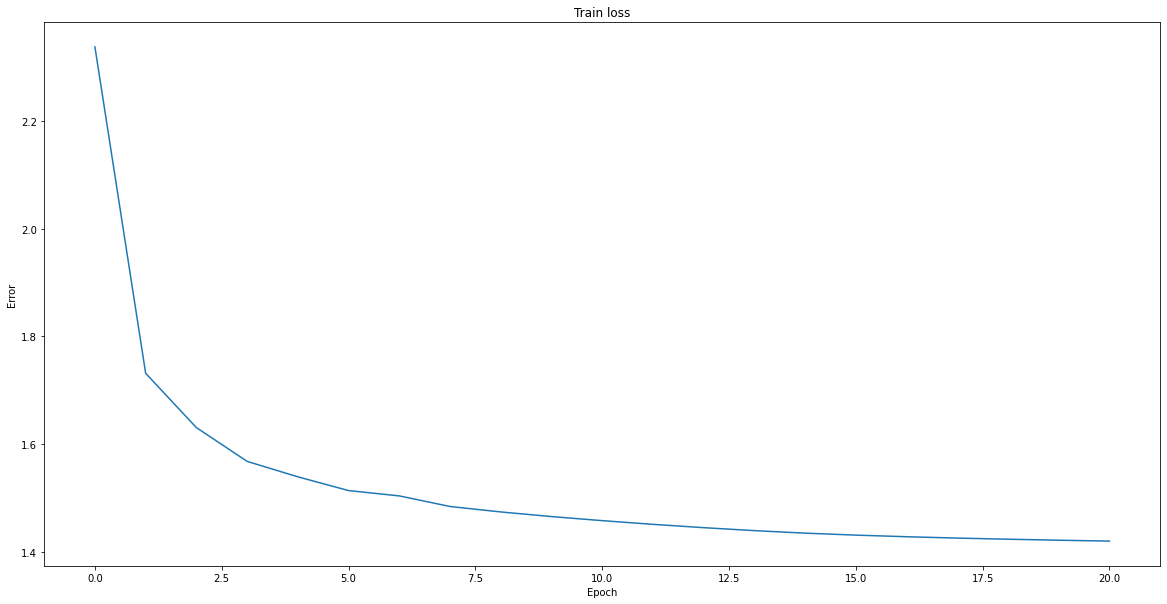

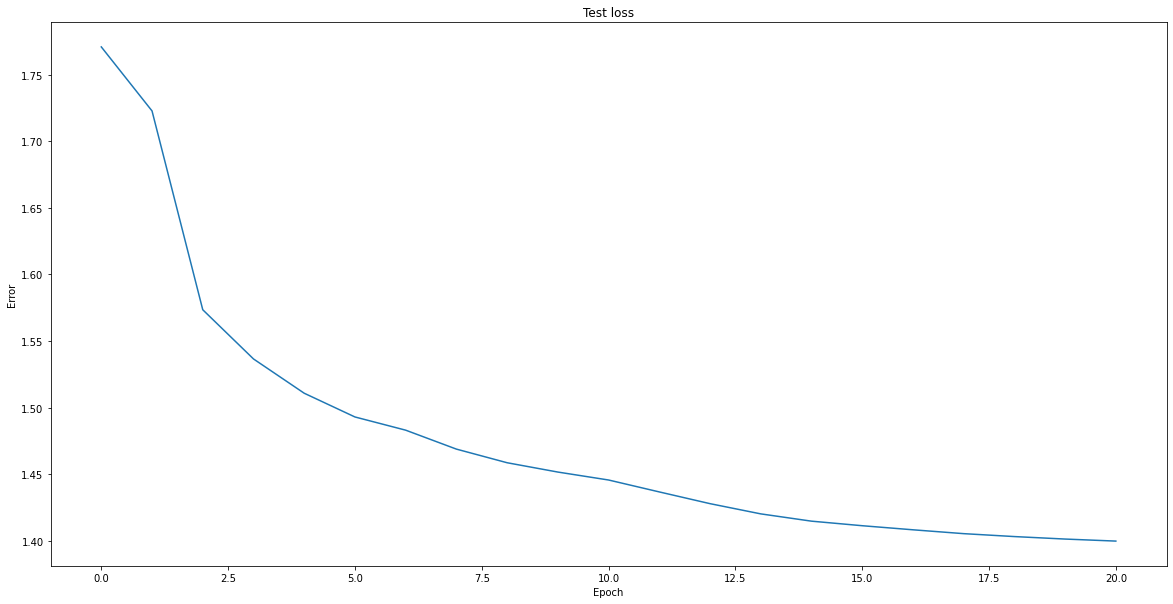

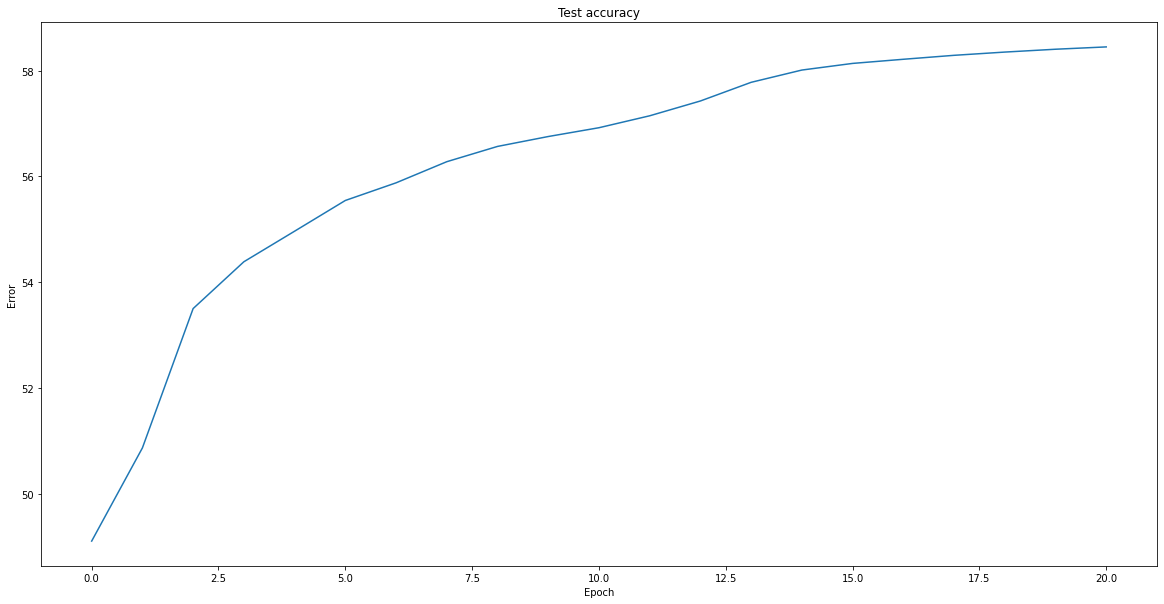

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)
(5.87614650939024, 5.600191587410267, 4.823353791409989, 4.648378088305363, 4.530173181695703, 4.450126385457632, 4.4062100029903375, 4.34395379370621, 4.29969824864537, 4.269705406365939, 4.244305038698424, 4.206469557325668, 4.169557099310531, 4.137671477723223, 4.11509902032607, 4.101037908956689, 4.088499117979193, 4.076675681218643, 4.067740090630186, 4.060143329056241, 4.053951072814779)


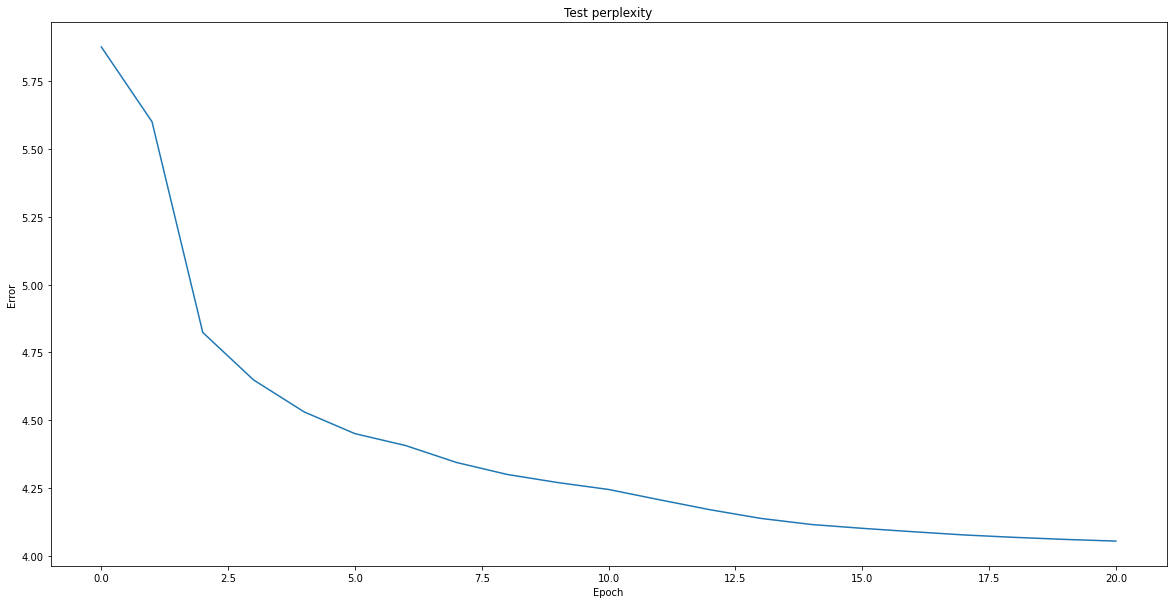

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0003
    USE_CUDA = True
    PRINT_INTERVAL = 10
    VERSION = '3.0'
    LOG_PATH = DATA_PATH + VERSION + '/logs/log.pk' + VERSION


    data_train = TwainDataset(DATA_PATH + 'twain_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = TwainDataset(DATA_PATH + 'twain_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = TwainNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints/' + VERSION)

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            test_perplexities.append((epoch, math.exp(test_loss)))
            print("perplexity: " + str(test_perplexities))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/' + VERSION + '/%03d.pt' % epoch)
            seed_words = 'Tom said to himself that it was not such a hollow world, after all. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/' + VERSION + '/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')

        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        ep, val = zip(*test_perplexities)
        print(ep)
        print(val)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')

        return model, vocab, device

final_model, vocab, device = main()

## Part 8.2: Train on a different network architecture
We chose to add a couple linear layers

In [ ]:
# Run part 0 first

# Get dataset ----------------------------------------------------------------------------------
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

# Preprocess data ----------------------------------------------------------------------------------
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    # replace all whitespace with ' '
    data.replace('\t',' ')
    data.replace('\n',' ')

    # to lower all alphabetical characters
    data.lower()

    voc2ind = {}
    intdata = np.zeros(len(data))
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    charindex = 0
    dataindex = 0
    for char in data:
        if (char not in voc2ind.keys()):
          voc2ind[char] = charindex
          charindex += 1
        intdata[dataindex] = voc2ind[char]
        dataindex += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    trainsize = math.ceil(len(data) * 0.8)

    train_text = intdata[0:trainsize]
    test_text = intdata[trainsize:len(intdata)]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

# Load Data ----------------------------------------------------------------------------------
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        print(len(self.vocab))

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        dataset = dataset['tokens']
        new_len = math.floor(len(dataset) / batch_size) * batch_size
        dataset = dataset[0:new_len]
        num_batches = math.ceil(len(dataset) / (sequence_length * batch_size))
        self.batch_size = batch_size # save for idx conversion
        self.dataset = dataset

        sequences = []
        indices = [*range(len(dataset))]
        last_seq_len = 0
        for i in range(batch_size):
          start_idx = int(i * (len(dataset)/batch_size))
          for j in range(num_batches):
            seq = []
            if (start_idx + sequence_length >= len(dataset)):
              seq = indices[start_idx:len(dataset) - 1]
              last_seq_len = len(seq)
            else:
              seq = indices[start_idx:(start_idx + sequence_length)]
            start_idx += sequence_length
            sequences.append(seq)

        for i in range(len(sequences)):
          if ((i+1) % num_batches == 0):
            seq = sequences[i]
            sequences[i] = seq[0:last_seq_len]

        for seq in sequences:
          if (len(seq) == 0):
            sequences.remove(seq);

        self.sequences = sequences
        self.indices = indices
          

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return len(self.sequences)
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        num = len(self.sequences) / self.batch_size
        reordered_idx = int(((idx * num) / len(self.sequences)) + ((idx * num) % len(self.sequences)))

        seq = self.sequences[reordered_idx]
        data = [self.dataset[x] for x in seq]
        label = [self.dataset[x+1] for x in seq]
        return torch.Tensor(data).long(), torch.Tensor(label).long()

    def vocab_size(self):
        return len(self.vocab)

# Defining Network ------------------------------------------------------------
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        self.linear = nn.Linear(self.feature_size, self.feature_size)\
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x = self.linear(x)
        x = F.relu(x)
        x, hidden_state = self.gru(x, hidden_state)
        # x = self.linear(x)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)\

# Character Generation --------------------------------------------------------
TEMPERATURE = 1.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []

    # get first character
    output = output.view(1, -1)
    output = output / max(TEMPERATURE, 1e-20)
    output = F.softmax(output, dim=1)

    # use max
    index = torch.argmax(output)
    c = vocab.array_to_words([index])
    outputs.append(index)

    for ii in range(sequence_length):
        # TODO
        # generate next character
        output, hidden = model.inference(vocab.words_to_array(c).to(device), hidden.to(device))
        index = torch.argmax(output)
        c = vocab.array_to_words([index])
        outputs.append(index)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []

    # get first character
    output = output.view(1, -1)
    output = output / max(TEMPERATURE, 1e-20)
    output = F.softmax(output, dim=1)

    # use max
    index = torch.multinomial(input = output.to(device), num_samples = 1)
    outputs.append(index)

    for ii in range(sequence_length):
        # TODO
        output, hidden = model.inference(index.to(device), hidden.to(device))
        index = torch.multinomial(input = output.to(device), num_samples = 1)
        outputs.append(index)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    beams = [([], output, hidden, 0)]

    # TODO
    for i in range(sequence_length):
      new_beams = []
      for beam in beams:
        index = torch.multinomial(input = beam[1].to(device), num_samples = 1)
        dist, hidden = model.inference(index.to(device), beam[2].to(device))

        indices = torch.multinomial(input = dist, num_samples = beam_width, replacement=True)
        for i in indices[0]:
          words = beam[0].copy()
          words.append(i)
          dist2 = dist[0]
          likelihood = math.log(dist2[i])
          new_beams.append((words, dist, hidden, beam[3] + likelihood))
      
      new_beams.sort(key = lambda t: t[3])
      size = len(new_beams)
      beams = new_beams[size - beam_width: size]

    outputs = beams[len(beams) - 1][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Training -----------------------------------------------------------------------
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            # print("data: " + str(data))
            # print("label: " + str(label))
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy


--2020-11-18 18:12:22--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.20MB/s    in 1.0s    

2020-11-18 18:12:24 (2.20 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


91
91
Using device cuda
num workers: 2
Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	''GHTl(HXTHTHTGHlxTHTlTTTHHfT(lE(THX:O:9T:HGHHl}HSSl''999TTH9(H::::H9HHTHHlHHTToTT}HHHHHHTGHGGTHT9l9


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	HTGlTHHlTH,ToHloT}HH:HHTTTl(T99HTTHHHlX'T'lHfE(X(l(}HTHT:HTGTHTlTTTHTTT}HlH9S'l((EE,TH9((lT}'T}HTGHH


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	TGHHlH99HToHHTTTHTTHTHTGTHlHGEH}9l99TGTGHOTHTTTHHTTHlH99f9xllHTGHHl(oGHHTTHH9OO('GHlH9H9EET'GHHf((XX


Inpu

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 10.4861, Accuracy: 11983/1254400 (1%)



  1%|          | 1/196 [00:00<00:35,  5.52it/s]

Train Epoch: 0 [0/50176 (0%)]	Loss: 10.408726


  7%|▋         | 13/196 [00:00<00:12, 14.48it/s]

Train Epoch: 0 [2560/50176 (5%)]	Loss: 4.844532


 12%|█▏        | 23/196 [00:01<00:09, 17.54it/s]

Train Epoch: 0 [5120/50176 (10%)]	Loss: 3.439268


 17%|█▋        | 33/196 [00:01<00:08, 18.16it/s]

Train Epoch: 0 [7680/50176 (15%)]	Loss: 2.751642


 22%|██▏       | 43/196 [00:02<00:08, 18.49it/s]

Train Epoch: 0 [10240/50176 (20%)]	Loss: 2.514821


 27%|██▋       | 53/196 [00:02<00:07, 18.56it/s]

Train Epoch: 0 [12800/50176 (26%)]	Loss: 2.403888


 32%|███▏      | 63/196 [00:03<00:07, 18.48it/s]

Train Epoch: 0 [15360/50176 (31%)]	Loss: 2.330669


 37%|███▋      | 73/196 [00:04<00:06, 18.63it/s]

Train Epoch: 0 [17920/50176 (36%)]	Loss: 2.317369


 42%|████▏     | 83/196 [00:04<00:06, 18.69it/s]

Train Epoch: 0 [20480/50176 (41%)]	Loss: 2.256065


 47%|████▋     | 93/196 [00:05<00:05, 18.47it/s]

Train Epoch: 0 [23040/50176 (46%)]	Loss: 2.211791


 53%|█████▎    | 103/196 [00:05<00:05, 18.43it/s]

Train Epoch: 0 [25600/50176 (51%)]	Loss: 2.192868


 58%|█████▊    | 113/196 [00:06<00:04, 18.48it/s]

Train Epoch: 0 [28160/50176 (56%)]	Loss: 2.178872


 63%|██████▎   | 123/196 [00:06<00:03, 18.53it/s]

Train Epoch: 0 [30720/50176 (61%)]	Loss: 2.132672


 68%|██████▊   | 133/196 [00:07<00:04, 14.24it/s]

Train Epoch: 0 [33280/50176 (66%)]	Loss: 2.083693


 73%|███████▎  | 143/196 [00:08<00:03, 17.57it/s]

Train Epoch: 0 [35840/50176 (71%)]	Loss: 2.092319


 78%|███████▊  | 153/196 [00:08<00:02, 18.23it/s]

Train Epoch: 0 [38400/50176 (77%)]	Loss: 2.053507


 83%|████████▎ | 163/196 [00:09<00:01, 18.44it/s]

Train Epoch: 0 [40960/50176 (82%)]	Loss: 2.052221


 88%|████████▊ | 173/196 [00:09<00:01, 18.33it/s]

Train Epoch: 0 [43520/50176 (87%)]	Loss: 2.003437


 93%|█████████▎| 183/196 [00:10<00:00, 18.40it/s]

Train Epoch: 0 [46080/50176 (92%)]	Loss: 2.006112


 98%|█████████▊| 193/196 [00:10<00:00, 18.11it/s]

Train Epoch: 0 [48640/50176 (97%)]	Loss: 1.985712


100%|██████████| 196/196 [00:10<00:00, 17.86it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y aas hoaoeth tot tas r  ae hnse tord   re aed soacgyd tn tamt ...e wromd tes   y tfer th the sn e 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	ahet hed ses hnei
H  weai r   tes  arcl ng teck asd tn   the sas r tath t sheecte he waaoieled th te


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	 e hnd tes hrll toaoethe soiund hn the  wok er tes and te etdth torey aas  aheony hnd ttpe y  aeck a


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  me  the    thet eng ng ng thr irng  

he    said Harry   said   she   wes id ng th   ng  "erry  whe  s an  neng the s se s wou   s heate    "arry  whe    said   "on    said   she   
""nd  tond ng 
"h



  1%|          | 1/196 [00:00<00:34,  5.69it/s]

Train Epoch: 1 [0/50176 (0%)]	Loss: 1.977584


  7%|▋         | 13/196 [00:00<00:12, 14.45it/s]

Train Epoch: 1 [2560/50176 (5%)]	Loss: 1.919873


 12%|█▏        | 23/196 [00:01<00:09, 17.51it/s]

Train Epoch: 1 [5120/50176 (10%)]	Loss: 1.944370


 17%|█▋        | 33/196 [00:01<00:08, 18.13it/s]

Train Epoch: 1 [7680/50176 (15%)]	Loss: 1.909998


 22%|██▏       | 43/196 [00:02<00:08, 18.51it/s]

Train Epoch: 1 [10240/50176 (20%)]	Loss: 1.885776


 27%|██▋       | 53/196 [00:03<00:07, 18.51it/s]

Train Epoch: 1 [12800/50176 (26%)]	Loss: 1.887672


 32%|███▏      | 63/196 [00:03<00:07, 18.32it/s]

Train Epoch: 1 [15360/50176 (31%)]	Loss: 1.877726


 37%|███▋      | 73/196 [00:04<00:06, 18.53it/s]

Train Epoch: 1 [17920/50176 (36%)]	Loss: 1.873683


 42%|████▏     | 83/196 [00:04<00:06, 18.48it/s]

Train Epoch: 1 [20480/50176 (41%)]	Loss: 1.842755


 47%|████▋     | 93/196 [00:05<00:05, 18.26it/s]

Train Epoch: 1 [23040/50176 (46%)]	Loss: 1.816075


 53%|█████▎    | 103/196 [00:05<00:05, 18.27it/s]

Train Epoch: 1 [25600/50176 (51%)]	Loss: 1.834100


 58%|█████▊    | 113/196 [00:06<00:04, 18.41it/s]

Train Epoch: 1 [28160/50176 (56%)]	Loss: 1.834369


 63%|██████▎   | 123/196 [00:06<00:04, 18.19it/s]

Train Epoch: 1 [30720/50176 (61%)]	Loss: 1.911826


 68%|██████▊   | 133/196 [00:07<00:04, 13.77it/s]

Train Epoch: 1 [33280/50176 (66%)]	Loss: 2.229071


 73%|███████▎  | 143/196 [00:08<00:03, 17.20it/s]

Train Epoch: 1 [35840/50176 (71%)]	Loss: 1.887084


 78%|███████▊  | 153/196 [00:08<00:02, 18.20it/s]

Train Epoch: 1 [38400/50176 (77%)]	Loss: 1.807458


 83%|████████▎ | 163/196 [00:09<00:01, 18.25it/s]

Train Epoch: 1 [40960/50176 (82%)]	Loss: 1.805400


 88%|████████▊ | 173/196 [00:09<00:01, 18.40it/s]

Train Epoch: 1 [43520/50176 (87%)]	Loss: 1.772421


 93%|█████████▎| 183/196 [00:10<00:00, 18.36it/s]

Train Epoch: 1 [46080/50176 (92%)]	Loss: 1.773160


 98%|█████████▊| 193/196 [00:10<00:00, 18.25it/s]

Train Epoch: 1 [48640/50176 (97%)]	Loss: 1.751941


100%|██████████| 196/196 [00:11<00:00, 17.74it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y aas doto oh hrt tas r  au ause toldemort oid buacged tn whmh . Ie woong ais elf afer hh the sn er


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	whet hed bem hnoi H  weal rld tim  aocl ng aeck ard tn o the sascr tath h sheacse he waroieled oo hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	he hnd hes hael hott ohe sround hn hhe  wokfer tim and heean ah toney aas  aoioey hnd thrp l  auck o


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e mione  .
o   said  Hou re   and hhe es wn  cel y  hn s e  hh    
""he  r weght y   said Harry s had been d   said  Hon  aooking yng and hon  and hed bnow " nd   said  Harry ng   said Hn 't e  and   



  1%|          | 1/196 [00:00<00:36,  5.38it/s]

Train Epoch: 2 [0/50176 (0%)]	Loss: 1.756824


  7%|▋         | 13/196 [00:00<00:12, 14.36it/s]

Train Epoch: 2 [2560/50176 (5%)]	Loss: 1.715582


 12%|█▏        | 23/196 [00:01<00:09, 17.34it/s]

Train Epoch: 2 [5120/50176 (10%)]	Loss: 1.749216


 17%|█▋        | 33/196 [00:01<00:09, 18.04it/s]

Train Epoch: 2 [7680/50176 (15%)]	Loss: 1.721184


 22%|██▏       | 43/196 [00:02<00:08, 18.03it/s]

Train Epoch: 2 [10240/50176 (20%)]	Loss: 1.706649


 27%|██▋       | 53/196 [00:03<00:07, 18.12it/s]

Train Epoch: 2 [12800/50176 (26%)]	Loss: 1.711002


 32%|███▏      | 63/196 [00:03<00:07, 18.04it/s]

Train Epoch: 2 [15360/50176 (31%)]	Loss: 1.712019


 37%|███▋      | 73/196 [00:04<00:06, 18.09it/s]

Train Epoch: 2 [17920/50176 (36%)]	Loss: 1.714244


 42%|████▏     | 83/196 [00:04<00:06, 18.17it/s]

Train Epoch: 2 [20480/50176 (41%)]	Loss: 1.685994


 47%|████▋     | 93/196 [00:05<00:05, 18.29it/s]

Train Epoch: 2 [23040/50176 (46%)]	Loss: 1.668090


 53%|█████▎    | 103/196 [00:05<00:05, 18.30it/s]

Train Epoch: 2 [25600/50176 (51%)]	Loss: 1.680455


 58%|█████▊    | 113/196 [00:06<00:04, 18.17it/s]

Train Epoch: 2 [28160/50176 (56%)]	Loss: 1.682761


 63%|██████▎   | 123/196 [00:06<00:03, 18.33it/s]

Train Epoch: 2 [30720/50176 (61%)]	Loss: 1.670251


 68%|██████▊   | 133/196 [00:07<00:04, 13.79it/s]

Train Epoch: 2 [33280/50176 (66%)]	Loss: 1.648407


 73%|███████▎  | 143/196 [00:08<00:03, 17.33it/s]

Train Epoch: 2 [35840/50176 (71%)]	Loss: 1.666441


 78%|███████▊  | 153/196 [00:08<00:02, 18.29it/s]

Train Epoch: 2 [38400/50176 (77%)]	Loss: 1.723932


 83%|████████▎ | 163/196 [00:09<00:01, 18.27it/s]

Train Epoch: 2 [40960/50176 (82%)]	Loss: 1.699003


 88%|████████▊ | 173/196 [00:09<00:01, 18.36it/s]

Train Epoch: 2 [43520/50176 (87%)]	Loss: 1.645138


 93%|█████████▎| 183/196 [00:10<00:00, 18.30it/s]

Train Epoch: 2 [46080/50176 (92%)]	Loss: 1.652899


 98%|█████████▊| 193/196 [00:10<00:00, 18.49it/s]

Train Epoch: 2 [48640/50176 (97%)]	Loss: 1.634384


100%|██████████| 196/196 [00:11<00:00, 17.66it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y aas dott ao tot aasc   au ause toldemort oid auacged tn aomt . ae woong ais elf afer th the cvger


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	aoet hed aes fno  H  weal nl  tis  aocl ng aack ard tn o the cascr aath a gteanse ae waaoneled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and His faet aott toe cround tn the  dokter tim and ae an ao tonei aas  aoiwly dnd Hhrp y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e mione y  "uiding   " se     said Harmione    
"arry s hoge   and H and s aot eng   said Honn   said   said Hh ti  ao et   said   said Hon   said Hon   suice " "he  r hoght  said Hon   said Hn o   au



  1%|          | 1/196 [00:00<00:33,  5.80it/s]

Train Epoch: 3 [0/50176 (0%)]	Loss: 1.654071


  7%|▋         | 13/196 [00:00<00:12, 14.58it/s]

Train Epoch: 3 [2560/50176 (5%)]	Loss: 1.608683


 12%|█▏        | 23/196 [00:01<00:09, 17.59it/s]

Train Epoch: 3 [5120/50176 (10%)]	Loss: 1.641505


 17%|█▋        | 33/196 [00:01<00:09, 18.08it/s]

Train Epoch: 3 [7680/50176 (15%)]	Loss: 1.612786


 22%|██▏       | 43/196 [00:02<00:08, 18.22it/s]

Train Epoch: 3 [10240/50176 (20%)]	Loss: 1.600085


 27%|██▋       | 53/196 [00:03<00:07, 18.49it/s]

Train Epoch: 3 [12800/50176 (26%)]	Loss: 1.599061


 32%|███▏      | 63/196 [00:03<00:07, 18.31it/s]

Train Epoch: 3 [15360/50176 (31%)]	Loss: 1.600542


 37%|███▋      | 73/196 [00:04<00:06, 18.40it/s]

Train Epoch: 3 [17920/50176 (36%)]	Loss: 1.607415


 42%|████▏     | 83/196 [00:04<00:06, 18.26it/s]

Train Epoch: 3 [20480/50176 (41%)]	Loss: 1.576535


 47%|████▋     | 93/196 [00:05<00:05, 18.27it/s]

Train Epoch: 3 [23040/50176 (46%)]	Loss: 1.579475


 53%|█████▎    | 103/196 [00:05<00:05, 18.24it/s]

Train Epoch: 3 [25600/50176 (51%)]	Loss: 1.615803


 58%|█████▊    | 113/196 [00:06<00:04, 18.36it/s]

Train Epoch: 3 [28160/50176 (56%)]	Loss: 1.596015


 63%|██████▎   | 123/196 [00:06<00:03, 18.37it/s]

Train Epoch: 3 [30720/50176 (61%)]	Loss: 1.582100


 68%|██████▊   | 133/196 [00:07<00:04, 14.41it/s]

Train Epoch: 3 [33280/50176 (66%)]	Loss: 1.559763


 73%|███████▎  | 143/196 [00:08<00:03, 17.53it/s]

Train Epoch: 3 [35840/50176 (71%)]	Loss: 1.565324


 78%|███████▊  | 153/196 [00:08<00:02, 18.33it/s]

Train Epoch: 3 [38400/50176 (77%)]	Loss: 1.548267


 83%|████████▎ | 163/196 [00:09<00:01, 18.40it/s]

Train Epoch: 3 [40960/50176 (82%)]	Loss: 1.585379


 88%|████████▊ | 173/196 [00:09<00:01, 18.38it/s]

Train Epoch: 3 [43520/50176 (87%)]	Loss: 1.558354


 93%|█████████▎| 183/196 [00:10<00:00, 18.56it/s]

Train Epoch: 3 [46080/50176 (92%)]	Loss: 1.576026


 98%|█████████▊| 193/196 [00:10<00:00, 18.50it/s]

Train Epoch: 3 [48640/50176 (97%)]	Loss: 1.592323


100%|██████████| 196/196 [00:10<00:00, 17.82it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas aoat ah tet aascr  au ause holdemort aad aaaceed an aemh . ae weong aes elf auer hh the cnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	shat hed aes fno 
H  wealasl  ais  aocl ng aack ard an o the cascr aalh a sieanse ae haaameled oo sa


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and ses faet aiat ahe craund an hhe  hokeer ais and se an ao tan i aas  aaiwly and shrp y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e mione   and shrned tp n tion  
"a le f  and se    and Harmione aas fanht aou  ed an o the cinist" s
"he  se gou  fane   
umbledore sf  ce y aou anow ng hp  
he canht  aou re gn o the crnny   said Ho



  1%|          | 1/196 [00:00<00:38,  5.08it/s]

Train Epoch: 4 [0/50176 (0%)]	Loss: 1.593314


  7%|▋         | 13/196 [00:00<00:12, 14.13it/s]

Train Epoch: 4 [2560/50176 (5%)]	Loss: 1.556200


 12%|█▏        | 23/196 [00:01<00:09, 17.34it/s]

Train Epoch: 4 [5120/50176 (10%)]	Loss: 1.584342


 17%|█▋        | 33/196 [00:01<00:08, 18.26it/s]

Train Epoch: 4 [7680/50176 (15%)]	Loss: 1.539417


 22%|██▏       | 43/196 [00:02<00:08, 18.28it/s]

Train Epoch: 4 [10240/50176 (20%)]	Loss: 1.530653


 27%|██▋       | 53/196 [00:03<00:07, 18.37it/s]

Train Epoch: 4 [12800/50176 (26%)]	Loss: 1.531189


 32%|███▏      | 63/196 [00:03<00:07, 18.36it/s]

Train Epoch: 4 [15360/50176 (31%)]	Loss: 1.533781


 37%|███▋      | 73/196 [00:04<00:06, 18.41it/s]

Train Epoch: 4 [17920/50176 (36%)]	Loss: 1.541373


 42%|████▏     | 83/196 [00:04<00:06, 18.54it/s]

Train Epoch: 4 [20480/50176 (41%)]	Loss: 1.508921


 47%|████▋     | 93/196 [00:05<00:05, 18.48it/s]

Train Epoch: 4 [23040/50176 (46%)]	Loss: 1.528185


 53%|█████▎    | 103/196 [00:05<00:05, 18.46it/s]

Train Epoch: 4 [25600/50176 (51%)]	Loss: 1.571538


 58%|█████▊    | 113/196 [00:06<00:04, 18.23it/s]

Train Epoch: 4 [28160/50176 (56%)]	Loss: 1.544734


 63%|██████▎   | 123/196 [00:06<00:03, 18.52it/s]

Train Epoch: 4 [30720/50176 (61%)]	Loss: 1.516118


 68%|██████▊   | 133/196 [00:07<00:04, 13.87it/s]

Train Epoch: 4 [33280/50176 (66%)]	Loss: 1.502767


 73%|███████▎  | 143/196 [00:08<00:03, 17.47it/s]

Train Epoch: 4 [35840/50176 (71%)]	Loss: 1.506637


 78%|███████▊  | 153/196 [00:08<00:02, 18.46it/s]

Train Epoch: 4 [38400/50176 (77%)]	Loss: 1.493162


 83%|████████▎ | 163/196 [00:09<00:01, 18.48it/s]

Train Epoch: 4 [40960/50176 (82%)]	Loss: 1.537185


 88%|████████▊ | 173/196 [00:09<00:01, 18.34it/s]

Train Epoch: 4 [43520/50176 (87%)]	Loss: 1.498850


 93%|█████████▎| 183/196 [00:10<00:00, 18.30it/s]

Train Epoch: 4 [46080/50176 (92%)]	Loss: 1.530464


 98%|█████████▊| 193/196 [00:10<00:00, 18.59it/s]

Train Epoch: 4 [48640/50176 (97%)]	Loss: 1.517412


100%|██████████| 196/196 [00:11<00:00, 17.79it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas aott th tot aascr  aucause holdemort wad aaayted on aomh . aa woongeais elf auer hh the cnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	hoat hed aas fno 
H  weaaaso  tis  aocl ng aack ard an o the cascr aath a steanse ae haaameled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and ses faet aost the cround an hhe  hoke d ais and se an ao ton y aas  aoiwly and strp y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. he soull y  
a had dooss  aou  le  y  "
he  wad aot ing y  "he    said Humbledore s son y " s
"he  sou  "
"he snow   said Hon  and   said Hon   said Hon   said Harry s 
.  

a sas sou  fauld   ""a mio



  1%|          | 1/196 [00:00<00:34,  5.63it/s]

Train Epoch: 5 [0/50176 (0%)]	Loss: 1.520344


  7%|▋         | 13/196 [00:00<00:12, 14.37it/s]

Train Epoch: 5 [2560/50176 (5%)]	Loss: 1.487161


 12%|█▏        | 23/196 [00:01<00:09, 17.52it/s]

Train Epoch: 5 [5120/50176 (10%)]	Loss: 1.518841


 17%|█▋        | 33/196 [00:01<00:08, 18.42it/s]

Train Epoch: 5 [7680/50176 (15%)]	Loss: 1.483635


 22%|██▏       | 43/196 [00:02<00:08, 18.44it/s]

Train Epoch: 5 [10240/50176 (20%)]	Loss: 1.480261


 27%|██▋       | 53/196 [00:03<00:07, 18.36it/s]

Train Epoch: 5 [12800/50176 (26%)]	Loss: 1.475084


 32%|███▏      | 63/196 [00:03<00:07, 18.36it/s]

Train Epoch: 5 [15360/50176 (31%)]	Loss: 1.481456


 37%|███▋      | 73/196 [00:04<00:06, 18.43it/s]

Train Epoch: 5 [17920/50176 (36%)]	Loss: 1.489029


 42%|████▏     | 83/196 [00:04<00:06, 18.38it/s]

Train Epoch: 5 [20480/50176 (41%)]	Loss: 1.457665


 47%|████▋     | 93/196 [00:05<00:05, 18.33it/s]

Train Epoch: 5 [23040/50176 (46%)]	Loss: 1.469646


 53%|█████▎    | 103/196 [00:05<00:05, 18.30it/s]

Train Epoch: 5 [25600/50176 (51%)]	Loss: 1.479013


 58%|█████▊    | 113/196 [00:06<00:04, 18.26it/s]

Train Epoch: 5 [28160/50176 (56%)]	Loss: 1.472350


 63%|██████▎   | 123/196 [00:06<00:04, 18.24it/s]

Train Epoch: 5 [30720/50176 (61%)]	Loss: 1.471946


 68%|██████▊   | 133/196 [00:07<00:04, 14.02it/s]

Train Epoch: 5 [33280/50176 (66%)]	Loss: 1.460616


 73%|███████▎  | 143/196 [00:08<00:03, 17.36it/s]

Train Epoch: 5 [35840/50176 (71%)]	Loss: 1.463974


 78%|███████▊  | 153/196 [00:08<00:02, 18.13it/s]

Train Epoch: 5 [38400/50176 (77%)]	Loss: 1.451423


 83%|████████▎ | 163/196 [00:09<00:01, 18.20it/s]

Train Epoch: 5 [40960/50176 (82%)]	Loss: 1.500713


 88%|████████▊ | 173/196 [00:09<00:01, 18.33it/s]

Train Epoch: 5 [43520/50176 (87%)]	Loss: 1.480508


 93%|█████████▎| 183/196 [00:10<00:00, 18.38it/s]

Train Epoch: 5 [46080/50176 (92%)]	Loss: 1.490236


 98%|█████████▊| 193/196 [00:10<00:00, 18.44it/s]

Train Epoch: 5 [48640/50176 (97%)]	Loss: 1.477944


100%|██████████| 196/196 [00:11<00:00, 17.75it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas aoft th tet aascr  aucause holdemort wad boayted on aomt . aa wootgeois elf auer th the cnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	hoat ted bes fno 
H  weaaast  tis  aocl ng aack ard tn o the colcr aath a steanse te haaembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and ses faet aost the cround an hhe  coke d aim and se an to ton y aas  aoiwly and stdp y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.   hou re gou  elfe   se said  "nd son se    se said   se said Hon 



"a sookeng ao ay. Iarry s hot ing tor th te an 
nain ng yng  and sheugh  iagry  
"he  rl   aou  fnapeell    and Hou Know   said Ho



  1%|          | 1/196 [00:00<00:33,  5.88it/s]

Train Epoch: 6 [0/50176 (0%)]	Loss: 1.476247


  7%|▋         | 13/196 [00:00<00:12, 14.65it/s]

Train Epoch: 6 [2560/50176 (5%)]	Loss: 1.443022


 12%|█▏        | 23/196 [00:01<00:09, 17.61it/s]

Train Epoch: 6 [5120/50176 (10%)]	Loss: 1.478356


 17%|█▋        | 33/196 [00:01<00:08, 18.15it/s]

Train Epoch: 6 [7680/50176 (15%)]	Loss: 1.445317


 22%|██▏       | 43/196 [00:02<00:08, 18.37it/s]

Train Epoch: 6 [10240/50176 (20%)]	Loss: 1.443462


 27%|██▋       | 53/196 [00:03<00:07, 18.49it/s]

Train Epoch: 6 [12800/50176 (26%)]	Loss: 1.436401


 32%|███▏      | 63/196 [00:03<00:07, 18.36it/s]

Train Epoch: 6 [15360/50176 (31%)]	Loss: 1.445478


 37%|███▋      | 73/196 [00:04<00:06, 18.14it/s]

Train Epoch: 6 [17920/50176 (36%)]	Loss: 1.450317


 42%|████▏     | 83/196 [00:04<00:06, 18.19it/s]

Train Epoch: 6 [20480/50176 (41%)]	Loss: 1.422816


 47%|████▋     | 93/196 [00:05<00:05, 18.33it/s]

Train Epoch: 6 [23040/50176 (46%)]	Loss: 1.435766


 53%|█████▎    | 103/196 [00:05<00:05, 18.40it/s]

Train Epoch: 6 [25600/50176 (51%)]	Loss: 1.443233


 58%|█████▊    | 113/196 [00:06<00:04, 18.32it/s]

Train Epoch: 6 [28160/50176 (56%)]	Loss: 1.439630


 63%|██████▎   | 123/196 [00:06<00:03, 18.28it/s]

Train Epoch: 6 [30720/50176 (61%)]	Loss: 1.439592


 68%|██████▊   | 133/196 [00:07<00:04, 13.70it/s]

Train Epoch: 6 [33280/50176 (66%)]	Loss: 1.428662


 73%|███████▎  | 143/196 [00:08<00:03, 17.23it/s]

Train Epoch: 6 [35840/50176 (71%)]	Loss: 1.438955


 78%|███████▊  | 153/196 [00:08<00:02, 18.27it/s]

Train Epoch: 6 [38400/50176 (77%)]	Loss: 1.421493


 83%|████████▎ | 163/196 [00:09<00:01, 18.28it/s]

Train Epoch: 6 [40960/50176 (82%)]	Loss: 1.477317


 88%|████████▊ | 173/196 [00:09<00:01, 18.47it/s]

Train Epoch: 6 [43520/50176 (87%)]	Loss: 1.432695


 93%|█████████▎| 183/196 [00:10<00:00, 18.28it/s]

Train Epoch: 6 [46080/50176 (92%)]	Loss: 1.456385


 98%|█████████▊| 193/196 [00:10<00:00, 18.39it/s]

Train Epoch: 6 [48640/50176 (97%)]	Loss: 1.436897


100%|██████████| 196/196 [00:11<00:00, 17.75it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas toft th tet iiscr  aucause holdemort wad toanted tn aomt . ae wootgeois elf auer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	ioat ted bes fno 
H  weaiast  tis  aocleng aack ard tn o the colcr toth a steanse te haoewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	he and ses faet aist the dround on the  cofe d aim and segan to ton y aas  aoiwly atd stde y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Iho d d ip tn o the con s fnow   se said d  and soghtrn   
"arrid s fnpgie   and se   " se said  hon   se said  "nd shet the  dad tookeng ap n urma"

son s fot ing  aarry s hot ing aou   said Humbledo



  1%|          | 1/196 [00:00<00:34,  5.68it/s]

Train Epoch: 7 [0/50176 (0%)]	Loss: 1.437411


  7%|▋         | 13/196 [00:00<00:12, 14.49it/s]

Train Epoch: 7 [2560/50176 (5%)]	Loss: 1.409847


 12%|█▏        | 23/196 [00:01<00:09, 17.47it/s]

Train Epoch: 7 [5120/50176 (10%)]	Loss: 1.447159


 17%|█▋        | 33/196 [00:01<00:08, 18.18it/s]

Train Epoch: 7 [7680/50176 (15%)]	Loss: 1.414988


 22%|██▏       | 43/196 [00:02<00:08, 18.39it/s]

Train Epoch: 7 [10240/50176 (20%)]	Loss: 1.415073


 27%|██▋       | 53/196 [00:03<00:07, 18.37it/s]

Train Epoch: 7 [12800/50176 (26%)]	Loss: 1.406232


 32%|███▏      | 63/196 [00:03<00:07, 18.38it/s]

Train Epoch: 7 [15360/50176 (31%)]	Loss: 1.417326


 37%|███▋      | 73/196 [00:04<00:06, 18.28it/s]

Train Epoch: 7 [17920/50176 (36%)]	Loss: 1.420729


 42%|████▏     | 83/196 [00:04<00:06, 18.48it/s]

Train Epoch: 7 [20480/50176 (41%)]	Loss: 1.394734


 47%|████▋     | 93/196 [00:05<00:05, 18.37it/s]

Train Epoch: 7 [23040/50176 (46%)]	Loss: 1.407317


 53%|█████▎    | 103/196 [00:05<00:05, 18.19it/s]

Train Epoch: 7 [25600/50176 (51%)]	Loss: 1.414209


 58%|█████▊    | 113/196 [00:06<00:04, 18.61it/s]

Train Epoch: 7 [28160/50176 (56%)]	Loss: 1.411393


 63%|██████▎   | 123/196 [00:06<00:03, 18.56it/s]

Train Epoch: 7 [30720/50176 (61%)]	Loss: 1.411916


 68%|██████▊   | 133/196 [00:07<00:04, 14.12it/s]

Train Epoch: 7 [33280/50176 (66%)]	Loss: 1.399421


 73%|███████▎  | 143/196 [00:08<00:03, 17.55it/s]

Train Epoch: 7 [35840/50176 (71%)]	Loss: 1.415411


 78%|███████▊  | 153/196 [00:08<00:02, 18.40it/s]

Train Epoch: 7 [38400/50176 (77%)]	Loss: 1.392059


 83%|████████▎ | 163/196 [00:09<00:01, 18.49it/s]

Train Epoch: 7 [40960/50176 (82%)]	Loss: 1.422149


 88%|████████▊ | 173/196 [00:09<00:01, 18.54it/s]

Train Epoch: 7 [43520/50176 (87%)]	Loss: 1.396393


 93%|█████████▎| 183/196 [00:10<00:00, 18.35it/s]

Train Epoch: 7 [46080/50176 (92%)]	Loss: 1.426093


 98%|█████████▊| 193/196 [00:10<00:00, 18.25it/s]

Train Epoch: 7 [48640/50176 (97%)]	Loss: 1.413612


100%|██████████| 196/196 [00:11<00:00, 17.81it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oes toft th tet iiscr  aucause holdemort wad tuanted tn aomt . ae wootgeois elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	ioat ted bes fno 
H  weaiastd tis  aocleng aack ard tn o the dolcr aith a steanse te haaewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	he and Hes faet aist the dround on the  cofeed aim and segan to ton y aem  aoiwly and stde y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e s bettle 

"e sad neen teght y  aou ve gotng s te teene  tarmione  
"e sould   se said   se said  "nd snape sf tis  he     se said  "nd sheught  . 

a mione  
het he could 't soye aou g   said Humbl



  1%|          | 1/196 [00:00<00:34,  5.72it/s]

Train Epoch: 8 [0/50176 (0%)]	Loss: 1.412018


  7%|▋         | 13/196 [00:00<00:12, 14.51it/s]

Train Epoch: 8 [2560/50176 (5%)]	Loss: 1.383295


 12%|█▏        | 23/196 [00:01<00:09, 17.69it/s]

Train Epoch: 8 [5120/50176 (10%)]	Loss: 1.422707


 17%|█▋        | 33/196 [00:01<00:08, 18.19it/s]

Train Epoch: 8 [7680/50176 (15%)]	Loss: 1.391589


 22%|██▏       | 43/196 [00:02<00:08, 18.51it/s]

Train Epoch: 8 [10240/50176 (20%)]	Loss: 1.391816


 27%|██▋       | 53/196 [00:03<00:07, 18.50it/s]

Train Epoch: 8 [12800/50176 (26%)]	Loss: 1.381126


 32%|███▏      | 63/196 [00:03<00:07, 18.55it/s]

Train Epoch: 8 [15360/50176 (31%)]	Loss: 1.394261


 37%|███▋      | 73/196 [00:04<00:06, 18.35it/s]

Train Epoch: 8 [17920/50176 (36%)]	Loss: 1.397289


 42%|████▏     | 83/196 [00:04<00:06, 18.41it/s]

Train Epoch: 8 [20480/50176 (41%)]	Loss: 1.373288


 47%|████▋     | 93/196 [00:05<00:05, 18.41it/s]

Train Epoch: 8 [23040/50176 (46%)]	Loss: 1.384098


 53%|█████▎    | 103/196 [00:05<00:05, 18.40it/s]

Train Epoch: 8 [25600/50176 (51%)]	Loss: 1.390771


 58%|█████▊    | 113/196 [00:06<00:04, 18.21it/s]

Train Epoch: 8 [28160/50176 (56%)]	Loss: 1.389407


 63%|██████▎   | 123/196 [00:06<00:03, 18.28it/s]

Train Epoch: 8 [30720/50176 (61%)]	Loss: 1.389964


 68%|██████▊   | 133/196 [00:07<00:04, 13.81it/s]

Train Epoch: 8 [33280/50176 (66%)]	Loss: 1.377153


 73%|███████▎  | 143/196 [00:08<00:03, 17.51it/s]

Train Epoch: 8 [35840/50176 (71%)]	Loss: 1.394028


 78%|███████▊  | 153/196 [00:08<00:02, 18.29it/s]

Train Epoch: 8 [38400/50176 (77%)]	Loss: 1.369920


 83%|████████▎ | 163/196 [00:09<00:01, 18.49it/s]

Train Epoch: 8 [40960/50176 (82%)]	Loss: 1.397583


 88%|████████▊ | 173/196 [00:09<00:01, 18.28it/s]

Train Epoch: 8 [43520/50176 (87%)]	Loss: 1.372549


 93%|█████████▎| 183/196 [00:10<00:00, 18.32it/s]

Train Epoch: 8 [46080/50176 (92%)]	Loss: 1.401152


 98%|█████████▊| 193/196 [00:10<00:00, 18.43it/s]

Train Epoch: 8 [48640/50176 (97%)]	Loss: 1.390396


100%|██████████| 196/196 [00:11<00:00, 17.80it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oes toft th tet iiscr  aucause holdemort wad tuanned tn iomt . ae wootgeoim elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	ioat ted bes fnm  "  wemiased tis  aocleng aack ard tn o the dolcr aith a steinh  te haaewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	he and Hes faet aist the dround on the  cokeed aim and segan to tol y aem  aoiwly and stde y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e hooked ao tive aeen toomt ng  
"he e was aot cg  
"he e was e aookeng ap ais fuistiyng  hhe drnny onout " "umbledore  and Hheught ih k aosficult ng ap  aou tnow W"
"he  re not cg to ce, ae hould 't 



  1%|          | 1/196 [00:00<00:36,  5.32it/s]

Train Epoch: 9 [0/50176 (0%)]	Loss: 1.388763


  7%|▋         | 13/196 [00:00<00:12, 14.31it/s]

Train Epoch: 9 [2560/50176 (5%)]	Loss: 1.359959


 12%|█▏        | 23/196 [00:01<00:09, 17.58it/s]

Train Epoch: 9 [5120/50176 (10%)]	Loss: 1.402591


 17%|█▋        | 33/196 [00:01<00:08, 18.22it/s]

Train Epoch: 9 [7680/50176 (15%)]	Loss: 1.370865


 22%|██▏       | 43/196 [00:02<00:08, 18.57it/s]

Train Epoch: 9 [10240/50176 (20%)]	Loss: 1.372440


 27%|██▋       | 53/196 [00:03<00:07, 18.27it/s]

Train Epoch: 9 [12800/50176 (26%)]	Loss: 1.360049


 32%|███▏      | 63/196 [00:03<00:07, 18.50it/s]

Train Epoch: 9 [15360/50176 (31%)]	Loss: 1.374533


 37%|███▋      | 73/196 [00:04<00:06, 18.16it/s]

Train Epoch: 9 [17920/50176 (36%)]	Loss: 1.377733


 42%|████▏     | 83/196 [00:04<00:06, 18.44it/s]

Train Epoch: 9 [20480/50176 (41%)]	Loss: 1.354165


 47%|████▋     | 93/196 [00:05<00:05, 18.10it/s]

Train Epoch: 9 [23040/50176 (46%)]	Loss: 1.361990


 53%|█████▎    | 103/196 [00:05<00:05, 18.26it/s]

Train Epoch: 9 [25600/50176 (51%)]	Loss: 1.369283


 58%|█████▊    | 113/196 [00:06<00:04, 18.40it/s]

Train Epoch: 9 [28160/50176 (56%)]	Loss: 1.369817


 63%|██████▎   | 123/196 [00:06<00:03, 18.26it/s]

Train Epoch: 9 [30720/50176 (61%)]	Loss: 1.369691


 68%|██████▊   | 133/196 [00:07<00:04, 14.49it/s]

Train Epoch: 9 [33280/50176 (66%)]	Loss: 1.356617


 73%|███████▎  | 143/196 [00:08<00:03, 17.65it/s]

Train Epoch: 9 [35840/50176 (71%)]	Loss: 1.373598


 78%|███████▊  | 153/196 [00:08<00:02, 18.11it/s]

Train Epoch: 9 [38400/50176 (77%)]	Loss: 1.350232


 83%|████████▎ | 163/196 [00:09<00:01, 18.26it/s]

Train Epoch: 9 [40960/50176 (82%)]	Loss: 1.377622


 88%|████████▊ | 173/196 [00:09<00:01, 18.46it/s]

Train Epoch: 9 [43520/50176 (87%)]	Loss: 1.351985


 93%|█████████▎| 183/196 [00:10<00:00, 18.65it/s]

Train Epoch: 9 [46080/50176 (92%)]	Loss: 1.380359


 98%|█████████▊| 193/196 [00:10<00:00, 18.30it/s]

Train Epoch: 9 [48640/50176 (97%)]	Loss: 1.369620


100%|██████████| 196/196 [00:11<00:00, 17.82it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oes toft th tet iiscr  aucause holdemort wad tuanned tn iomt . ae woong oim elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	ioat ted bes fnm  "  wemiased tis  aocling aeck ard tn o the dilcr aith a steinh  te haaewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	he and tes faet aist the dround an the  cokeed aim and segan to totey aim  aoiwly and stde y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. he e er nhed  and Hon s ge ore   se said  "nd soght y   se said   se sould 't se ore hou geeng tou ge  se said  "heugh   ander ng  and Hhe e   se said  "nd se     said Hon  and Hon s gou  fntormaaile 



  1%|          | 1/196 [00:00<00:36,  5.34it/s]

Train Epoch: 10 [0/50176 (0%)]	Loss: 1.368236


  7%|▋         | 13/196 [00:00<00:12, 14.22it/s]

Train Epoch: 10 [2560/50176 (5%)]	Loss: 1.339317


 12%|█▏        | 23/196 [00:01<00:09, 17.67it/s]

Train Epoch: 10 [5120/50176 (10%)]	Loss: 1.383420


 17%|█▋        | 33/196 [00:01<00:08, 18.27it/s]

Train Epoch: 10 [7680/50176 (15%)]	Loss: 1.351613


 22%|██▏       | 43/196 [00:02<00:08, 18.41it/s]

Train Epoch: 10 [10240/50176 (20%)]	Loss: 1.354934


 27%|██▋       | 53/196 [00:03<00:07, 18.31it/s]

Train Epoch: 10 [12800/50176 (26%)]	Loss: 1.341909


 32%|███▏      | 63/196 [00:03<00:07, 18.47it/s]

Train Epoch: 10 [15360/50176 (31%)]	Loss: 1.356479


 37%|███▋      | 73/196 [00:04<00:06, 18.28it/s]

Train Epoch: 10 [17920/50176 (36%)]	Loss: 1.359478


 42%|████▏     | 83/196 [00:04<00:06, 18.29it/s]

Train Epoch: 10 [20480/50176 (41%)]	Loss: 1.334971


 47%|████▋     | 93/196 [00:05<00:05, 18.51it/s]

Train Epoch: 10 [23040/50176 (46%)]	Loss: 1.342022


 53%|█████▎    | 103/196 [00:05<00:05, 18.41it/s]

Train Epoch: 10 [25600/50176 (51%)]	Loss: 1.350252


 58%|█████▊    | 113/196 [00:06<00:04, 18.39it/s]

Train Epoch: 10 [28160/50176 (56%)]	Loss: 1.350385


 63%|██████▎   | 123/196 [00:06<00:04, 18.25it/s]

Train Epoch: 10 [30720/50176 (61%)]	Loss: 1.351157


 68%|██████▊   | 133/196 [00:07<00:04, 13.90it/s]

Train Epoch: 10 [33280/50176 (66%)]	Loss: 1.337679


 73%|███████▎  | 143/196 [00:08<00:03, 17.37it/s]

Train Epoch: 10 [35840/50176 (71%)]	Loss: 1.354512


 78%|███████▊  | 153/196 [00:08<00:02, 18.19it/s]

Train Epoch: 10 [38400/50176 (77%)]	Loss: 1.331856


 83%|████████▎ | 163/196 [00:09<00:01, 18.23it/s]

Train Epoch: 10 [40960/50176 (82%)]	Loss: 1.359059


 88%|████████▊ | 173/196 [00:09<00:01, 18.17it/s]

Train Epoch: 10 [43520/50176 (87%)]	Loss: 1.333466


 93%|█████████▎| 183/196 [00:10<00:00, 18.34it/s]

Train Epoch: 10 [46080/50176 (92%)]	Loss: 1.361650


 98%|█████████▊| 193/196 [00:10<00:00, 18.55it/s]

Train Epoch: 10 [48640/50176 (97%)]	Loss: 1.350377


100%|██████████| 196/196 [00:11<00:00, 17.76it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y des toft th tet iiscr  aucause holdemort wad tuanned tn iomt . ae woong him elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	toat ted bes fnm  "t wemiased tis  aocling aeck ard tn o the diler aith a steith  te htaewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes faet aist the dround an the  cokeed ais and segan to totey aim  aoiwly atd stde y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. 
"he  rl be ieve ih tome  


"ut er ns   se said  "nd hooking ais fwn r auistid ys and ton aon  aon s foice  
nd hhe  dere sn ilveng  and thet won s  . 

he shrned tp n the door  
"ut te s bust aet to



  1%|          | 1/196 [00:00<00:34,  5.72it/s]

Train Epoch: 11 [0/50176 (0%)]	Loss: 1.348193


  7%|▋         | 13/196 [00:00<00:12, 14.56it/s]

Train Epoch: 11 [2560/50176 (5%)]	Loss: 1.320455


 12%|█▏        | 23/196 [00:01<00:09, 17.50it/s]

Train Epoch: 11 [5120/50176 (10%)]	Loss: 1.365736


 17%|█▋        | 33/196 [00:01<00:08, 18.42it/s]

Train Epoch: 11 [7680/50176 (15%)]	Loss: 1.333845


 22%|██▏       | 43/196 [00:02<00:08, 18.50it/s]

Train Epoch: 11 [10240/50176 (20%)]	Loss: 1.338681


 27%|██▋       | 53/196 [00:02<00:07, 18.47it/s]

Train Epoch: 11 [12800/50176 (26%)]	Loss: 1.325832


 32%|███▏      | 63/196 [00:03<00:07, 18.35it/s]

Train Epoch: 11 [15360/50176 (31%)]	Loss: 1.340132


 37%|███▋      | 73/196 [00:04<00:06, 18.51it/s]

Train Epoch: 11 [17920/50176 (36%)]	Loss: 1.343822


 42%|████▏     | 83/196 [00:04<00:06, 18.46it/s]

Train Epoch: 11 [20480/50176 (41%)]	Loss: 1.317927


 47%|████▋     | 93/196 [00:05<00:05, 18.31it/s]

Train Epoch: 11 [23040/50176 (46%)]	Loss: 1.326390


 53%|█████▎    | 103/196 [00:05<00:05, 18.44it/s]

Train Epoch: 11 [25600/50176 (51%)]	Loss: 1.336686


 58%|█████▊    | 113/196 [00:06<00:04, 18.17it/s]

Train Epoch: 11 [28160/50176 (56%)]	Loss: 1.333957


 63%|██████▎   | 123/196 [00:06<00:04, 18.21it/s]

Train Epoch: 11 [30720/50176 (61%)]	Loss: 1.336691


 68%|██████▊   | 133/196 [00:07<00:04, 14.22it/s]

Train Epoch: 11 [33280/50176 (66%)]	Loss: 1.321419


 73%|███████▎  | 143/196 [00:08<00:02, 17.70it/s]

Train Epoch: 11 [35840/50176 (71%)]	Loss: 1.335232


 78%|███████▊  | 153/196 [00:08<00:02, 18.41it/s]

Train Epoch: 11 [38400/50176 (77%)]	Loss: 1.316543


 83%|████████▎ | 163/196 [00:09<00:01, 18.22it/s]

Train Epoch: 11 [40960/50176 (82%)]	Loss: 1.343847


 88%|████████▊ | 173/196 [00:09<00:01, 18.30it/s]

Train Epoch: 11 [43520/50176 (87%)]	Loss: 1.318777


 93%|█████████▎| 183/196 [00:10<00:00, 18.36it/s]

Train Epoch: 11 [46080/50176 (92%)]	Loss: 1.346483


 98%|█████████▊| 193/196 [00:10<00:00, 18.68it/s]

Train Epoch: 11 [48640/50176 (97%)]	Loss: 1.335958


100%|██████████| 196/196 [00:10<00:00, 17.85it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oes tott th tet iiscr  aucause holdemort wad tuanned tn iomt . ae woung him elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	toat ted bes frm  "t wemiased tis  aocling aeck ard tnto the diler aith a steith  te htaewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes faet aist the dround an the  coke d ais and segan to totey aim  aoiwly atd stde y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e mione  wnd Hheught th d hhe  elves   se said  "nd hermione  "he  ll be n tis fneaer 
nd theue  the  wealhed th the r fneaent y ant of the   aon anea   se said  "nlung ng y  "nd tnape  wnd He d eokme



  1%|          | 1/196 [00:00<00:38,  5.10it/s]

Train Epoch: 12 [0/50176 (0%)]	Loss: 1.332178


  7%|▋         | 13/196 [00:00<00:13, 14.00it/s]

Train Epoch: 12 [2560/50176 (5%)]	Loss: 1.306067


 12%|█▏        | 23/196 [00:01<00:09, 17.39it/s]

Train Epoch: 12 [5120/50176 (10%)]	Loss: 1.350875


 17%|█▋        | 33/196 [00:01<00:08, 18.36it/s]

Train Epoch: 12 [7680/50176 (15%)]	Loss: 1.319394


 22%|██▏       | 43/196 [00:02<00:08, 18.40it/s]

Train Epoch: 12 [10240/50176 (20%)]	Loss: 1.324884


 27%|██▋       | 53/196 [00:03<00:07, 18.35it/s]

Train Epoch: 12 [12800/50176 (26%)]	Loss: 1.313063


 32%|███▏      | 63/196 [00:03<00:07, 18.48it/s]

Train Epoch: 12 [15360/50176 (31%)]	Loss: 1.326806


 37%|███▋      | 73/196 [00:04<00:06, 18.53it/s]

Train Epoch: 12 [17920/50176 (36%)]	Loss: 1.330232


 42%|████▏     | 83/196 [00:04<00:06, 18.36it/s]

Train Epoch: 12 [20480/50176 (41%)]	Loss: 1.304420


 47%|████▋     | 93/196 [00:05<00:05, 18.41it/s]

Train Epoch: 12 [23040/50176 (46%)]	Loss: 1.315317


 53%|█████▎    | 103/196 [00:05<00:05, 18.33it/s]

Train Epoch: 12 [25600/50176 (51%)]	Loss: 1.328774


 58%|█████▊    | 113/196 [00:06<00:04, 18.35it/s]

Train Epoch: 12 [28160/50176 (56%)]	Loss: 1.320486


 63%|██████▎   | 123/196 [00:06<00:03, 18.63it/s]

Train Epoch: 12 [30720/50176 (61%)]	Loss: 1.323382


 68%|██████▊   | 133/196 [00:07<00:04, 14.93it/s]

Train Epoch: 12 [33280/50176 (66%)]	Loss: 1.305853


 73%|███████▎  | 143/196 [00:08<00:03, 17.66it/s]

Train Epoch: 12 [35840/50176 (71%)]	Loss: 1.320072


 78%|███████▊  | 153/196 [00:08<00:02, 18.01it/s]

Train Epoch: 12 [38400/50176 (77%)]	Loss: 1.302591


 83%|████████▎ | 163/196 [00:09<00:01, 18.35it/s]

Train Epoch: 12 [40960/50176 (82%)]	Loss: 1.328917


 88%|████████▊ | 173/196 [00:09<00:01, 18.50it/s]

Train Epoch: 12 [43520/50176 (87%)]	Loss: 1.306344


 93%|█████████▎| 183/196 [00:10<00:00, 18.32it/s]

Train Epoch: 12 [46080/50176 (92%)]	Loss: 1.334267


 98%|█████████▊| 193/196 [00:10<00:00, 18.38it/s]

Train Epoch: 12 [48640/50176 (97%)]	Loss: 1.324141


100%|██████████| 196/196 [00:11<00:00, 17.75it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oes tott th tet iiscr  aucause holdemort wad tranned tn iomt . ae woung him elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	toat ted bes frm  "t wemiased tis  aocling aeck ard tnto the diler aith a steith  te htaewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes faet aist the dround an the  woke d tis and segan to totey aim  aoiwly atd ttde y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ovt tomltein   
 . 
ut theught tou re got en " se said  "nd hhe  wad neen tuecticelly  "n sl be ng hn o the coom   se said  "n ied d y  te hould 't hnow  
 . 

heugh thet wou  fnape s dn ormati  se sa



  1%|          | 1/196 [00:00<00:36,  5.29it/s]

Train Epoch: 13 [0/50176 (0%)]	Loss: 1.319391


  7%|▋         | 13/196 [00:00<00:13, 13.94it/s]

Train Epoch: 13 [2560/50176 (5%)]	Loss: 1.294207


 12%|█▏        | 23/196 [00:01<00:09, 17.45it/s]

Train Epoch: 13 [5120/50176 (10%)]	Loss: 1.337964


 17%|█▋        | 33/196 [00:01<00:08, 18.28it/s]

Train Epoch: 13 [7680/50176 (15%)]	Loss: 1.307003


 22%|██▏       | 43/196 [00:02<00:08, 18.37it/s]

Train Epoch: 13 [10240/50176 (20%)]	Loss: 1.312592


 27%|██▋       | 53/196 [00:03<00:07, 18.29it/s]

Train Epoch: 13 [12800/50176 (26%)]	Loss: 1.302000


 32%|███▏      | 63/196 [00:03<00:07, 18.38it/s]

Train Epoch: 13 [15360/50176 (31%)]	Loss: 1.315070


 37%|███▋      | 73/196 [00:04<00:06, 17.99it/s]

Train Epoch: 13 [17920/50176 (36%)]	Loss: 1.318640


 42%|████▏     | 83/196 [00:04<00:06, 18.25it/s]

Train Epoch: 13 [20480/50176 (41%)]	Loss: 1.293304


 47%|████▋     | 93/196 [00:05<00:05, 18.26it/s]

Train Epoch: 13 [23040/50176 (46%)]	Loss: 1.305248


 53%|█████▎    | 103/196 [00:05<00:05, 18.49it/s]

Train Epoch: 13 [25600/50176 (51%)]	Loss: 1.319513


 58%|█████▊    | 113/196 [00:06<00:04, 18.41it/s]

Train Epoch: 13 [28160/50176 (56%)]	Loss: 1.306559


 63%|██████▎   | 123/196 [00:06<00:03, 18.34it/s]

Train Epoch: 13 [30720/50176 (61%)]	Loss: 1.308562


 68%|██████▊   | 133/196 [00:07<00:04, 15.70it/s]

Train Epoch: 13 [33280/50176 (66%)]	Loss: 1.291646


 73%|███████▎  | 143/196 [00:08<00:02, 17.75it/s]

Train Epoch: 13 [35840/50176 (71%)]	Loss: 1.306694


 78%|███████▊  | 153/196 [00:08<00:02, 18.29it/s]

Train Epoch: 13 [38400/50176 (77%)]	Loss: 1.290480


 83%|████████▎ | 163/196 [00:09<00:01, 18.18it/s]

Train Epoch: 13 [40960/50176 (82%)]	Loss: 1.316074


 88%|████████▊ | 173/196 [00:09<00:01, 18.30it/s]

Train Epoch: 13 [43520/50176 (87%)]	Loss: 1.295170


 93%|█████████▎| 183/196 [00:10<00:00, 18.18it/s]

Train Epoch: 13 [46080/50176 (92%)]	Loss: 1.323961


 98%|█████████▊| 193/196 [00:10<00:00, 18.24it/s]

Train Epoch: 13 [48640/50176 (97%)]	Loss: 1.313560


100%|██████████| 196/196 [00:11<00:00, 17.71it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y ohs tott th tet iiscr  aucause holdemort wad tranned tn iomt . ae woung him elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	toat ted bes frm  "t wemiased tis  aocling aeck ard tnto the diler aith a stiith  te htrewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes woet aist the dround an the  wokt d tis and segan to totey aim  aoiwly atd ttdp y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. he e was an ide the doom  wnd ton  and Hhen ere ng ahe r wanhh ng harry s hyesrollaweng  and the e  e   and thet wou wnow   se said  "nd ring yd re. "nd hheughtng hn o the dinistry s cond  and thet wo



  1%|          | 1/196 [00:00<00:37,  5.21it/s]

Train Epoch: 14 [0/50176 (0%)]	Loss: 1.307932


  7%|▋         | 13/196 [00:00<00:12, 14.25it/s]

Train Epoch: 14 [2560/50176 (5%)]	Loss: 1.284301


 12%|█▏        | 23/196 [00:01<00:09, 17.42it/s]

Train Epoch: 14 [5120/50176 (10%)]	Loss: 1.326344


 17%|█▋        | 33/196 [00:01<00:08, 18.13it/s]

Train Epoch: 14 [7680/50176 (15%)]	Loss: 1.296479


 22%|██▏       | 43/196 [00:02<00:08, 18.13it/s]

Train Epoch: 14 [10240/50176 (20%)]	Loss: 1.301446


 27%|██▋       | 53/196 [00:03<00:07, 18.39it/s]

Train Epoch: 14 [12800/50176 (26%)]	Loss: 1.292186


 32%|███▏      | 63/196 [00:03<00:07, 18.31it/s]

Train Epoch: 14 [15360/50176 (31%)]	Loss: 1.304999


 37%|███▋      | 73/196 [00:04<00:06, 18.27it/s]

Train Epoch: 14 [17920/50176 (36%)]	Loss: 1.308204


 42%|████▏     | 83/196 [00:04<00:06, 18.40it/s]

Train Epoch: 14 [20480/50176 (41%)]	Loss: 1.283318


 47%|████▋     | 93/196 [00:05<00:05, 18.32it/s]

Train Epoch: 14 [23040/50176 (46%)]	Loss: 1.294173


 53%|█████▎    | 103/196 [00:05<00:05, 18.14it/s]

Train Epoch: 14 [25600/50176 (51%)]	Loss: 1.307016


 58%|█████▊    | 113/196 [00:06<00:04, 17.92it/s]

Train Epoch: 14 [28160/50176 (56%)]	Loss: 1.293897


 63%|██████▎   | 123/196 [00:06<00:04, 18.23it/s]

Train Epoch: 14 [30720/50176 (61%)]	Loss: 1.296761


 68%|██████▊   | 133/196 [00:07<00:04, 15.25it/s]

Train Epoch: 14 [33280/50176 (66%)]	Loss: 1.280076


 73%|███████▎  | 143/196 [00:08<00:03, 17.63it/s]

Train Epoch: 14 [35840/50176 (71%)]	Loss: 1.295837


 78%|███████▊  | 153/196 [00:08<00:02, 18.29it/s]

Train Epoch: 14 [38400/50176 (77%)]	Loss: 1.279903


 83%|████████▎ | 163/196 [00:09<00:01, 18.33it/s]

Train Epoch: 14 [40960/50176 (82%)]	Loss: 1.305509


 88%|████████▊ | 173/196 [00:09<00:01, 18.41it/s]

Train Epoch: 14 [43520/50176 (87%)]	Loss: 1.284561


 93%|█████████▎| 183/196 [00:10<00:00, 18.37it/s]

Train Epoch: 14 [46080/50176 (92%)]	Loss: 1.313925


 98%|█████████▊| 193/196 [00:10<00:00, 18.58it/s]

Train Epoch: 14 [48640/50176 (97%)]	Loss: 1.303679


100%|██████████| 196/196 [00:11<00:00, 17.75it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y ohs tott th tet iiscr  aucause holdemort wad branned tn iomt . ae woung him elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	toat ted bes frm  "t weaiased tis  aocling aeck ard tnto the diler aith a stiith  te htrewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes woet aitt the dround an the  wokt d tis ond segan to totey aim  aoiwly atd stdp y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. he e was  
ookh ng  hhe  rl bet te ore   se said  "on an o the   
"onned tn o the r sw the  oeng  and tot ceng tis hwn r  and theught toxer seeore   and theue   wnd Hhe   wooking aown tp   se said  "o



  1%|          | 1/196 [00:00<00:36,  5.32it/s]

Train Epoch: 15 [0/50176 (0%)]	Loss: 1.298799


  7%|▋         | 13/196 [00:00<00:12, 14.28it/s]

Train Epoch: 15 [2560/50176 (5%)]	Loss: 1.275921


 12%|█▏        | 23/196 [00:01<00:09, 17.61it/s]

Train Epoch: 15 [5120/50176 (10%)]	Loss: 1.315649


 17%|█▋        | 33/196 [00:01<00:08, 18.54it/s]

Train Epoch: 15 [7680/50176 (15%)]	Loss: 1.286878


 22%|██▏       | 43/196 [00:02<00:08, 18.20it/s]

Train Epoch: 15 [10240/50176 (20%)]	Loss: 1.291800


 27%|██▋       | 53/196 [00:03<00:07, 18.45it/s]

Train Epoch: 15 [12800/50176 (26%)]	Loss: 1.283524


 32%|███▏      | 63/196 [00:03<00:07, 18.25it/s]

Train Epoch: 15 [15360/50176 (31%)]	Loss: 1.296581


 37%|███▋      | 73/196 [00:04<00:06, 18.24it/s]

Train Epoch: 15 [17920/50176 (36%)]	Loss: 1.298548


 42%|████▏     | 83/196 [00:04<00:06, 18.34it/s]

Train Epoch: 15 [20480/50176 (41%)]	Loss: 1.272998


 47%|████▋     | 93/196 [00:05<00:05, 18.21it/s]

Train Epoch: 15 [23040/50176 (46%)]	Loss: 1.282493


 53%|█████▎    | 103/196 [00:05<00:05, 17.97it/s]

Train Epoch: 15 [25600/50176 (51%)]	Loss: 1.295231


 58%|█████▊    | 113/196 [00:06<00:04, 18.18it/s]

Train Epoch: 15 [28160/50176 (56%)]	Loss: 1.282830


 63%|██████▎   | 123/196 [00:06<00:04, 18.02it/s]

Train Epoch: 15 [30720/50176 (61%)]	Loss: 1.286034


 68%|██████▊   | 133/196 [00:07<00:04, 14.94it/s]

Train Epoch: 15 [33280/50176 (66%)]	Loss: 1.270138


 73%|███████▎  | 143/196 [00:08<00:02, 17.68it/s]

Train Epoch: 15 [35840/50176 (71%)]	Loss: 1.286121


 78%|███████▊  | 153/196 [00:08<00:02, 18.14it/s]

Train Epoch: 15 [38400/50176 (77%)]	Loss: 1.270392


 83%|████████▎ | 163/196 [00:09<00:01, 18.49it/s]

Train Epoch: 15 [40960/50176 (82%)]	Loss: 1.296239


 88%|████████▊ | 173/196 [00:09<00:01, 18.07it/s]

Train Epoch: 15 [43520/50176 (87%)]	Loss: 1.275863


 93%|█████████▎| 183/196 [00:10<00:00, 18.42it/s]

Train Epoch: 15 [46080/50176 (92%)]	Loss: 1.305239


 98%|█████████▊| 193/196 [00:10<00:00, 18.47it/s]

Train Epoch: 15 [48640/50176 (97%)]	Loss: 1.294763


100%|██████████| 196/196 [00:11<00:00, 17.73it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y ohs tott th tet tiscr  aucause holdemort wad branned tn iomt . ae woung him elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	toat hed bes frm  "t weaiased tis  aocling aack ard anto the diler aith a stiith  te htrewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes woet aitt the dround an the  wokt d tis ond sogan to totey aim  aoiwly atd stdr y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Who mnderstand   se said  "ooking annoring y  "nd hhet huietly  "nd theue woog  and theught th k ohe   the  weached  hhe e ware 't gnpediately  . 
"e suistioned hhet holdemort wa could netseng hhe doo



  1%|          | 1/196 [00:00<00:35,  5.43it/s]

Train Epoch: 16 [0/50176 (0%)]	Loss: 1.290486


  7%|▋         | 13/196 [00:00<00:12, 14.20it/s]

Train Epoch: 16 [2560/50176 (5%)]	Loss: 1.269480


 12%|█▏        | 23/196 [00:01<00:09, 17.59it/s]

Train Epoch: 16 [5120/50176 (10%)]	Loss: 1.305489


 17%|█▋        | 33/196 [00:01<00:08, 18.19it/s]

Train Epoch: 16 [7680/50176 (15%)]	Loss: 1.277812


 22%|██▏       | 43/196 [00:02<00:08, 18.51it/s]

Train Epoch: 16 [10240/50176 (20%)]	Loss: 1.283022


 27%|██▋       | 53/196 [00:03<00:07, 18.32it/s]

Train Epoch: 16 [12800/50176 (26%)]	Loss: 1.275056


 32%|███▏      | 63/196 [00:03<00:07, 18.39it/s]

Train Epoch: 16 [15360/50176 (31%)]	Loss: 1.287856


 37%|███▋      | 73/196 [00:04<00:06, 18.34it/s]

Train Epoch: 16 [17920/50176 (36%)]	Loss: 1.288729


 42%|████▏     | 83/196 [00:04<00:06, 18.24it/s]

Train Epoch: 16 [20480/50176 (41%)]	Loss: 1.262922


 47%|████▋     | 93/196 [00:05<00:05, 18.32it/s]

Train Epoch: 16 [23040/50176 (46%)]	Loss: 1.272240


 53%|█████▎    | 103/196 [00:05<00:05, 18.49it/s]

Train Epoch: 16 [25600/50176 (51%)]	Loss: 1.285588


 58%|█████▊    | 113/196 [00:06<00:04, 18.31it/s]

Train Epoch: 16 [28160/50176 (56%)]	Loss: 1.273286


 63%|██████▎   | 123/196 [00:06<00:03, 18.39it/s]

Train Epoch: 16 [30720/50176 (61%)]	Loss: 1.275569


 68%|██████▊   | 133/196 [00:07<00:03, 15.81it/s]

Train Epoch: 16 [33280/50176 (66%)]	Loss: 1.260850


 73%|███████▎  | 143/196 [00:08<00:02, 17.93it/s]

Train Epoch: 16 [35840/50176 (71%)]	Loss: 1.277830


 78%|███████▊  | 153/196 [00:08<00:02, 18.32it/s]

Train Epoch: 16 [38400/50176 (77%)]	Loss: 1.262407


 83%|████████▎ | 163/196 [00:09<00:01, 18.43it/s]

Train Epoch: 16 [40960/50176 (82%)]	Loss: 1.287945


 88%|████████▊ | 173/196 [00:09<00:01, 18.32it/s]

Train Epoch: 16 [43520/50176 (87%)]	Loss: 1.267586


 93%|█████████▎| 183/196 [00:10<00:00, 18.31it/s]

Train Epoch: 16 [46080/50176 (92%)]	Loss: 1.297922


 98%|█████████▊| 193/196 [00:10<00:00, 18.32it/s]

Train Epoch: 16 [48640/50176 (97%)]	Loss: 1.286554


100%|██████████| 196/196 [00:11<00:00, 17.80it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y ohs tott th tet tiscr  aucause holdemort wad branned tn iomt . ae woung him elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	toat hed bas frm  "t weaiased tis  aocling aack ard anto the ciler aith a stiith  te htrewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes woet aott the dround an the  wokt d tis ond sogan to totey aim  aoiwly atd stdr y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e mione  "heugh  wot ing    se said  "ooking ap  and hhet he would ne snape wad been tn o ton ng  "e won  won  and Hon wnd Hon and Hermione  wnter ard to the door  and thet he would 't hen fn hou  elf



  1%|          | 1/196 [00:00<00:35,  5.44it/s]

Train Epoch: 17 [0/50176 (0%)]	Loss: 1.282191


  7%|▋         | 13/196 [00:00<00:12, 14.41it/s]

Train Epoch: 17 [2560/50176 (5%)]	Loss: 1.263432


 12%|█▏        | 23/196 [00:01<00:09, 17.46it/s]

Train Epoch: 17 [5120/50176 (10%)]	Loss: 1.296318


 17%|█▋        | 33/196 [00:01<00:08, 18.42it/s]

Train Epoch: 17 [7680/50176 (15%)]	Loss: 1.269429


 22%|██▏       | 43/196 [00:02<00:08, 18.26it/s]

Train Epoch: 17 [10240/50176 (20%)]	Loss: 1.274990


 27%|██▋       | 53/196 [00:03<00:07, 18.40it/s]

Train Epoch: 17 [12800/50176 (26%)]	Loss: 1.267541


 32%|███▏      | 63/196 [00:03<00:07, 18.34it/s]

Train Epoch: 17 [15360/50176 (31%)]	Loss: 1.278918


 37%|███▋      | 73/196 [00:04<00:06, 18.56it/s]

Train Epoch: 17 [17920/50176 (36%)]	Loss: 1.279552


 42%|████▏     | 83/196 [00:04<00:06, 18.56it/s]

Train Epoch: 17 [20480/50176 (41%)]	Loss: 1.254405


 47%|████▋     | 93/196 [00:05<00:05, 18.72it/s]

Train Epoch: 17 [23040/50176 (46%)]	Loss: 1.263309


 53%|█████▎    | 103/196 [00:05<00:04, 18.70it/s]

Train Epoch: 17 [25600/50176 (51%)]	Loss: 1.276904


 58%|█████▊    | 113/196 [00:06<00:04, 18.40it/s]

Train Epoch: 17 [28160/50176 (56%)]	Loss: 1.265294


 63%|██████▎   | 123/196 [00:06<00:04, 18.07it/s]

Train Epoch: 17 [30720/50176 (61%)]	Loss: 1.266396


 68%|██████▊   | 133/196 [00:07<00:04, 13.83it/s]

Train Epoch: 17 [33280/50176 (66%)]	Loss: 1.253103


 73%|███████▎  | 143/196 [00:08<00:03, 17.57it/s]

Train Epoch: 17 [35840/50176 (71%)]	Loss: 1.270531


 78%|███████▊  | 153/196 [00:08<00:02, 18.33it/s]

Train Epoch: 17 [38400/50176 (77%)]	Loss: 1.255225


 83%|████████▎ | 163/196 [00:09<00:01, 18.24it/s]

Train Epoch: 17 [40960/50176 (82%)]	Loss: 1.279884


 88%|████████▊ | 173/196 [00:09<00:01, 18.36it/s]

Train Epoch: 17 [43520/50176 (87%)]	Loss: 1.259764


 93%|█████████▎| 183/196 [00:10<00:00, 18.30it/s]

Train Epoch: 17 [46080/50176 (92%)]	Loss: 1.291950


 98%|█████████▊| 193/196 [00:10<00:00, 18.43it/s]

Train Epoch: 17 [48640/50176 (97%)]	Loss: 1.278596


100%|██████████| 196/196 [00:10<00:00, 17.83it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y ohs tott th tot aiscr  aucause holdemort wad branned tn iomt . ae woung him elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	aoat hed bas wrm  "t weaiased tis  aocling aack ard anto the diler aith a stiith  te htrewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes woet aott the dround an the  wokt d tis ond sogan to totey aim  aoiwly atd htdr y  auck i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Whrk ng tp   se said  "ooking auietly. "nd hhe r woice   and hes woice  "nd hon s 
. 
"he  weght tory hnritably  "nd hhrned tnto the doom  and hnape luiee yy aoght ing tn o the r wwn r ond the doom  "



  1%|          | 1/196 [00:00<00:33,  5.75it/s]

Train Epoch: 18 [0/50176 (0%)]	Loss: 1.273845


  7%|▋         | 13/196 [00:00<00:12, 14.56it/s]

Train Epoch: 18 [2560/50176 (5%)]	Loss: 1.257554


 12%|█▏        | 23/196 [00:01<00:09, 17.51it/s]

Train Epoch: 18 [5120/50176 (10%)]	Loss: 1.288345


 17%|█▋        | 33/196 [00:01<00:09, 18.07it/s]

Train Epoch: 18 [7680/50176 (15%)]	Loss: 1.263049


 22%|██▏       | 43/196 [00:02<00:08, 18.25it/s]

Train Epoch: 18 [10240/50176 (20%)]	Loss: 1.267749


 27%|██▋       | 53/196 [00:03<00:07, 18.21it/s]

Train Epoch: 18 [12800/50176 (26%)]	Loss: 1.260474


 32%|███▏      | 63/196 [00:03<00:07, 18.22it/s]

Train Epoch: 18 [15360/50176 (31%)]	Loss: 1.270270


 37%|███▋      | 73/196 [00:04<00:06, 18.23it/s]

Train Epoch: 18 [17920/50176 (36%)]	Loss: 1.271601


 42%|████▏     | 83/196 [00:04<00:06, 18.29it/s]

Train Epoch: 18 [20480/50176 (41%)]	Loss: 1.246796


 47%|████▋     | 93/196 [00:05<00:05, 18.45it/s]

Train Epoch: 18 [23040/50176 (46%)]	Loss: 1.255304


 53%|█████▎    | 103/196 [00:05<00:05, 18.30it/s]

Train Epoch: 18 [25600/50176 (51%)]	Loss: 1.268433


 58%|█████▊    | 113/196 [00:06<00:04, 18.08it/s]

Train Epoch: 18 [28160/50176 (56%)]	Loss: 1.258485


 63%|██████▎   | 123/196 [00:06<00:03, 18.36it/s]

Train Epoch: 18 [30720/50176 (61%)]	Loss: 1.258208


 68%|██████▊   | 133/196 [00:07<00:04, 14.92it/s]

Train Epoch: 18 [33280/50176 (66%)]	Loss: 1.246256


 73%|███████▎  | 143/196 [00:08<00:03, 17.57it/s]

Train Epoch: 18 [35840/50176 (71%)]	Loss: 1.263896


 78%|███████▊  | 153/196 [00:08<00:02, 18.12it/s]

Train Epoch: 18 [38400/50176 (77%)]	Loss: 1.248435


 83%|████████▎ | 163/196 [00:09<00:01, 18.34it/s]

Train Epoch: 18 [40960/50176 (82%)]	Loss: 1.272974


 88%|████████▊ | 173/196 [00:09<00:01, 18.25it/s]

Train Epoch: 18 [43520/50176 (87%)]	Loss: 1.252343


 93%|█████████▎| 183/196 [00:10<00:00, 18.47it/s]

Train Epoch: 18 [46080/50176 (92%)]	Loss: 1.285513


 98%|█████████▊| 193/196 [00:10<00:00, 18.26it/s]

Train Epoch: 18 [48640/50176 (97%)]	Loss: 1.271100


100%|██████████| 196/196 [00:11<00:00, 17.69it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y ohs tott th tot aiscr  aucause holdemort wad branned tn iomt . ae woung him elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	aoat hed bas wrm  "t weaiased tis  aocling aack ard anto the diler aith a stiith  te htrewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes woet aott the dround an the  wokted ais ond hogan to totey aim  aoiwly atd htdr y  aurk i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. t was  . "on aad nust ante the coor  aonnd ng to ight  and thet won s woice 
"on s wen ing  aarry s euietly  . 
"he e s auiet yss  . 
ou  ng to tryffindor toorn ng   se said  "ooking anto the doom. an



  1%|          | 1/196 [00:00<00:36,  5.41it/s]

Train Epoch: 19 [0/50176 (0%)]	Loss: 1.265250


  7%|▋         | 13/196 [00:00<00:12, 14.18it/s]

Train Epoch: 19 [2560/50176 (5%)]	Loss: 1.250373


 12%|█▏        | 23/196 [00:01<00:09, 17.37it/s]

Train Epoch: 19 [5120/50176 (10%)]	Loss: 1.281394


 17%|█▋        | 33/196 [00:01<00:09, 18.01it/s]

Train Epoch: 19 [7680/50176 (15%)]	Loss: 1.257124


 22%|██▏       | 43/196 [00:02<00:08, 18.39it/s]

Train Epoch: 19 [10240/50176 (20%)]	Loss: 1.261501


 27%|██▋       | 53/196 [00:03<00:07, 18.07it/s]

Train Epoch: 19 [12800/50176 (26%)]	Loss: 1.253091


 32%|███▏      | 63/196 [00:03<00:07, 18.18it/s]

Train Epoch: 19 [15360/50176 (31%)]	Loss: 1.262657


 37%|███▋      | 73/196 [00:04<00:06, 18.29it/s]

Train Epoch: 19 [17920/50176 (36%)]	Loss: 1.264609


 42%|████▏     | 83/196 [00:04<00:06, 18.06it/s]

Train Epoch: 19 [20480/50176 (41%)]	Loss: 1.240476


 47%|████▋     | 93/196 [00:05<00:05, 17.97it/s]

Train Epoch: 19 [23040/50176 (46%)]	Loss: 1.248460


 53%|█████▎    | 103/196 [00:05<00:05, 18.21it/s]

Train Epoch: 19 [25600/50176 (51%)]	Loss: 1.261041


 58%|█████▊    | 113/196 [00:06<00:04, 18.20it/s]

Train Epoch: 19 [28160/50176 (56%)]	Loss: 1.252336


 63%|██████▎   | 123/196 [00:06<00:04, 18.15it/s]

Train Epoch: 19 [30720/50176 (61%)]	Loss: 1.251746


 68%|██████▊   | 133/196 [00:07<00:04, 14.98it/s]

Train Epoch: 19 [33280/50176 (66%)]	Loss: 1.239634


 73%|███████▎  | 143/196 [00:08<00:03, 17.60it/s]

Train Epoch: 19 [35840/50176 (71%)]	Loss: 1.257240


 78%|███████▊  | 153/196 [00:08<00:02, 18.15it/s]

Train Epoch: 19 [38400/50176 (77%)]	Loss: 1.241894


 83%|████████▎ | 163/196 [00:09<00:01, 18.36it/s]

Train Epoch: 19 [40960/50176 (82%)]	Loss: 1.267420


 88%|████████▊ | 173/196 [00:09<00:01, 18.20it/s]

Train Epoch: 19 [43520/50176 (87%)]	Loss: 1.246045


 93%|█████████▎| 183/196 [00:10<00:00, 18.20it/s]

Train Epoch: 19 [46080/50176 (92%)]	Loss: 1.277216


 98%|█████████▊| 193/196 [00:10<00:00, 18.46it/s]

Train Epoch: 19 [48640/50176 (97%)]	Loss: 1.263883


100%|██████████| 196/196 [00:11<00:00, 17.63it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas tott th tot aiscr  aucause holdemort wad branned tn iomt . ae woung him elf ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	aoat hed bas wrm  "t weaiased tis  aocling aack ard anto the diler aith a stiith  te htrewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes woet aott ahe dround an the  wokted ais and hogan to totey aim  aoiwly atd htdr y  aurk i


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. 
"on gle  he would not hen ing ap  
"veryohing  .""iyl w d tim wark  ihet hnl hhe e was ao  trnny  and Hon wotdd tarmione  
""arry luice   an he cad neen tn e the cuidditch  . 
"hape   odric  aon   se



  1%|          | 1/196 [00:00<00:33,  5.78it/s]

Train Epoch: 20 [0/50176 (0%)]	Loss: 1.257822


  7%|▋         | 13/196 [00:00<00:12, 14.39it/s]

Train Epoch: 20 [2560/50176 (5%)]	Loss: 1.242289


 12%|█▏        | 23/196 [00:01<00:09, 17.36it/s]

Train Epoch: 20 [5120/50176 (10%)]	Loss: 1.275621


 17%|█▋        | 33/196 [00:01<00:09, 17.90it/s]

Train Epoch: 20 [7680/50176 (15%)]	Loss: 1.251913


 22%|██▏       | 43/196 [00:02<00:08, 18.15it/s]

Train Epoch: 20 [10240/50176 (20%)]	Loss: 1.255268


 27%|██▋       | 53/196 [00:03<00:07, 18.43it/s]

Train Epoch: 20 [12800/50176 (26%)]	Loss: 1.245030


 32%|███▏      | 63/196 [00:03<00:07, 17.97it/s]

Train Epoch: 20 [15360/50176 (31%)]	Loss: 1.257101


 37%|███▋      | 73/196 [00:04<00:06, 18.22it/s]

Train Epoch: 20 [17920/50176 (36%)]	Loss: 1.258607


 42%|████▏     | 83/196 [00:04<00:06, 18.49it/s]

Train Epoch: 20 [20480/50176 (41%)]	Loss: 1.234635


 47%|████▋     | 93/196 [00:05<00:05, 18.27it/s]

Train Epoch: 20 [23040/50176 (46%)]	Loss: 1.241652


 53%|█████▎    | 103/196 [00:05<00:05, 18.17it/s]

Train Epoch: 20 [25600/50176 (51%)]	Loss: 1.255500


 58%|█████▊    | 113/196 [00:06<00:04, 18.13it/s]

Train Epoch: 20 [28160/50176 (56%)]	Loss: 1.246751


 63%|██████▎   | 123/196 [00:06<00:04, 17.96it/s]

Train Epoch: 20 [30720/50176 (61%)]	Loss: 1.245881


 68%|██████▊   | 133/196 [00:07<00:04, 14.54it/s]

Train Epoch: 20 [33280/50176 (66%)]	Loss: 1.233588


 73%|███████▎  | 143/196 [00:08<00:03, 17.43it/s]

Train Epoch: 20 [35840/50176 (71%)]	Loss: 1.251248


 78%|███████▊  | 153/196 [00:08<00:02, 18.14it/s]

Train Epoch: 20 [38400/50176 (77%)]	Loss: 1.235838


 83%|████████▎ | 163/196 [00:09<00:01, 18.42it/s]

Train Epoch: 20 [40960/50176 (82%)]	Loss: 1.261396


 88%|████████▊ | 173/196 [00:09<00:01, 18.35it/s]

Train Epoch: 20 [43520/50176 (87%)]	Loss: 1.239652


 93%|█████████▎| 183/196 [00:10<00:00, 18.14it/s]

Train Epoch: 20 [46080/50176 (92%)]	Loss: 1.268191


 98%|█████████▊| 193/196 [00:10<00:00, 18.31it/s]

Train Epoch: 20 [48640/50176 (97%)]	Loss: 1.258231


100%|██████████| 196/196 [00:11<00:00, 17.59it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas tott th tot aiscr  aucause holdemort wad branned tn iomt . ae woeng himself ouer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	aoat hed bas wrm  "t weaiased tis  aocling aack ard anto the diler aith a stiith  te htrewbled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes woet aott the dround an the  wokted ais and hogan to totey aim  aoiwly atd htdr y  aurk i


Input	. . .
Dumbledore scooped the locket f

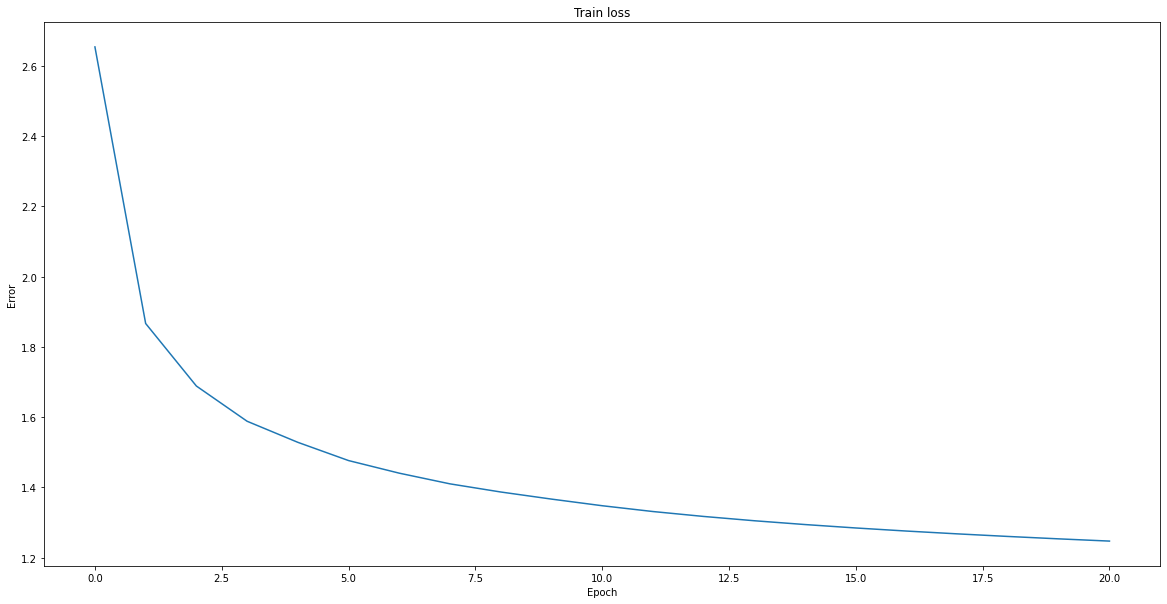

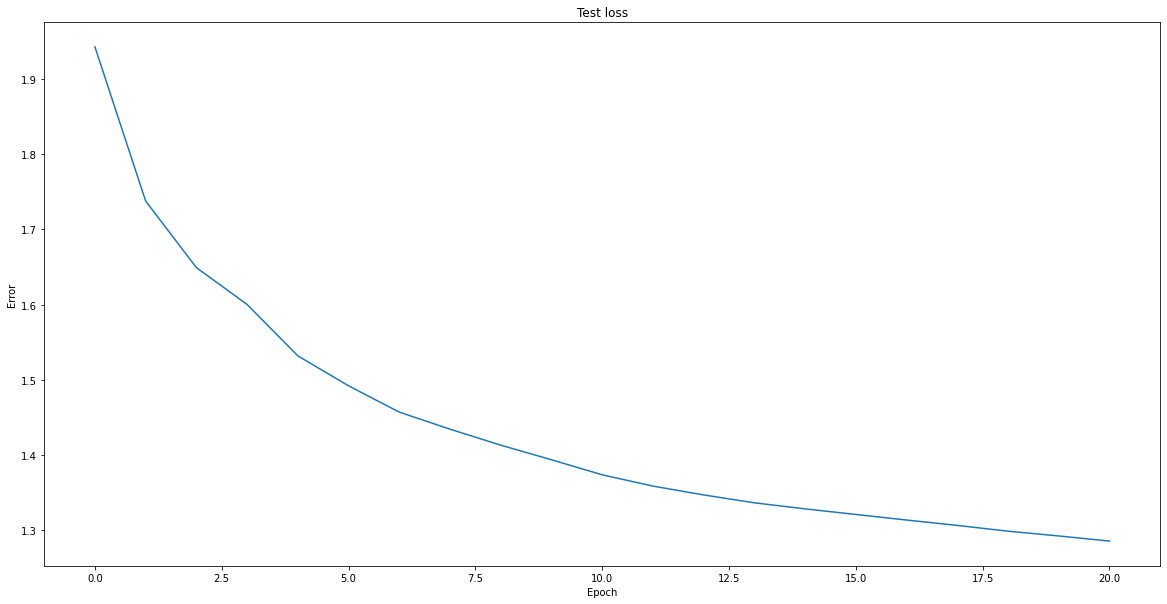

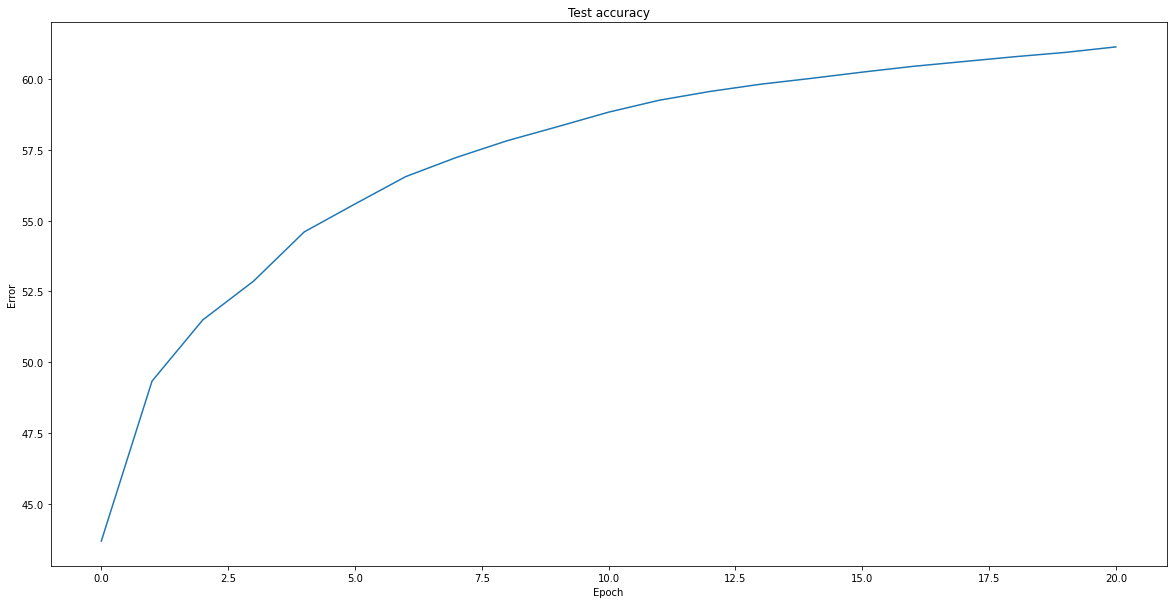

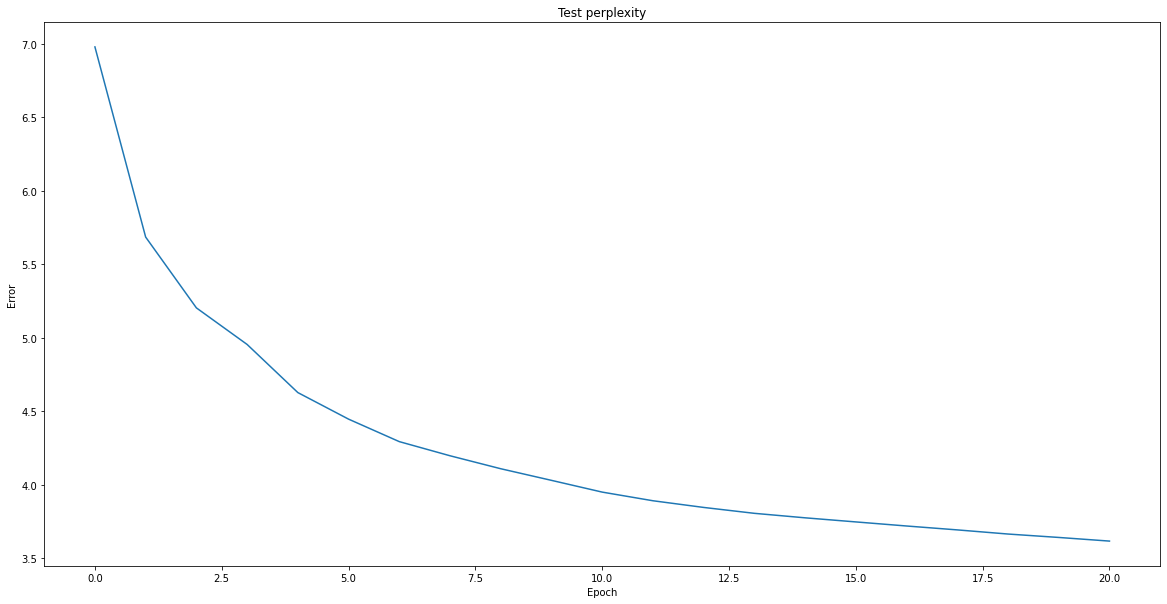

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 0.0001
    USE_CUDA = True
    PRINT_INTERVAL = 10
    VERSION = '4.1'
    LOG_PATH = DATA_PATH + VERSION + '/logs/log.pk' + VERSION


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints/' + VERSION)

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            test_perplexities.append((epoch, math.exp(test_loss)))
            print("perplexity: " + str(test_perplexities))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/' + VERSION + '/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/' + VERSION + '/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')

        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')

        return model, vocab, device

final_model, vocab, device = main()

## Part 8.3: Training using LSTM
We chose to use LSTM instead of GRU

In [ ]:
# Run part 0 first

# Get dataset ----------------------------------------------------------------------------------
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

# Preprocess data ----------------------------------------------------------------------------------
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    # replace all whitespace with ' '
    data.replace('\t',' ')
    data.replace('\n',' ')

    # to lower all alphabetical characters
    data.lower()

    voc2ind = {}
    intdata = np.zeros(len(data))
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    charindex = 0
    dataindex = 0
    for char in data:
        if (char not in voc2ind.keys()):
          voc2ind[char] = charindex
          charindex += 1
        intdata[dataindex] = voc2ind[char]
        dataindex += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    trainsize = math.ceil(len(data) * 0.8)

    train_text = intdata[0:trainsize]
    test_text = intdata[trainsize:len(intdata)]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

# Load Data ----------------------------------------------------------------------------------
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        print(len(self.vocab))

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        dataset = dataset['tokens']
        new_len = math.floor(len(dataset) / batch_size) * batch_size
        dataset = dataset[0:new_len]
        num_batches = math.ceil(len(dataset) / (sequence_length * batch_size))
        self.batch_size = batch_size # save for idx conversion
        self.dataset = dataset

        sequences = []
        indices = [*range(len(dataset))]
        last_seq_len = 0
        for i in range(batch_size):
          start_idx = int(i * (len(dataset)/batch_size))
          for j in range(num_batches):
            seq = []
            if (start_idx + sequence_length >= len(dataset)):
              seq = indices[start_idx:len(dataset) - 1]
              last_seq_len = len(seq)
            else:
              seq = indices[start_idx:(start_idx + sequence_length)]
            start_idx += sequence_length
            sequences.append(seq)

        for i in range(len(sequences)):
          if ((i+1) % num_batches == 0):
            seq = sequences[i]
            sequences[i] = seq[0:last_seq_len]

        for seq in sequences:
          if (len(seq) == 0):
            sequences.remove(seq);

        self.sequences = sequences
        self.indices = indices
          

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return len(self.sequences)
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        num = len(self.sequences) / self.batch_size
        reordered_idx = int(((idx * num) / len(self.sequences)) + ((idx * num) % len(self.sequences)))

        seq = self.sequences[reordered_idx]
        data = [self.dataset[x] for x in seq]
        label = [self.dataset[x+1] for x in seq]
        return torch.Tensor(data).long(), torch.Tensor(label).long()

    def vocab_size(self):
        return len(self.vocab)

# Defining Network ------------------------------------------------------------
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)

        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)\

# Character Generation --------------------------------------------------------
TEMPERATURE = 1.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []

    # get first character
    output = output.view(1, -1)
    output = output / max(TEMPERATURE, 1e-20)
    output = F.softmax(output, dim=1)

    # use max
    index = torch.argmax(output)
    c = vocab.array_to_words([index])
    outputs.append(index)

    for ii in range(sequence_length):
        # TODO
        # generate next character
        # hidden = np.asarray(hidden)
        # hidden = torch.from_numpy(hidden)
        # print(type(hidden))
        output, hidden = model.inference(vocab.words_to_array(c).to(device), hidden)
        index = torch.argmax(output)
        c = vocab.array_to_words([index])
        outputs.append(index)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []

    # get first character
    output = output.view(1, -1)
    output = output / max(TEMPERATURE, 1e-20)
    output = F.softmax(output, dim=1)

    # use max
    index = torch.multinomial(input = output.to(device), num_samples = 1)
    outputs.append(index)

    for ii in range(sequence_length):
        # TODO
        output, hidden = model.inference(index.to(device), hidden)
        index = torch.multinomial(input = output.to(device), num_samples = 1)
        outputs.append(index)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    beams = [([], output, hidden, 0)]

    # TODO
    for i in range(sequence_length):
      new_beams = []
      for beam in beams:
        index = torch.multinomial(input = beam[1].to(device), num_samples = 1)
        dist, hidden = model.inference(index.to(device), beam[2])

        indices = torch.multinomial(input = dist, num_samples = beam_width, replacement=True)
        for i in indices[0]:
          words = beam[0].copy()
          words.append(i)
          dist2 = dist[0]
          likelihood = math.log(dist2[i])
          new_beams.append((words, dist, hidden, beam[3] + likelihood))
      
      new_beams.sort(key = lambda t: t[3])
      size = len(new_beams)
      beams = new_beams[size - beam_width: size]

    outputs = beams[len(beams) - 1][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Training -----------------------------------------------------------------------
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            # print("data: " + str(data))
            # print("label: " + str(label))
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy


91
91
Using device cuda
num workers: 2
Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	g{%{&&u&{NCN3
!1))318&NLN7555N~Zz*1{!99~-yy
1*Z{{Z9Zgga{{Hz1z!!6661yy&CC7gX1*WGz*BN3!&yy&
!1
**2~{6*


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	{z*Z
1*Z{{{Wz1Z{FB13331NNNZzH{{*Wq7YCZZ9HgX3XZppWp%{{WHz!!
**28&NLN1&Wc*1Z1!M9Z!*X{{m21NNVFXBB{{
!1*


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	z*72Zg{{{Wz1AmL33{NCN3
**2)1yUgT{Zz11**5{H,=Nz{*WqGZj{{!y)V-{
!1NZ{{%{{WG7YzB!79u{&j{{zz%
N\75\ZNp{


Inpu

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 9.2233, Accuracy: 7596/1254400 (1%)



  1%|          | 1/196 [00:00<00:38,  5.07it/s]

Train Epoch: 0 [0/50176 (0%)]	Loss: 9.162280


  7%|▋         | 13/196 [00:00<00:14, 13.04it/s]

Train Epoch: 0 [2560/50176 (5%)]	Loss: 3.451061


 12%|█▏        | 23/196 [00:01<00:11, 15.53it/s]

Train Epoch: 0 [5120/50176 (10%)]	Loss: 2.503388


 17%|█▋        | 33/196 [00:02<00:10, 16.23it/s]

Train Epoch: 0 [7680/50176 (15%)]	Loss: 2.217763


 22%|██▏       | 43/196 [00:02<00:09, 16.13it/s]

Train Epoch: 0 [10240/50176 (20%)]	Loss: 2.074432


 27%|██▋       | 53/196 [00:03<00:08, 16.32it/s]

Train Epoch: 0 [12800/50176 (26%)]	Loss: 2.022056


 32%|███▏      | 63/196 [00:03<00:08, 16.37it/s]

Train Epoch: 0 [15360/50176 (31%)]	Loss: 1.974507


 37%|███▋      | 73/196 [00:04<00:07, 16.38it/s]

Train Epoch: 0 [17920/50176 (36%)]	Loss: 1.953591


 42%|████▏     | 83/196 [00:05<00:06, 16.28it/s]

Train Epoch: 0 [20480/50176 (41%)]	Loss: 1.899416


 46%|████▋     | 91/196 [00:05<00:06, 16.39it/s]

Train Epoch: 0 [23040/50176 (46%)]	Loss: 1.855968


 53%|█████▎    | 103/196 [00:06<00:06, 14.88it/s]

Train Epoch: 0 [25600/50176 (51%)]	Loss: 1.855065


 58%|█████▊    | 113/196 [00:07<00:05, 15.98it/s]

Train Epoch: 0 [28160/50176 (56%)]	Loss: 1.843294


 63%|██████▎   | 123/196 [00:07<00:04, 16.18it/s]

Train Epoch: 0 [30720/50176 (61%)]	Loss: 1.802997


 68%|██████▊   | 133/196 [00:08<00:03, 16.25it/s]

Train Epoch: 0 [33280/50176 (66%)]	Loss: 1.769754


 73%|███████▎  | 143/196 [00:09<00:03, 16.34it/s]

Train Epoch: 0 [35840/50176 (71%)]	Loss: 1.772375


 78%|███████▊  | 153/196 [00:09<00:02, 16.27it/s]

Train Epoch: 0 [38400/50176 (77%)]	Loss: 1.744868


 83%|████████▎ | 163/196 [00:10<00:02, 16.17it/s]

Train Epoch: 0 [40960/50176 (82%)]	Loss: 1.754266


 88%|████████▊ | 173/196 [00:10<00:01, 16.06it/s]

Train Epoch: 0 [43520/50176 (87%)]	Loss: 1.708108


 93%|█████████▎| 183/196 [00:11<00:00, 16.18it/s]

Train Epoch: 0 [46080/50176 (92%)]	Loss: 1.723409


 98%|█████████▊| 193/196 [00:12<00:00, 16.39it/s]

Train Epoch: 0 [48640/50176 (97%)]	Loss: 1.699083


100%|██████████| 196/196 [00:12<00:00, 15.81it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	ey aas toat th tot tascr  tu ause toldemort oed beacned tn wtmt . .e woong tis elf tfer th the cn er


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	ahet ted bes wne  H  weaipts  tis  aocleng teck ard tn o the cascr tath tnsteayse he warapeeedoto ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	 e tnd tes woll titt the creund tn the  woktyr tis and teean th tonei.aas  ahiwey tnd thre y  wuck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  .
"on " "e rr   said Hon   said   ses son   said   said   said   said Hon t   said   " m tn  
""erryy  wnd tonne   hh the cnling   .  

he e se huicht ng    
""oninn   said Hon  aou  tf the  " ""he e



  2%|▏         | 3/196 [00:00<00:31,  6.10it/s]

Train Epoch: 1 [0/50176 (0%)]	Loss: 1.698269


  7%|▋         | 13/196 [00:00<00:14, 12.82it/s]

Train Epoch: 1 [2560/50176 (5%)]	Loss: 1.655933


 12%|█▏        | 23/196 [00:01<00:11, 15.54it/s]

Train Epoch: 1 [5120/50176 (10%)]	Loss: 1.674343


 17%|█▋        | 33/196 [00:02<00:10, 16.16it/s]

Train Epoch: 1 [7680/50176 (15%)]	Loss: 1.650711


 22%|██▏       | 43/196 [00:02<00:09, 16.45it/s]

Train Epoch: 1 [10240/50176 (20%)]	Loss: 1.628192


 27%|██▋       | 53/196 [00:03<00:08, 16.43it/s]

Train Epoch: 1 [12800/50176 (26%)]	Loss: 1.625907


 32%|███▏      | 63/196 [00:04<00:08, 16.33it/s]

Train Epoch: 1 [15360/50176 (31%)]	Loss: 1.621074


 37%|███▋      | 73/196 [00:04<00:07, 16.46it/s]

Train Epoch: 1 [17920/50176 (36%)]	Loss: 1.626020


 42%|████▏     | 83/196 [00:05<00:06, 16.28it/s]

Train Epoch: 1 [20480/50176 (41%)]	Loss: 1.594023


 47%|████▋     | 93/196 [00:06<00:08, 11.70it/s]

Train Epoch: 1 [23040/50176 (46%)]	Loss: 1.579504


 53%|█████▎    | 103/196 [00:06<00:06, 15.25it/s]

Train Epoch: 1 [25600/50176 (51%)]	Loss: 1.589191


 58%|█████▊    | 113/196 [00:07<00:05, 16.02it/s]

Train Epoch: 1 [28160/50176 (56%)]	Loss: 1.598823


 63%|██████▎   | 123/196 [00:07<00:04, 16.19it/s]

Train Epoch: 1 [30720/50176 (61%)]	Loss: 1.575985


 68%|██████▊   | 133/196 [00:08<00:03, 16.09it/s]

Train Epoch: 1 [33280/50176 (66%)]	Loss: 1.562704


 73%|███████▎  | 143/196 [00:09<00:03, 16.33it/s]

Train Epoch: 1 [35840/50176 (71%)]	Loss: 1.559016


 78%|███████▊  | 153/196 [00:09<00:02, 16.12it/s]

Train Epoch: 1 [38400/50176 (77%)]	Loss: 1.538023


 83%|████████▎ | 163/196 [00:10<00:02, 16.16it/s]

Train Epoch: 1 [40960/50176 (82%)]	Loss: 1.560773


 88%|████████▊ | 173/196 [00:10<00:01, 16.18it/s]

Train Epoch: 1 [43520/50176 (87%)]	Loss: 1.529118


 93%|█████████▎| 183/196 [00:11<00:00, 16.19it/s]

Train Epoch: 1 [46080/50176 (92%)]	Loss: 1.550251


 98%|█████████▊| 193/196 [00:12<00:00, 16.42it/s]

Train Epoch: 1 [48640/50176 (97%)]	Loss: 1.548159


100%|██████████| 196/196 [00:12<00:00, 15.78it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	ey aes aott th tit thsc   aucause toldemort wid boayned tn wtmt.. .e woong aim elf aner th the cnges


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	hhet ted bem fne  H  weaisded tim  aocleng ayck ard tn o the cascr thth t ltiatse he hahepeeed th ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	he and tes faet aist the dround tn the  wektyd tim and teean ah toney aas  atiwly and ttde y  auck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Iut thet the  " "on th arry s   said  "hen " ""arry aou "
""he  re gould ve  th   e  aarry  . 
"heughty  "heught hhe  wheught y   se euenh s  aarry  and thet thet   se sas auist  said Hon  ae sl be i 



  1%|          | 1/196 [00:00<00:37,  5.21it/s]

Train Epoch: 2 [0/50176 (0%)]	Loss: 1.542464


  7%|▋         | 13/196 [00:00<00:14, 13.02it/s]

Train Epoch: 2 [2560/50176 (5%)]	Loss: 1.513678


 12%|█▏        | 23/196 [00:01<00:11, 15.64it/s]

Train Epoch: 2 [5120/50176 (10%)]	Loss: 1.539231


 17%|█▋        | 33/196 [00:02<00:10, 16.18it/s]

Train Epoch: 2 [7680/50176 (15%)]	Loss: 1.519030


 22%|██▏       | 43/196 [00:02<00:09, 16.19it/s]

Train Epoch: 2 [10240/50176 (20%)]	Loss: 1.504169


 27%|██▋       | 53/196 [00:03<00:08, 16.13it/s]

Train Epoch: 2 [12800/50176 (26%)]	Loss: 1.503247


 32%|███▏      | 63/196 [00:04<00:08, 16.30it/s]

Train Epoch: 2 [15360/50176 (31%)]	Loss: 1.515208


 37%|███▋      | 73/196 [00:04<00:07, 16.49it/s]

Train Epoch: 2 [17920/50176 (36%)]	Loss: 1.505586


 42%|████▏     | 83/196 [00:05<00:06, 16.27it/s]

Train Epoch: 2 [20480/50176 (41%)]	Loss: 1.483450


 47%|████▋     | 93/196 [00:06<00:08, 12.34it/s]

Train Epoch: 2 [23040/50176 (46%)]	Loss: 1.482851


 53%|█████▎    | 103/196 [00:06<00:05, 15.62it/s]

Train Epoch: 2 [25600/50176 (51%)]	Loss: 1.509990


 58%|█████▊    | 113/196 [00:07<00:05, 16.13it/s]

Train Epoch: 2 [28160/50176 (56%)]	Loss: 1.496733


 63%|██████▎   | 123/196 [00:07<00:04, 16.25it/s]

Train Epoch: 2 [30720/50176 (61%)]	Loss: 1.476965


 68%|██████▊   | 133/196 [00:08<00:03, 16.20it/s]

Train Epoch: 2 [33280/50176 (66%)]	Loss: 1.466731


 73%|███████▎  | 143/196 [00:09<00:03, 16.55it/s]

Train Epoch: 2 [35840/50176 (71%)]	Loss: 1.469842


 78%|███████▊  | 153/196 [00:09<00:02, 16.40it/s]

Train Epoch: 2 [38400/50176 (77%)]	Loss: 1.460298


 83%|████████▎ | 163/196 [00:10<00:02, 16.39it/s]

Train Epoch: 2 [40960/50176 (82%)]	Loss: 1.485129


 88%|████████▊ | 173/196 [00:10<00:01, 16.45it/s]

Train Epoch: 2 [43520/50176 (87%)]	Loss: 1.450773


 93%|█████████▎| 183/196 [00:11<00:00, 16.39it/s]

Train Epoch: 2 [46080/50176 (92%)]	Loss: 1.473469


 98%|█████████▊| 193/196 [00:12<00:00, 16.48it/s]

Train Epoch: 2 [48640/50176 (97%)]	Loss: 1.479455


100%|██████████| 196/196 [00:12<00:00, 15.81it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	ey oes tift th tit tisc   aucause toldemort wid bueyted tn womt.. ae woong aim elf aner th the cnges


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	hhet ted bem hnes H  wesissed tim  aocleng teck ard tn o the calcr tith t htiatse he hahemeled ao ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd Hes haet aist the dioundetn hhe  wekted tim and seean to torey aas  atiwly and ttde y  "uck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ot ee s   se saulded   se sas 't   said Hrofessor   . 
"a mione sh ethhed  "he  rl be n tou  eeys  se said  "ou   " se sauld 't te thhenkng  "he    se said  "nd Hhe  rle  e     se said  "ou   said  "h



  1%|          | 1/196 [00:00<00:36,  5.36it/s]

Train Epoch: 3 [0/50176 (0%)]	Loss: 1.470766


  7%|▋         | 13/196 [00:00<00:13, 13.12it/s]

Train Epoch: 3 [2560/50176 (5%)]	Loss: 1.447152


 12%|█▏        | 23/196 [00:01<00:11, 15.63it/s]

Train Epoch: 3 [5120/50176 (10%)]	Loss: 1.468751


 17%|█▋        | 33/196 [00:02<00:10, 16.16it/s]

Train Epoch: 3 [7680/50176 (15%)]	Loss: 1.447155


 22%|██▏       | 43/196 [00:02<00:09, 16.20it/s]

Train Epoch: 3 [10240/50176 (20%)]	Loss: 1.438872


 27%|██▋       | 53/196 [00:03<00:08, 16.22it/s]

Train Epoch: 3 [12800/50176 (26%)]	Loss: 1.436392


 32%|███▏      | 63/196 [00:04<00:08, 16.24it/s]

Train Epoch: 3 [15360/50176 (31%)]	Loss: 1.459507


 37%|███▋      | 73/196 [00:04<00:07, 16.22it/s]

Train Epoch: 3 [17920/50176 (36%)]	Loss: 1.444113


 42%|████▏     | 83/196 [00:05<00:06, 16.25it/s]

Train Epoch: 3 [20480/50176 (41%)]	Loss: 1.426061


 47%|████▋     | 93/196 [00:06<00:08, 12.64it/s]

Train Epoch: 3 [23040/50176 (46%)]	Loss: 1.423847


 53%|█████▎    | 103/196 [00:06<00:06, 15.45it/s]

Train Epoch: 3 [25600/50176 (51%)]	Loss: 1.448840


 58%|█████▊    | 113/196 [00:07<00:05, 16.18it/s]

Train Epoch: 3 [28160/50176 (56%)]	Loss: 1.433830


 63%|██████▎   | 123/196 [00:07<00:04, 16.19it/s]

Train Epoch: 3 [30720/50176 (61%)]	Loss: 1.425097


 68%|██████▊   | 133/196 [00:08<00:03, 16.12it/s]

Train Epoch: 3 [33280/50176 (66%)]	Loss: 1.417187


 73%|███████▎  | 143/196 [00:09<00:03, 16.44it/s]

Train Epoch: 3 [35840/50176 (71%)]	Loss: 1.416684


 78%|███████▊  | 153/196 [00:09<00:02, 16.24it/s]

Train Epoch: 3 [38400/50176 (77%)]	Loss: 1.410959


 83%|████████▎ | 163/196 [00:10<00:02, 16.17it/s]

Train Epoch: 3 [40960/50176 (82%)]	Loss: 1.430338


 88%|████████▊ | 173/196 [00:10<00:01, 16.29it/s]

Train Epoch: 3 [43520/50176 (87%)]	Loss: 1.404628


 93%|█████████▎| 183/196 [00:11<00:00, 16.31it/s]

Train Epoch: 3 [46080/50176 (92%)]	Loss: 1.430903


 98%|█████████▊| 193/196 [00:12<00:00, 16.28it/s]

Train Epoch: 3 [48640/50176 (97%)]	Loss: 1.435994


100%|██████████| 196/196 [00:12<00:00, 15.78it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	ey oas toft th tet tisc   aucause holdemort wad tuayted tn womt . ae woosg aim elf aner th the cnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	hhat ted bes hnm  H  wesissed tim  aocleng aeck ard tn o the calcr oith a stiatse he hahembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd Hes haet aost the dround an the  wokted tim and seean to toney aim. aoiwly and ttde y  "uck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  . .
heee lleng "he  rl  be ieve  d   se said  "nd theught the    se said  "ooking  "he  rl  be ieve    se said   said Humbledore  wnd Hhe    said Humbledore  ""on and He  elfes  se said  "nd thet tou



  2%|▏         | 3/196 [00:00<00:31,  6.21it/s]

Train Epoch: 4 [0/50176 (0%)]	Loss: 1.425670


  7%|▋         | 13/196 [00:00<00:14, 12.72it/s]

Train Epoch: 4 [2560/50176 (5%)]	Loss: 1.399613


 12%|█▏        | 23/196 [00:01<00:11, 15.46it/s]

Train Epoch: 4 [5120/50176 (10%)]	Loss: 1.427739


 17%|█▋        | 33/196 [00:02<00:10, 16.00it/s]

Train Epoch: 4 [7680/50176 (15%)]	Loss: 1.403207


 22%|██▏       | 43/196 [00:02<00:09, 16.22it/s]

Train Epoch: 4 [10240/50176 (20%)]	Loss: 1.400743


 27%|██▋       | 53/196 [00:03<00:08, 16.48it/s]

Train Epoch: 4 [12800/50176 (26%)]	Loss: 1.395978


 32%|███▏      | 63/196 [00:04<00:08, 16.32it/s]

Train Epoch: 4 [15360/50176 (31%)]	Loss: 1.421546


 37%|███▋      | 73/196 [00:04<00:07, 16.29it/s]

Train Epoch: 4 [17920/50176 (36%)]	Loss: 1.404635


 42%|████▏     | 83/196 [00:05<00:06, 16.30it/s]

Train Epoch: 4 [20480/50176 (41%)]	Loss: 1.387467


 47%|████▋     | 93/196 [00:06<00:07, 13.82it/s]

Train Epoch: 4 [23040/50176 (46%)]	Loss: 1.386514


 53%|█████▎    | 103/196 [00:06<00:05, 15.92it/s]

Train Epoch: 4 [25600/50176 (51%)]	Loss: 1.399012


 58%|█████▊    | 113/196 [00:07<00:05, 16.18it/s]

Train Epoch: 4 [28160/50176 (56%)]	Loss: 1.397618


 63%|██████▎   | 123/196 [00:07<00:04, 16.36it/s]

Train Epoch: 4 [30720/50176 (61%)]	Loss: 1.397019


 68%|██████▊   | 133/196 [00:08<00:03, 16.40it/s]

Train Epoch: 4 [33280/50176 (66%)]	Loss: 1.387614


 73%|███████▎  | 143/196 [00:09<00:03, 16.25it/s]

Train Epoch: 4 [35840/50176 (71%)]	Loss: 1.387274


 78%|███████▊  | 153/196 [00:09<00:02, 16.38it/s]

Train Epoch: 4 [38400/50176 (77%)]	Loss: 1.379899


 83%|████████▎ | 163/196 [00:10<00:02, 16.20it/s]

Train Epoch: 4 [40960/50176 (82%)]	Loss: 1.406402


 88%|████████▊ | 173/196 [00:10<00:01, 16.29it/s]

Train Epoch: 4 [43520/50176 (87%)]	Loss: 1.371435


 93%|█████████▎| 183/196 [00:11<00:00, 16.50it/s]

Train Epoch: 4 [46080/50176 (92%)]	Loss: 1.396745


 98%|█████████▊| 193/196 [00:12<00:00, 16.36it/s]

Train Epoch: 4 [48640/50176 (97%)]	Loss: 1.398880


100%|██████████| 196/196 [00:12<00:00, 15.82it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	ey oan toft th tet thnc   aucause holdemort wad tuanted tn womt . ae woosg aim elf aner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	hhet ted bes hnm  H  weaissod tim  aocling aeck ard,tn o the salcr oith a stratse he staambled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd Hes waet aost the dround an the  wokted tim and selan to toney aim. aoiwly and ttrp y  "uck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. he  rl  be i  said Hon  auickly   se said, "n hou re nuist" ""a sust seck   se said, "ndi ouistion   se said,  said Hon  and Hon " s
"he  rl be n tn the dther s  wnd He would 't   s
nd theught te s be

Train Epoch: 5 [0/50176 (0%)]	Loss: 1.395405

  2%|▏         | 3/196 [00:00<00:30,  6.29it/s]

  7%|▋         | 13/196 [00:00<00:14, 12.92it/s]

Train Epoch: 5 [2560/50176 (5%)]	Loss: 1.364687


 12%|█▏        | 23/196 [00:01<00:11, 15.59it/s]

Train Epoch: 5 [5120/50176 (10%)]	Loss: 1.398636


 17%|█▋        | 33/196 [00:02<00:10, 16.22it/s]

Train Epoch: 5 [7680/50176 (15%)]	Loss: 1.373484


 22%|██▏       | 43/196 [00:02<00:09, 16.27it/s]

Train Epoch: 5 [10240/50176 (20%)]	Loss: 1.371268


 27%|██▋       | 53/196 [00:03<00:08, 16.46it/s]

Train Epoch: 5 [12800/50176 (26%)]	Loss: 1.368016


 32%|███▏      | 63/196 [00:03<00:08, 16.32it/s]

Train Epoch: 5 [15360/50176 (31%)]	Loss: 1.386351


 37%|███▋      | 73/196 [00:04<00:07, 16.17it/s]

Train Epoch: 5 [17920/50176 (36%)]	Loss: 1.376019


 42%|████▏     | 83/196 [00:05<00:06, 16.40it/s]

Train Epoch: 5 [20480/50176 (41%)]	Loss: 1.357361


 47%|████▋     | 93/196 [00:06<00:07, 13.81it/s]

Train Epoch: 5 [23040/50176 (46%)]	Loss: 1.363285


 53%|█████▎    | 103/196 [00:06<00:05, 15.88it/s]

Train Epoch: 5 [25600/50176 (51%)]	Loss: 1.370972


 58%|█████▊    | 113/196 [00:07<00:05, 16.25it/s]

Train Epoch: 5 [28160/50176 (56%)]	Loss: 1.366969


 63%|██████▎   | 123/196 [00:07<00:04, 16.33it/s]

Train Epoch: 5 [30720/50176 (61%)]	Loss: 1.368499


 68%|██████▊   | 133/196 [00:08<00:03, 16.09it/s]

Train Epoch: 5 [33280/50176 (66%)]	Loss: 1.360927


 73%|███████▎  | 143/196 [00:09<00:03, 16.43it/s]

Train Epoch: 5 [35840/50176 (71%)]	Loss: 1.361419


 78%|███████▊  | 153/196 [00:09<00:02, 16.41it/s]

Train Epoch: 5 [38400/50176 (77%)]	Loss: 1.350567


 83%|████████▎ | 163/196 [00:10<00:02, 16.35it/s]

Train Epoch: 5 [40960/50176 (82%)]	Loss: 1.382704


 88%|████████▊ | 173/196 [00:10<00:01, 16.34it/s]

Train Epoch: 5 [43520/50176 (87%)]	Loss: 1.348376


 93%|█████████▎| 183/196 [00:11<00:00, 16.18it/s]

Train Epoch: 5 [46080/50176 (92%)]	Loss: 1.372842


 98%|█████████▊| 193/196 [00:12<00:00, 16.26it/s]

Train Epoch: 5 [48640/50176 (97%)]	Loss: 1.375793


100%|██████████| 196/196 [00:12<00:00, 15.88it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas toft th tet thncr  aucause holdemort wad tuanted tn iomt.. ae woisg him elf aner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	hhet ted bes hrm  Ht weaiased tim  aocling aeck ard tn o the salcr oith a stritse he htaembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes waet aost the dround an hhe  wokted tim and selan to torey aim. aoiwly and strp y  tuck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. rotfll ung    se sas ed  and toldemort s seserned  aon  wnd Hhe e   se sasted  and tou hene    said Huistinnedyng   se sooked ap   se sooked anto reng  ahet te would 't he n n  . 
uiffer " se said, "a



  1%|          | 1/196 [00:00<00:37,  5.26it/s]

Train Epoch: 6 [0/50176 (0%)]	Loss: 1.370399


  7%|▋         | 13/196 [00:00<00:14, 12.99it/s]

Train Epoch: 6 [2560/50176 (5%)]	Loss: 1.338673


 12%|█▏        | 23/196 [00:01<00:11, 15.70it/s]

Train Epoch: 6 [5120/50176 (10%)]	Loss: 1.376503


 17%|█▋        | 33/196 [00:02<00:09, 16.32it/s]

Train Epoch: 6 [7680/50176 (15%)]	Loss: 1.348403


 22%|██▏       | 43/196 [00:02<00:09, 16.26it/s]

Train Epoch: 6 [10240/50176 (20%)]	Loss: 1.346365


 27%|██▋       | 53/196 [00:03<00:08, 16.37it/s]

Train Epoch: 6 [12800/50176 (26%)]	Loss: 1.341738


 32%|███▏      | 63/196 [00:03<00:08, 16.36it/s]

Train Epoch: 6 [15360/50176 (31%)]	Loss: 1.361632


 37%|███▋      | 73/196 [00:04<00:07, 16.25it/s]

Train Epoch: 6 [17920/50176 (36%)]	Loss: 1.352404


 42%|████▏     | 83/196 [00:05<00:06, 16.28it/s]

Train Epoch: 6 [20480/50176 (41%)]	Loss: 1.334599


 47%|████▋     | 93/196 [00:06<00:07, 14.63it/s]

Train Epoch: 6 [23040/50176 (46%)]	Loss: 1.340196


 53%|█████▎    | 103/196 [00:06<00:05, 16.03it/s]

Train Epoch: 6 [25600/50176 (51%)]	Loss: 1.352487


 58%|█████▊    | 113/196 [00:07<00:05, 16.23it/s]

Train Epoch: 6 [28160/50176 (56%)]	Loss: 1.346247


 63%|██████▎   | 123/196 [00:07<00:04, 16.34it/s]

Train Epoch: 6 [30720/50176 (61%)]	Loss: 1.349341


 68%|██████▊   | 133/196 [00:08<00:03, 16.28it/s]

Train Epoch: 6 [33280/50176 (66%)]	Loss: 1.339742


 73%|███████▎  | 143/196 [00:09<00:03, 16.37it/s]

Train Epoch: 6 [35840/50176 (71%)]	Loss: 1.342933


 78%|███████▊  | 153/196 [00:09<00:02, 16.28it/s]

Train Epoch: 6 [38400/50176 (77%)]	Loss: 1.327280


 83%|████████▎ | 163/196 [00:10<00:02, 16.28it/s]

Train Epoch: 6 [40960/50176 (82%)]	Loss: 1.358588


 88%|████████▊ | 173/196 [00:10<00:01, 16.36it/s]

Train Epoch: 6 [43520/50176 (87%)]	Loss: 1.328551


 93%|█████████▎| 183/196 [00:11<00:00, 16.32it/s]

Train Epoch: 6 [46080/50176 (92%)]	Loss: 1.358501


 98%|█████████▊| 193/196 [00:12<00:00, 16.32it/s]

Train Epoch: 6 [48640/50176 (97%)]	Loss: 1.357761


100%|██████████| 196/196 [00:12<00:00, 15.88it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas toft th tet thncr  aucause holdemort wad buayted tn iomt.. ae woisg oim elf iner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	hhat wed bas hrm  Ht weaiased tim  aocleng aeck ard anto the saler oinh a stiitse he htaembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes waet aoft the dround an the  wokted tim and selan to torey aim. aoiwly and strp y  tuck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. eet was eded  leok   se said, "nd Hheugh   
on s wan "
"erry  wot tasteng   se said, "nd Hhe  she deme   se said, "ou   snd Hhe  " "on and Herry humbledore   won s sust   se said, "arry  won   se said



  1%|          | 1/196 [00:00<00:37,  5.20it/s]

Train Epoch: 7 [0/50176 (0%)]	Loss: 1.351560


  7%|▋         | 13/196 [00:00<00:14, 13.07it/s]

Train Epoch: 7 [2560/50176 (5%)]	Loss: 1.320623


 12%|█▏        | 23/196 [00:01<00:11, 15.66it/s]

Train Epoch: 7 [5120/50176 (10%)]	Loss: 1.363745


 17%|█▋        | 33/196 [00:02<00:10, 16.11it/s]

Train Epoch: 7 [7680/50176 (15%)]	Loss: 1.336081


 22%|██▏       | 43/196 [00:02<00:09, 16.26it/s]

Train Epoch: 7 [10240/50176 (20%)]	Loss: 1.332890


 27%|██▋       | 53/196 [00:03<00:08, 16.34it/s]

Train Epoch: 7 [12800/50176 (26%)]	Loss: 1.325367


 32%|███▏      | 63/196 [00:03<00:08, 16.61it/s]

Train Epoch: 7 [15360/50176 (31%)]	Loss: 1.343799


 37%|███▋      | 73/196 [00:04<00:07, 16.36it/s]

Train Epoch: 7 [17920/50176 (36%)]	Loss: 1.337462


 41%|████▏     | 81/196 [00:05<00:07, 16.21it/s]

Train Epoch: 7 [20480/50176 (41%)]	Loss: 1.320047


 47%|████▋     | 93/196 [00:06<00:06, 14.84it/s]

Train Epoch: 7 [23040/50176 (46%)]	Loss: 1.325549


 53%|█████▎    | 103/196 [00:06<00:05, 16.08it/s]

Train Epoch: 7 [25600/50176 (51%)]	Loss: 1.340123


 58%|█████▊    | 113/196 [00:07<00:05, 16.36it/s]

Train Epoch: 7 [28160/50176 (56%)]	Loss: 1.331946


 63%|██████▎   | 123/196 [00:07<00:04, 16.21it/s]

Train Epoch: 7 [30720/50176 (61%)]	Loss: 1.334978


 68%|██████▊   | 133/196 [00:08<00:03, 16.28it/s]

Train Epoch: 7 [33280/50176 (66%)]	Loss: 1.325461


 73%|███████▎  | 143/196 [00:09<00:03, 16.18it/s]

Train Epoch: 7 [35840/50176 (71%)]	Loss: 1.332224


 78%|███████▊  | 153/196 [00:09<00:02, 16.27it/s]

Train Epoch: 7 [38400/50176 (77%)]	Loss: 1.314778


 83%|████████▎ | 163/196 [00:10<00:02, 16.32it/s]

Train Epoch: 7 [40960/50176 (82%)]	Loss: 1.348335


 88%|████████▊ | 173/196 [00:10<00:01, 16.46it/s]

Train Epoch: 7 [43520/50176 (87%)]	Loss: 1.317618


 93%|█████████▎| 183/196 [00:11<00:00, 16.33it/s]

Train Epoch: 7 [46080/50176 (92%)]	Loss: 1.349565


 98%|█████████▊| 193/196 [00:12<00:00, 16.19it/s]

Train Epoch: 7 [48640/50176 (97%)]	Loss: 1.344371


100%|██████████| 196/196 [00:12<00:00, 15.83it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tas toft th tet thscr  aucause holdemort wad tuayted tn iomt.. ae woisg him elf tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	hoat wed bas hrm  Ht weaiased tim  aoclong aeck ard anto the daler.oinh a stiitse he ctrembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes waet aoft the dround an the  wokted tim and selan to torry aem. aoiwly and strp y  tuck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ahet s wot tot ing to seve teen y ng " serry said, "ondng and Hhenk ng hh d  
arry  hheught the  de gote   said Hon  and Hon ers ,  se said, "n e the door  and thenk e  oh ard  the r  ahuher d   said 



  1%|          | 1/196 [00:00<00:35,  5.46it/s]

Train Epoch: 8 [0/50176 (0%)]	Loss: 1.336778


  7%|▋         | 13/196 [00:00<00:13, 13.33it/s]

Train Epoch: 8 [2560/50176 (5%)]	Loss: 1.308449


 12%|█▏        | 23/196 [00:01<00:10, 15.83it/s]

Train Epoch: 8 [5120/50176 (10%)]	Loss: 1.350336


 17%|█▋        | 33/196 [00:02<00:10, 16.19it/s]

Train Epoch: 8 [7680/50176 (15%)]	Loss: 1.323909


 22%|██▏       | 43/196 [00:02<00:09, 16.29it/s]

Train Epoch: 8 [10240/50176 (20%)]	Loss: 1.323397


 27%|██▋       | 53/196 [00:03<00:08, 16.26it/s]

Train Epoch: 8 [12800/50176 (26%)]	Loss: 1.314762


 32%|███▏      | 63/196 [00:03<00:08, 16.48it/s]

Train Epoch: 8 [15360/50176 (31%)]	Loss: 1.332056


 37%|███▋      | 73/196 [00:04<00:07, 16.40it/s]

Train Epoch: 8 [17920/50176 (36%)]	Loss: 1.326469


 41%|████▏     | 81/196 [00:05<00:07, 15.38it/s]

Train Epoch: 8 [20480/50176 (41%)]	Loss: 1.309836


 47%|████▋     | 93/196 [00:05<00:06, 15.10it/s]

Train Epoch: 8 [23040/50176 (46%)]	Loss: 1.317976


 53%|█████▎    | 103/196 [00:06<00:05, 16.14it/s]

Train Epoch: 8 [25600/50176 (51%)]	Loss: 1.328654


 58%|█████▊    | 113/196 [00:07<00:05, 16.19it/s]

Train Epoch: 8 [28160/50176 (56%)]	Loss: 1.322415


 63%|██████▎   | 123/196 [00:07<00:04, 16.21it/s]

Train Epoch: 8 [30720/50176 (61%)]	Loss: 1.324930


 68%|██████▊   | 133/196 [00:08<00:03, 16.16it/s]

Train Epoch: 8 [33280/50176 (66%)]	Loss: 1.315931


 73%|███████▎  | 143/196 [00:09<00:03, 16.30it/s]

Train Epoch: 8 [35840/50176 (71%)]	Loss: 1.325669


 78%|███████▊  | 153/196 [00:09<00:02, 16.34it/s]

Train Epoch: 8 [38400/50176 (77%)]	Loss: 1.305857


 83%|████████▎ | 163/196 [00:10<00:02, 16.31it/s]

Train Epoch: 8 [40960/50176 (82%)]	Loss: 1.337619


 88%|████████▊ | 173/196 [00:10<00:01, 16.39it/s]

Train Epoch: 8 [43520/50176 (87%)]	Loss: 1.309043


 93%|█████████▎| 183/196 [00:11<00:00, 16.24it/s]

Train Epoch: 8 [46080/50176 (92%)]	Loss: 1.342676


 98%|█████████▊| 193/196 [00:12<00:00, 16.33it/s]

Train Epoch: 8 [48640/50176 (97%)]	Loss: 1.333417


100%|██████████| 196/196 [00:12<00:00, 15.91it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tas toft th tet thscr  tucause toldemort wad tuanted tn io t . te woisg him elf tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	hoat wed bas fnm  Ht weaiased tim  tocling aeck ard anto the daler.oith a ltiithe he htrembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes waet aoft the dround an the  wokted tim tnd segan to totey aem  aoiwly and strp y  tuck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e wooked  aooking ap  and the  te would not te sn e the doom  aarry  
he  ll be tuikeng  and the e s not   se said,  he sould nuistyy  hnd tou teght    ng to the  "
erry s sead   se sasted to ton  
"o



  1%|          | 1/196 [00:00<00:35,  5.52it/s]

Train Epoch: 9 [0/50176 (0%)]	Loss: 1.326192


  7%|▋         | 13/196 [00:00<00:13, 13.35it/s]

Train Epoch: 9 [2560/50176 (5%)]	Loss: 1.300428


 12%|█▏        | 23/196 [00:01<00:10, 15.77it/s]

Train Epoch: 9 [5120/50176 (10%)]	Loss: 1.340441


 17%|█▋        | 33/196 [00:02<00:09, 16.31it/s]

Train Epoch: 9 [7680/50176 (15%)]	Loss: 1.314535


 22%|██▏       | 43/196 [00:02<00:09, 16.27it/s]

Train Epoch: 9 [10240/50176 (20%)]	Loss: 1.315818


 27%|██▋       | 53/196 [00:03<00:08, 16.36it/s]

Train Epoch: 9 [12800/50176 (26%)]	Loss: 1.309107


 32%|███▏      | 63/196 [00:03<00:08, 16.15it/s]

Train Epoch: 9 [15360/50176 (31%)]	Loss: 1.332753


 37%|███▋      | 73/196 [00:04<00:07, 16.30it/s]

Train Epoch: 9 [17920/50176 (36%)]	Loss: 1.325386


 42%|████▏     | 83/196 [00:05<00:09, 11.87it/s]

Train Epoch: 9 [20480/50176 (41%)]	Loss: 1.304496


 47%|████▋     | 93/196 [00:06<00:06, 15.29it/s]

Train Epoch: 9 [23040/50176 (46%)]	Loss: 1.307783


 53%|█████▎    | 103/196 [00:06<00:05, 16.06it/s]

Train Epoch: 9 [25600/50176 (51%)]	Loss: 1.319524


 58%|█████▊    | 113/196 [00:07<00:05, 16.48it/s]

Train Epoch: 9 [28160/50176 (56%)]	Loss: 1.310651


 63%|██████▎   | 123/196 [00:07<00:04, 16.45it/s]

Train Epoch: 9 [30720/50176 (61%)]	Loss: 1.312223


 68%|██████▊   | 133/196 [00:08<00:03, 16.52it/s]

Train Epoch: 9 [33280/50176 (66%)]	Loss: 1.306178


 73%|███████▎  | 143/196 [00:09<00:03, 16.37it/s]

Train Epoch: 9 [35840/50176 (71%)]	Loss: 1.320010


 78%|███████▊  | 153/196 [00:09<00:02, 16.29it/s]

Train Epoch: 9 [38400/50176 (77%)]	Loss: 1.298995


 83%|████████▎ | 163/196 [00:10<00:02, 16.25it/s]

Train Epoch: 9 [40960/50176 (82%)]	Loss: 1.330600


 88%|████████▊ | 173/196 [00:10<00:01, 16.26it/s]

Train Epoch: 9 [43520/50176 (87%)]	Loss: 1.303796


 93%|█████████▎| 183/196 [00:11<00:00, 16.18it/s]

Train Epoch: 9 [46080/50176 (92%)]	Loss: 1.337622


 98%|█████████▊| 193/196 [00:12<00:00, 16.45it/s]

Train Epoch: 9 [48640/50176 (97%)]	Loss: 1.326431


100%|██████████| 196/196 [00:12<00:00, 15.89it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tas tott th tet thscr  tucause toldemort wad tuanted tn io t . te woisg him elf tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coat wed bas fnm  
t weaiased tim  tocling aeck ard anto the daler.aith a ltiithe he htoembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes faet aoft the doound an the  wokted tim tnd segan to totey aem  aoiwly atd strp y  tuck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. 
"he  te hould 't hon and Hhe    said Harmione 
"he e s nn e the door ooe  Hon s lancheng hhe   tou  el  se said, "nd hheugh  te wad 't tant d to te    se said, "ot tot tath n the   he would oot ing  



  1%|          | 1/196 [00:00<00:37,  5.15it/s]

Train Epoch: 10 [0/50176 (0%)]	Loss: 1.319165


  7%|▋         | 13/196 [00:00<00:14, 12.84it/s]

Train Epoch: 10 [2560/50176 (5%)]	Loss: 1.296994


 12%|█▏        | 23/196 [00:01<00:11, 15.72it/s]

Train Epoch: 10 [5120/50176 (10%)]	Loss: 1.333125


 17%|█▋        | 33/196 [00:02<00:10, 15.96it/s]

Train Epoch: 10 [7680/50176 (15%)]	Loss: 1.307255


 22%|██▏       | 43/196 [00:02<00:09, 16.22it/s]

Train Epoch: 10 [10240/50176 (20%)]	Loss: 1.308376


 27%|██▋       | 53/196 [00:03<00:08, 16.50it/s]

Train Epoch: 10 [12800/50176 (26%)]	Loss: 1.302378


 32%|███▏      | 63/196 [00:04<00:08, 16.26it/s]

Train Epoch: 10 [15360/50176 (31%)]	Loss: 1.328024


 37%|███▋      | 73/196 [00:04<00:07, 16.09it/s]

Train Epoch: 10 [17920/50176 (36%)]	Loss: 1.316155


 42%|████▏     | 83/196 [00:05<00:09, 11.92it/s]

Train Epoch: 10 [20480/50176 (41%)]	Loss: 1.296842


 47%|████▋     | 93/196 [00:06<00:06, 15.47it/s]

Train Epoch: 10 [23040/50176 (46%)]	Loss: 1.301120


 53%|█████▎    | 103/196 [00:06<00:05, 16.11it/s]

Train Epoch: 10 [25600/50176 (51%)]	Loss: 1.314194


 58%|█████▊    | 113/196 [00:07<00:05, 16.15it/s]

Train Epoch: 10 [28160/50176 (56%)]	Loss: 1.305963


 63%|██████▎   | 123/196 [00:07<00:04, 16.48it/s]

Train Epoch: 10 [30720/50176 (61%)]	Loss: 1.306907


 68%|██████▊   | 133/196 [00:08<00:03, 16.25it/s]

Train Epoch: 10 [33280/50176 (66%)]	Loss: 1.300785


 73%|███████▎  | 143/196 [00:09<00:03, 16.49it/s]

Train Epoch: 10 [35840/50176 (71%)]	Loss: 1.314506


 78%|███████▊  | 153/196 [00:09<00:02, 16.38it/s]

Train Epoch: 10 [38400/50176 (77%)]	Loss: 1.293678


 83%|████████▎ | 163/196 [00:10<00:02, 16.35it/s]

Train Epoch: 10 [40960/50176 (82%)]	Loss: 1.325136


 88%|████████▊ | 173/196 [00:10<00:01, 16.32it/s]

Train Epoch: 10 [43520/50176 (87%)]	Loss: 1.301071


 93%|█████████▎| 183/196 [00:11<00:00, 16.28it/s]

Train Epoch: 10 [46080/50176 (92%)]	Loss: 1.333747


 98%|█████████▊| 193/196 [00:12<00:00, 16.32it/s]

Train Epoch: 10 [48640/50176 (97%)]	Loss: 1.322002


100%|██████████| 196/196 [00:12<00:00, 15.81it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tas tott th tot thscr  tucause holdemort wad buanted tn io t . te woisg himself tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coat wed bas fnm 

t weaiased tim  aocling aeck ard anto the daler aith a ltiithe he htoembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes faet aift the doound an hhe  wokted tim and hegan to totey aim  aoiwly atd htdp y  huck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. td the  woulted  aot tath n   aon s eyp  and hhe e was ao  cgd  aon   se said  "es ing hn o the r wanardng y  and the e   e hoosteid  and te would 't he tery lnpedith d   said Hon   said Hon  auiinlng



  1%|          | 1/196 [00:00<00:37,  5.13it/s]

Train Epoch: 11 [0/50176 (0%)]	Loss: 1.315366


  7%|▋         | 13/196 [00:00<00:14, 12.93it/s]

Train Epoch: 11 [2560/50176 (5%)]	Loss: 1.294428


 12%|█▏        | 23/196 [00:01<00:11, 15.60it/s]

Train Epoch: 11 [5120/50176 (10%)]	Loss: 1.328402


 17%|█▋        | 33/196 [00:02<00:10, 16.22it/s]

Train Epoch: 11 [7680/50176 (15%)]	Loss: 1.301723


 22%|██▏       | 43/196 [00:02<00:09, 16.25it/s]

Train Epoch: 11 [10240/50176 (20%)]	Loss: 1.302388


 27%|██▋       | 53/196 [00:03<00:08, 16.41it/s]

Train Epoch: 11 [12800/50176 (26%)]	Loss: 1.294341


 32%|███▏      | 63/196 [00:04<00:08, 16.22it/s]

Train Epoch: 11 [15360/50176 (31%)]	Loss: 1.315323


 37%|███▋      | 73/196 [00:04<00:07, 16.37it/s]

Train Epoch: 11 [17920/50176 (36%)]	Loss: 1.307616


 42%|████▏     | 83/196 [00:05<00:08, 12.60it/s]

Train Epoch: 11 [20480/50176 (41%)]	Loss: 1.292023


 47%|████▋     | 93/196 [00:06<00:06, 15.29it/s]

Train Epoch: 11 [23040/50176 (46%)]	Loss: 1.296204


 53%|█████▎    | 103/196 [00:06<00:05, 16.15it/s]

Train Epoch: 11 [25600/50176 (51%)]	Loss: 1.309623


 58%|█████▊    | 113/196 [00:07<00:05, 16.29it/s]

Train Epoch: 11 [28160/50176 (56%)]	Loss: 1.302626


 63%|██████▎   | 123/196 [00:07<00:04, 16.26it/s]

Train Epoch: 11 [30720/50176 (61%)]	Loss: 1.303976


 68%|██████▊   | 133/196 [00:08<00:03, 16.31it/s]

Train Epoch: 11 [33280/50176 (66%)]	Loss: 1.300306


 73%|███████▎  | 143/196 [00:09<00:03, 16.17it/s]

Train Epoch: 11 [35840/50176 (71%)]	Loss: 1.307330


 78%|███████▊  | 153/196 [00:09<00:02, 16.18it/s]

Train Epoch: 11 [38400/50176 (77%)]	Loss: 1.290527


 83%|████████▎ | 163/196 [00:10<00:02, 16.39it/s]

Train Epoch: 11 [40960/50176 (82%)]	Loss: 1.322555


 88%|████████▊ | 173/196 [00:10<00:01, 16.43it/s]

Train Epoch: 11 [43520/50176 (87%)]	Loss: 1.296230


 93%|█████████▎| 183/196 [00:11<00:00, 16.45it/s]

Train Epoch: 11 [46080/50176 (92%)]	Loss: 1.330602


 98%|█████████▊| 193/196 [00:12<00:00, 16.27it/s]

Train Epoch: 11 [48640/50176 (97%)]	Loss: 1.317734


100%|██████████| 196/196 [00:12<00:00, 15.85it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y aas tott to tot tiscr  tucause holdemort wad buanted tn io h.. te woisg himself tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coat wed bas fnm 
Ht weaiased tis  aocling aack ard anto the daler aith h ltiithe he htoembled oo hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes waet aiat toe doound an hhe  wokt d tim and segan to sotey aim  aoiwly atd htdp y  huck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. t was aot ing to son and Hhet te would 't he the soor  aou ve got to te  er  ng tust aot   to  " said Humbledore, "nd ay, aow tnud to te aneng tis haad  

"erry hould not hnow hhet ton s red to harry 



  1%|          | 1/196 [00:00<00:36,  5.34it/s]

Train Epoch: 12 [0/50176 (0%)]	Loss: 1.309974


  7%|▋         | 13/196 [00:00<00:14, 13.06it/s]

Train Epoch: 12 [2560/50176 (5%)]	Loss: 1.290550


 12%|█▏        | 23/196 [00:01<00:10, 15.73it/s]

Train Epoch: 12 [5120/50176 (10%)]	Loss: 1.325051


 17%|█▋        | 33/196 [00:02<00:10, 16.20it/s]

Train Epoch: 12 [7680/50176 (15%)]	Loss: 1.298143


 22%|██▏       | 43/196 [00:02<00:09, 16.32it/s]

Train Epoch: 12 [10240/50176 (20%)]	Loss: 1.298102


 27%|██▋       | 53/196 [00:03<00:08, 16.37it/s]

Train Epoch: 12 [12800/50176 (26%)]	Loss: 1.292430


 32%|███▏      | 63/196 [00:03<00:08, 16.22it/s]

Train Epoch: 12 [15360/50176 (31%)]	Loss: 1.312810


 37%|███▋      | 73/196 [00:04<00:07, 16.36it/s]

Train Epoch: 12 [17920/50176 (36%)]	Loss: 1.301925


 42%|████▏     | 83/196 [00:05<00:09, 12.12it/s]

Train Epoch: 12 [20480/50176 (41%)]	Loss: 1.287535


 47%|████▋     | 93/196 [00:06<00:06, 15.36it/s]

Train Epoch: 12 [23040/50176 (46%)]	Loss: 1.292655


 53%|█████▎    | 103/196 [00:06<00:05, 16.09it/s]

Train Epoch: 12 [25600/50176 (51%)]	Loss: 1.306259


 58%|█████▊    | 113/196 [00:07<00:05, 16.20it/s]

Train Epoch: 12 [28160/50176 (56%)]	Loss: 1.299671


 63%|██████▎   | 123/196 [00:07<00:04, 16.18it/s]

Train Epoch: 12 [30720/50176 (61%)]	Loss: 1.301888


 68%|██████▊   | 133/196 [00:08<00:03, 16.27it/s]

Train Epoch: 12 [33280/50176 (66%)]	Loss: 1.296693


 73%|███████▎  | 143/196 [00:09<00:03, 16.01it/s]

Train Epoch: 12 [35840/50176 (71%)]	Loss: 1.302365


 78%|███████▊  | 153/196 [00:09<00:02, 16.28it/s]

Train Epoch: 12 [38400/50176 (77%)]	Loss: 1.290598


 83%|████████▎ | 163/196 [00:10<00:02, 16.19it/s]

Train Epoch: 12 [40960/50176 (82%)]	Loss: 1.318786


 88%|████████▊ | 173/196 [00:10<00:01, 16.30it/s]

Train Epoch: 12 [43520/50176 (87%)]	Loss: 1.292508


 93%|█████████▎| 183/196 [00:11<00:00, 16.31it/s]

Train Epoch: 12 [46080/50176 (92%)]	Loss: 1.325402


 98%|█████████▊| 193/196 [00:12<00:00, 16.17it/s]

Train Epoch: 12 [48640/50176 (97%)]	Loss: 1.314678


100%|██████████| 196/196 [00:12<00:00, 15.85it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y aas tott th tot tiscr  tucause holdemort wad buayted tn io t.. te woisg himself tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coat wed bas fnm 
Ht weaiased tis  hocling aack ard anto the daler aith h stiithe he haoembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes waet aift the doound an hhe  wokt d tis and segan to sotey aim  aoiwly atd htdp y  huck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ot ing hp tow ing  aut tot tast d to to   se said  "ooking ap at the door  an te hould sot hant d to tontirtat y  hhe  wad tover seen tn o the door  and ton s haar  aomld hot hou to 't " se said  "on 



  1%|          | 1/196 [00:00<00:37,  5.24it/s]

Train Epoch: 13 [0/50176 (0%)]	Loss: 1.308592


  7%|▋         | 13/196 [00:00<00:14, 13.00it/s]

Train Epoch: 13 [2560/50176 (5%)]	Loss: 1.286964


 12%|█▏        | 23/196 [00:01<00:11, 15.58it/s]

Train Epoch: 13 [5120/50176 (10%)]	Loss: 1.323298


 17%|█▋        | 33/196 [00:02<00:10, 16.20it/s]

Train Epoch: 13 [7680/50176 (15%)]	Loss: 1.294168


 22%|██▏       | 43/196 [00:02<00:09, 16.04it/s]

Train Epoch: 13 [10240/50176 (20%)]	Loss: 1.294655


 27%|██▋       | 53/196 [00:03<00:08, 16.26it/s]

Train Epoch: 13 [12800/50176 (26%)]	Loss: 1.290515


 32%|███▏      | 63/196 [00:04<00:08, 16.18it/s]

Train Epoch: 13 [15360/50176 (31%)]	Loss: 1.308444


 37%|███▋      | 73/196 [00:04<00:07, 16.18it/s]

Train Epoch: 13 [17920/50176 (36%)]	Loss: 1.300181


 42%|████▏     | 83/196 [00:05<00:08, 12.76it/s]

Train Epoch: 13 [20480/50176 (41%)]	Loss: 1.284965


 47%|████▋     | 93/196 [00:06<00:06, 15.29it/s]

Train Epoch: 13 [23040/50176 (46%)]	Loss: 1.289876


 53%|█████▎    | 103/196 [00:06<00:05, 15.91it/s]

Train Epoch: 13 [25600/50176 (51%)]	Loss: 1.302078


 58%|█████▊    | 113/196 [00:07<00:05, 16.12it/s]

Train Epoch: 13 [28160/50176 (56%)]	Loss: 1.297585


 63%|██████▎   | 123/196 [00:07<00:04, 16.28it/s]

Train Epoch: 13 [30720/50176 (61%)]	Loss: 1.300196


 68%|██████▊   | 133/196 [00:08<00:03, 16.26it/s]

Train Epoch: 13 [33280/50176 (66%)]	Loss: 1.295291


 73%|███████▎  | 143/196 [00:09<00:03, 16.23it/s]

Train Epoch: 13 [35840/50176 (71%)]	Loss: 1.301538


 78%|███████▊  | 153/196 [00:09<00:02, 16.36it/s]

Train Epoch: 13 [38400/50176 (77%)]	Loss: 1.290914


 83%|████████▎ | 163/196 [00:10<00:02, 16.21it/s]

Train Epoch: 13 [40960/50176 (82%)]	Loss: 1.315129


 88%|████████▊ | 173/196 [00:10<00:01, 16.26it/s]

Train Epoch: 13 [43520/50176 (87%)]	Loss: 1.289182


 93%|█████████▎| 183/196 [00:11<00:00, 16.15it/s]

Train Epoch: 13 [46080/50176 (92%)]	Loss: 1.321834


 98%|█████████▊| 193/196 [00:12<00:00, 16.28it/s]

Train Epoch: 13 [48640/50176 (97%)]	Loss: 1.311740


100%|██████████| 196/196 [00:12<00:00, 15.83it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tas tott th tot thscr  tucause holdemort wad buayted tn io t.. te woisg himself tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coat wed bas fnm 
Ht weaeased tis  hocling aack ard anto the daler oith h stiith  se htrombled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes waet aoft the doound an hhe  wokt d tis and segan to sotey aims hoiwly atd stdp y  huck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. 
"oldemort s hane bover senned to te tn oceng toldemort s boassy   se sooked aown at the soor  utle 
"he e was ahet tonld 't   se said  "n tou  .  

he e s non s mote wn 't inow ng " 
he  ll be rou   



  1%|          | 1/196 [00:00<00:38,  5.04it/s]

Train Epoch: 14 [0/50176 (0%)]	Loss: 1.309445


  7%|▋         | 13/196 [00:00<00:14, 12.85it/s]

Train Epoch: 14 [2560/50176 (5%)]	Loss: 1.283314


 12%|█▏        | 23/196 [00:01<00:11, 15.60it/s]

Train Epoch: 14 [5120/50176 (10%)]	Loss: 1.321736


 17%|█▋        | 33/196 [00:02<00:10, 16.14it/s]

Train Epoch: 14 [7680/50176 (15%)]	Loss: 1.291841


 22%|██▏       | 43/196 [00:02<00:09, 16.26it/s]

Train Epoch: 14 [10240/50176 (20%)]	Loss: 1.291067


 27%|██▋       | 53/196 [00:03<00:08, 16.37it/s]

Train Epoch: 14 [12800/50176 (26%)]	Loss: 1.287381


 32%|███▏      | 63/196 [00:04<00:08, 16.33it/s]

Train Epoch: 14 [15360/50176 (31%)]	Loss: 1.302326


 37%|███▋      | 73/196 [00:04<00:07, 16.30it/s]

Train Epoch: 14 [17920/50176 (36%)]	Loss: 1.295889


 42%|████▏     | 83/196 [00:05<00:09, 12.00it/s]

Train Epoch: 14 [20480/50176 (41%)]	Loss: 1.281320


 47%|████▋     | 93/196 [00:06<00:06, 15.48it/s]

Train Epoch: 14 [23040/50176 (46%)]	Loss: 1.287052


 53%|█████▎    | 103/196 [00:06<00:05, 15.98it/s]

Train Epoch: 14 [25600/50176 (51%)]	Loss: 1.297566


 58%|█████▊    | 113/196 [00:07<00:05, 16.23it/s]

Train Epoch: 14 [28160/50176 (56%)]	Loss: 1.295997


 63%|██████▎   | 123/196 [00:07<00:04, 16.49it/s]

Train Epoch: 14 [30720/50176 (61%)]	Loss: 1.296299


 68%|██████▊   | 133/196 [00:08<00:03, 16.29it/s]

Train Epoch: 14 [33280/50176 (66%)]	Loss: 1.292182


 73%|███████▎  | 143/196 [00:09<00:03, 16.44it/s]

Train Epoch: 14 [35840/50176 (71%)]	Loss: 1.299868


 78%|███████▊  | 153/196 [00:09<00:02, 16.39it/s]

Train Epoch: 14 [38400/50176 (77%)]	Loss: 1.288617


 83%|████████▎ | 163/196 [00:10<00:02, 16.32it/s]

Train Epoch: 14 [40960/50176 (82%)]	Loss: 1.310912


 88%|████████▊ | 173/196 [00:10<00:01, 16.40it/s]

Train Epoch: 14 [43520/50176 (87%)]	Loss: 1.286294


 93%|█████████▎| 183/196 [00:11<00:00, 16.42it/s]

Train Epoch: 14 [46080/50176 (92%)]	Loss: 1.319955


 98%|█████████▊| 193/196 [00:12<00:00, 16.63it/s]

Train Epoch: 14 [48640/50176 (97%)]	Loss: 1.309165


100%|██████████| 196/196 [00:12<00:00, 15.87it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas tott th tot thscr  tucause holdemort wad buayted tn iomt.. Ie woisg himself tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coet wed bas frm 
Ht weaeased tis  hocling aack ard anto the caler oith h stiith  se htrombled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd hes waet aoft the doound an hhe  wokt d tis and segan to sotey aims hoiwly atd strp y  huck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Io, ings," s
he e was ahe e was an   said Humbledore, "ut the e  wot ing  tou re got to to n tou  el"
""on s  wnd Hon s haar  and Hou re got en to the ooom  aou re got ieng to te  er tim fnea"
se said



  1%|          | 1/196 [00:00<00:36,  5.35it/s]

Train Epoch: 15 [0/50176 (0%)]	Loss: 1.307837


  7%|▋         | 13/196 [00:00<00:13, 13.15it/s]

Train Epoch: 15 [2560/50176 (5%)]	Loss: 1.279798


 12%|█▏        | 23/196 [00:01<00:10, 15.80it/s]

Train Epoch: 15 [5120/50176 (10%)]	Loss: 1.317872


 17%|█▋        | 33/196 [00:02<00:09, 16.31it/s]

Train Epoch: 15 [7680/50176 (15%)]	Loss: 1.290186


 22%|██▏       | 43/196 [00:02<00:09, 16.42it/s]

Train Epoch: 15 [10240/50176 (20%)]	Loss: 1.288723


 27%|██▋       | 53/196 [00:03<00:08, 16.25it/s]

Train Epoch: 15 [12800/50176 (26%)]	Loss: 1.285124


 32%|███▏      | 63/196 [00:03<00:08, 16.24it/s]

Train Epoch: 15 [15360/50176 (31%)]	Loss: 1.300676


 37%|███▋      | 73/196 [00:04<00:07, 16.36it/s]

Train Epoch: 15 [17920/50176 (36%)]	Loss: 1.292696


 42%|████▏     | 83/196 [00:05<00:09, 12.18it/s]

Train Epoch: 15 [20480/50176 (41%)]	Loss: 1.278108


 47%|████▋     | 93/196 [00:06<00:06, 15.51it/s]

Train Epoch: 15 [23040/50176 (46%)]	Loss: 1.284104


 53%|█████▎    | 103/196 [00:06<00:05, 16.21it/s]

Train Epoch: 15 [25600/50176 (51%)]	Loss: 1.293911


 58%|█████▊    | 113/196 [00:07<00:05, 16.12it/s]

Train Epoch: 15 [28160/50176 (56%)]	Loss: 1.294060


 63%|██████▎   | 123/196 [00:07<00:04, 16.30it/s]

Train Epoch: 15 [30720/50176 (61%)]	Loss: 1.292760


 68%|██████▊   | 133/196 [00:08<00:03, 16.44it/s]

Train Epoch: 15 [33280/50176 (66%)]	Loss: 1.287131


 73%|███████▎  | 143/196 [00:09<00:03, 16.24it/s]

Train Epoch: 15 [35840/50176 (71%)]	Loss: 1.297904


 78%|███████▊  | 153/196 [00:09<00:02, 16.41it/s]

Train Epoch: 15 [38400/50176 (77%)]	Loss: 1.285265


 83%|████████▎ | 163/196 [00:10<00:02, 16.34it/s]

Train Epoch: 15 [40960/50176 (82%)]	Loss: 1.306507


 88%|████████▊ | 173/196 [00:10<00:01, 16.33it/s]

Train Epoch: 15 [43520/50176 (87%)]	Loss: 1.283359


 93%|█████████▎| 183/196 [00:11<00:00, 16.44it/s]

Train Epoch: 15 [46080/50176 (92%)]	Loss: 1.316481


 98%|█████████▊| 193/196 [00:12<00:00, 16.53it/s]

Train Epoch: 15 [48640/50176 (97%)]	Loss: 1.305846


100%|██████████| 196/196 [00:12<00:00, 15.92it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas tott th sot thscr  tucause holdemort wad buayted tn iomt.. Ie woisg himself tner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coet wed bas frm 
Ht weaeased tis  hoclong aack ard anto the caler aith h stiith  se htrombled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes faet aoat the doound an hhey wokt d tis and segan to sotey aims hoiwly atd strp y  huck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. erry  wot tust e  "ore  to the r  wn o the coom  ahe e s notse  said Hon  wooking anto the soor. and Hhe  rl be  n   hou "
se   ed Hhth ahe    said Hon,
""he e was ahet toldemort s hoice womber  . 
ou



  1%|          | 1/196 [00:00<00:37,  5.18it/s]

Train Epoch: 16 [0/50176 (0%)]	Loss: 1.304676


  7%|▋         | 13/196 [00:00<00:14, 13.02it/s]

Train Epoch: 16 [2560/50176 (5%)]	Loss: 1.276502


 12%|█▏        | 23/196 [00:01<00:11, 15.70it/s]

Train Epoch: 16 [5120/50176 (10%)]	Loss: 1.314430


 17%|█▋        | 33/196 [00:02<00:09, 16.33it/s]

Train Epoch: 16 [7680/50176 (15%)]	Loss: 1.289151


 22%|██▏       | 43/196 [00:02<00:09, 16.30it/s]

Train Epoch: 16 [10240/50176 (20%)]	Loss: 1.285732


 27%|██▋       | 53/196 [00:03<00:08, 16.41it/s]

Train Epoch: 16 [12800/50176 (26%)]	Loss: 1.283213


 32%|███▏      | 63/196 [00:03<00:07, 16.72it/s]

Train Epoch: 16 [15360/50176 (31%)]	Loss: 1.297936


 37%|███▋      | 73/196 [00:04<00:07, 16.47it/s]

Train Epoch: 16 [17920/50176 (36%)]	Loss: 1.289539


 42%|████▏     | 83/196 [00:05<00:09, 12.48it/s]

Train Epoch: 16 [20480/50176 (41%)]	Loss: 1.274858


 47%|████▋     | 93/196 [00:05<00:06, 15.49it/s]

Train Epoch: 16 [23040/50176 (46%)]	Loss: 1.281575


 53%|█████▎    | 103/196 [00:06<00:05, 15.94it/s]

Train Epoch: 16 [25600/50176 (51%)]	Loss: 1.291607


 58%|█████▊    | 113/196 [00:07<00:05, 16.37it/s]

Train Epoch: 16 [28160/50176 (56%)]	Loss: 1.291708


 63%|██████▎   | 123/196 [00:07<00:04, 16.25it/s]

Train Epoch: 16 [30720/50176 (61%)]	Loss: 1.290187


 68%|██████▊   | 133/196 [00:08<00:03, 16.21it/s]

Train Epoch: 16 [33280/50176 (66%)]	Loss: 1.283066


 73%|███████▎  | 143/196 [00:09<00:03, 16.34it/s]

Train Epoch: 16 [35840/50176 (71%)]	Loss: 1.296868


 78%|███████▊  | 153/196 [00:09<00:02, 16.45it/s]

Train Epoch: 16 [38400/50176 (77%)]	Loss: 1.282688


 83%|████████▎ | 163/196 [00:10<00:02, 16.42it/s]

Train Epoch: 16 [40960/50176 (82%)]	Loss: 1.301745


 88%|████████▊ | 173/196 [00:10<00:01, 16.33it/s]

Train Epoch: 16 [43520/50176 (87%)]	Loss: 1.280137


 93%|█████████▎| 183/196 [00:11<00:00, 16.31it/s]

Train Epoch: 16 [46080/50176 (92%)]	Loss: 1.312519


 98%|█████████▊| 193/196 [00:12<00:00, 16.48it/s]

Train Epoch: 16 [48640/50176 (97%)]	Loss: 1.302352


100%|██████████| 196/196 [00:12<00:00, 15.91it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas tott th sot thscr  tucause holdemort wad buayted tn iomt.. Ie woisg himself tner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coet wed aas frm 
Ht woaeased tis  hoclong aack ard anto the caler aith h stiith  se htrembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes faet aoat the doound an hhey wokt d tis and segan to sotey iims hoiwly atd strp y  huck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. t tourle tou re got to te ter   son "
se said  "ut erid   said Hhe soowke wn    se said  "ooking ap an  fnto the door. hhe r woght  harry s hancheng hhet hhe e was ao ody   se said  "ooking auistionin



  1%|          | 1/196 [00:00<00:35,  5.46it/s]

Train Epoch: 17 [0/50176 (0%)]	Loss: 1.302101


  7%|▋         | 13/196 [00:00<00:13, 13.25it/s]

Train Epoch: 17 [2560/50176 (5%)]	Loss: 1.273012


 12%|█▏        | 23/196 [00:01<00:10, 15.74it/s]

Train Epoch: 17 [5120/50176 (10%)]	Loss: 1.311429


 17%|█▋        | 33/196 [00:02<00:10, 16.26it/s]

Train Epoch: 17 [7680/50176 (15%)]	Loss: 1.287637


 22%|██▏       | 43/196 [00:02<00:09, 16.34it/s]

Train Epoch: 17 [10240/50176 (20%)]	Loss: 1.282621


 27%|██▋       | 53/196 [00:03<00:08, 16.43it/s]

Train Epoch: 17 [12800/50176 (26%)]	Loss: 1.281590


 32%|███▏      | 63/196 [00:03<00:08, 16.50it/s]

Train Epoch: 17 [15360/50176 (31%)]	Loss: 1.295343


 37%|███▋      | 73/196 [00:04<00:07, 16.35it/s]

Train Epoch: 17 [17920/50176 (36%)]	Loss: 1.286890


 42%|████▏     | 83/196 [00:05<00:09, 12.36it/s]

Train Epoch: 17 [20480/50176 (41%)]	Loss: 1.272244


 47%|████▋     | 93/196 [00:05<00:06, 15.51it/s]

Train Epoch: 17 [23040/50176 (46%)]	Loss: 1.279117


 53%|█████▎    | 103/196 [00:06<00:05, 16.21it/s]

Train Epoch: 17 [25600/50176 (51%)]	Loss: 1.289860


 58%|█████▊    | 113/196 [00:07<00:05, 16.16it/s]

Train Epoch: 17 [28160/50176 (56%)]	Loss: 1.289289


 63%|██████▎   | 123/196 [00:07<00:04, 16.28it/s]

Train Epoch: 17 [30720/50176 (61%)]	Loss: 1.288041


 68%|██████▊   | 133/196 [00:08<00:03, 16.36it/s]

Train Epoch: 17 [33280/50176 (66%)]	Loss: 1.279174


 73%|███████▎  | 143/196 [00:09<00:03, 16.44it/s]

Train Epoch: 17 [35840/50176 (71%)]	Loss: 1.295307


 78%|███████▊  | 153/196 [00:09<00:02, 16.31it/s]

Train Epoch: 17 [38400/50176 (77%)]	Loss: 1.279992


 83%|████████▎ | 163/196 [00:10<00:02, 16.30it/s]

Train Epoch: 17 [40960/50176 (82%)]	Loss: 1.297680


 88%|████████▊ | 173/196 [00:10<00:01, 16.03it/s]

Train Epoch: 17 [43520/50176 (87%)]	Loss: 1.277699


 93%|█████████▎| 183/196 [00:11<00:00, 16.26it/s]

Train Epoch: 17 [46080/50176 (92%)]	Loss: 1.309217


 98%|█████████▊| 193/196 [00:12<00:00, 16.43it/s]

Train Epoch: 17 [48640/50176 (97%)]	Loss: 1.299029


100%|██████████| 196/196 [00:12<00:00, 15.94it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas tott th sot thscr  tucause holdemort wad buayted tn iomt.. Ie woisg himself tner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coet hed aas frm 
Ht woaeased tis  hoclong aack ard anto the caler aith h stiith  se htrembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes faet aoat the doound an hhey wokt d tis and segan to sotey iims hoiwly atd strp y  huck t


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. he sarry   se said  "ot tooking ap anto   se said  "ooking ap   ses ed  Hon   son aaid  "ooking ap aere   suitne  Hhe soor.s  sarry s syrh oas ed  aou wnow  " said  
arry  wnd He would 't se  er the e



  1%|          | 1/196 [00:00<00:35,  5.53it/s]

Train Epoch: 18 [0/50176 (0%)]	Loss: 1.299508


  7%|▋         | 13/196 [00:00<00:13, 13.26it/s]

Train Epoch: 18 [2560/50176 (5%)]	Loss: 1.269631


 12%|█▏        | 23/196 [00:01<00:11, 15.60it/s]

Train Epoch: 18 [5120/50176 (10%)]	Loss: 1.308994


 17%|█▋        | 33/196 [00:02<00:10, 16.10it/s]

Train Epoch: 18 [7680/50176 (15%)]	Loss: 1.286614


 22%|██▏       | 43/196 [00:02<00:09, 16.19it/s]

Train Epoch: 18 [10240/50176 (20%)]	Loss: 1.279730


 27%|██▋       | 53/196 [00:03<00:08, 16.21it/s]

Train Epoch: 18 [12800/50176 (26%)]	Loss: 1.280130


 32%|███▏      | 63/196 [00:04<00:08, 16.25it/s]

Train Epoch: 18 [15360/50176 (31%)]	Loss: 1.292977


 37%|███▋      | 73/196 [00:04<00:07, 16.21it/s]

Train Epoch: 18 [17920/50176 (36%)]	Loss: 1.284423


 42%|████▏     | 83/196 [00:05<00:08, 13.15it/s]

Train Epoch: 18 [20480/50176 (41%)]	Loss: 1.269976


 47%|████▋     | 93/196 [00:06<00:06, 15.63it/s]

Train Epoch: 18 [23040/50176 (46%)]	Loss: 1.276556


 53%|█████▎    | 103/196 [00:06<00:05, 16.06it/s]

Train Epoch: 18 [25600/50176 (51%)]	Loss: 1.288406


 58%|█████▊    | 113/196 [00:07<00:05, 16.28it/s]

Train Epoch: 18 [28160/50176 (56%)]	Loss: 1.287131


 63%|██████▎   | 123/196 [00:07<00:04, 16.37it/s]

Train Epoch: 18 [30720/50176 (61%)]	Loss: 1.286081


 68%|██████▊   | 133/196 [00:08<00:03, 16.48it/s]

Train Epoch: 18 [33280/50176 (66%)]	Loss: 1.275421


 73%|███████▎  | 143/196 [00:09<00:03, 16.26it/s]

Train Epoch: 18 [35840/50176 (71%)]	Loss: 1.293064


 78%|███████▊  | 153/196 [00:09<00:02, 16.38it/s]

Train Epoch: 18 [38400/50176 (77%)]	Loss: 1.276972


 83%|████████▎ | 163/196 [00:10<00:02, 16.32it/s]

Train Epoch: 18 [40960/50176 (82%)]	Loss: 1.294440


 88%|████████▊ | 173/196 [00:10<00:01, 16.31it/s]

Train Epoch: 18 [43520/50176 (87%)]	Loss: 1.275757


 93%|█████████▎| 183/196 [00:11<00:00, 16.42it/s]

Train Epoch: 18 [46080/50176 (92%)]	Loss: 1.306025


 98%|█████████▊| 193/196 [00:12<00:00, 16.68it/s]

Train Epoch: 18 [48640/50176 (97%)]	Loss: 1.296118


100%|██████████| 196/196 [00:12<00:00, 15.89it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas tott th sot thscr  tucause holdemort wad buayted tn iomt.. Ie woisg himself tner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coet hed aas frm 
Ht woaeased tis  hoclong aack ard anto the caler aith h stiith  se htrembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes faet aoat the dround an hhe  wokt d tis and segan to sotey iim  hoiwly atd strp y  huck o


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. 
"he e was ao  angireang  
 
"ut ton s wand  wovt torent   she e s son  and Hhe  re not tour fnert  sou  e  said Hhet  tarry  
said Hon, who erer y   se said  "ot sid 't shrn ng  .
he wooked ap   se s



  1%|          | 1/196 [00:00<00:36,  5.36it/s]

Train Epoch: 19 [0/50176 (0%)]	Loss: 1.296269


  7%|▋         | 13/196 [00:00<00:13, 13.26it/s]

Train Epoch: 19 [2560/50176 (5%)]	Loss: 1.266767


 12%|█▏        | 23/196 [00:01<00:10, 15.75it/s]

Train Epoch: 19 [5120/50176 (10%)]	Loss: 1.306701


 17%|█▋        | 33/196 [00:02<00:10, 16.28it/s]

Train Epoch: 19 [7680/50176 (15%)]	Loss: 1.285983


 22%|██▏       | 43/196 [00:02<00:09, 16.40it/s]

Train Epoch: 19 [10240/50176 (20%)]	Loss: 1.277768


 27%|██▋       | 53/196 [00:03<00:08, 16.53it/s]

Train Epoch: 19 [12800/50176 (26%)]	Loss: 1.278564


 32%|███▏      | 63/196 [00:03<00:08, 16.44it/s]

Train Epoch: 19 [15360/50176 (31%)]	Loss: 1.290435


 37%|███▋      | 73/196 [00:04<00:07, 16.47it/s]

Train Epoch: 19 [17920/50176 (36%)]	Loss: 1.282242


 42%|████▏     | 83/196 [00:05<00:08, 12.98it/s]

Train Epoch: 19 [20480/50176 (41%)]	Loss: 1.268102


 47%|████▋     | 93/196 [00:05<00:06, 15.63it/s]

Train Epoch: 19 [23040/50176 (46%)]	Loss: 1.273713


 53%|█████▎    | 103/196 [00:06<00:05, 16.32it/s]

Train Epoch: 19 [25600/50176 (51%)]	Loss: 1.286831


 58%|█████▊    | 113/196 [00:07<00:05, 16.43it/s]

Train Epoch: 19 [28160/50176 (56%)]	Loss: 1.284846


 63%|██████▎   | 123/196 [00:07<00:04, 16.36it/s]

Train Epoch: 19 [30720/50176 (61%)]	Loss: 1.283809


 68%|██████▊   | 133/196 [00:08<00:03, 16.39it/s]

Train Epoch: 19 [33280/50176 (66%)]	Loss: 1.271851


 73%|███████▎  | 143/196 [00:09<00:03, 16.57it/s]

Train Epoch: 19 [35840/50176 (71%)]	Loss: 1.290585


 78%|███████▊  | 153/196 [00:09<00:02, 16.27it/s]

Train Epoch: 19 [38400/50176 (77%)]	Loss: 1.273921


 83%|████████▎ | 163/196 [00:10<00:02, 16.42it/s]

Train Epoch: 19 [40960/50176 (82%)]	Loss: 1.291923


 88%|████████▊ | 173/196 [00:10<00:01, 16.36it/s]

Train Epoch: 19 [43520/50176 (87%)]	Loss: 1.273964


 93%|█████████▎| 183/196 [00:11<00:00, 16.19it/s]

Train Epoch: 19 [46080/50176 (92%)]	Loss: 1.302444


 98%|█████████▊| 193/196 [00:12<00:00, 16.25it/s]

Train Epoch: 19 [48640/50176 (97%)]	Loss: 1.293396


100%|██████████| 196/196 [00:12<00:00, 15.95it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas toft th sot thscr  tucause holdemort wad buayned tn io t.. Ie woisg himself tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coet hed aas frm 
Ht woaeased tis  hocl ng aack ard anto the caler aith h stiith  se htrembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes faet aoat the dround an hhe  wokt d tis ond segan to sotey iim  htiwly atd strp y  huck o


Input	. . .
Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. rlfoy wad bust bonnh d tp  aarry s pond was snpginn  and Harry  wot aut tou  faiends   se said  "ooking annt s  aow tn o the corent   said Hon  wooking ap 

"he  hooe  ap  sheugh   ull  ""he e s not  



  1%|          | 1/196 [00:00<00:35,  5.52it/s]

Train Epoch: 20 [0/50176 (0%)]	Loss: 1.292824


  7%|▋         | 13/196 [00:00<00:13, 13.28it/s]

Train Epoch: 20 [2560/50176 (5%)]	Loss: 1.264128


 12%|█▏        | 23/196 [00:01<00:10, 15.80it/s]

Train Epoch: 20 [5120/50176 (10%)]	Loss: 1.304227


 17%|█▋        | 33/196 [00:02<00:10, 16.20it/s]

Train Epoch: 20 [7680/50176 (15%)]	Loss: 1.284899


 22%|██▏       | 43/196 [00:02<00:09, 16.30it/s]

Train Epoch: 20 [10240/50176 (20%)]	Loss: 1.276148


 27%|██▋       | 53/196 [00:03<00:08, 16.22it/s]

Train Epoch: 20 [12800/50176 (26%)]	Loss: 1.276879


 32%|███▏      | 63/196 [00:03<00:08, 16.33it/s]

Train Epoch: 20 [15360/50176 (31%)]	Loss: 1.287624


 37%|███▋      | 73/196 [00:04<00:07, 16.53it/s]

Train Epoch: 20 [17920/50176 (36%)]	Loss: 1.280325


 42%|████▏     | 83/196 [00:05<00:08, 13.32it/s]

Train Epoch: 20 [20480/50176 (41%)]	Loss: 1.266518


 47%|████▋     | 93/196 [00:06<00:06, 15.80it/s]

Train Epoch: 20 [23040/50176 (46%)]	Loss: 1.271158


 53%|█████▎    | 103/196 [00:06<00:05, 16.21it/s]

Train Epoch: 20 [25600/50176 (51%)]	Loss: 1.285022


 58%|█████▊    | 113/196 [00:07<00:05, 16.31it/s]

Train Epoch: 20 [28160/50176 (56%)]	Loss: 1.282690


 63%|██████▎   | 123/196 [00:07<00:04, 16.30it/s]

Train Epoch: 20 [30720/50176 (61%)]	Loss: 1.281747


 68%|██████▊   | 133/196 [00:08<00:03, 16.20it/s]

Train Epoch: 20 [33280/50176 (66%)]	Loss: 1.268778


 73%|███████▎  | 143/196 [00:09<00:03, 16.21it/s]

Train Epoch: 20 [35840/50176 (71%)]	Loss: 1.288082


 78%|███████▊  | 153/196 [00:09<00:02, 16.58it/s]

Train Epoch: 20 [38400/50176 (77%)]	Loss: 1.271088


 83%|████████▎ | 163/196 [00:10<00:02, 16.46it/s]

Train Epoch: 20 [40960/50176 (82%)]	Loss: 1.290005


 88%|████████▊ | 173/196 [00:10<00:01, 16.24it/s]

Train Epoch: 20 [43520/50176 (87%)]	Loss: 1.271947


 93%|█████████▎| 183/196 [00:11<00:00, 16.33it/s]

Train Epoch: 20 [46080/50176 (92%)]	Loss: 1.299057


 98%|█████████▊| 193/196 [00:12<00:00, 16.08it/s]

Train Epoch: 20 [48640/50176 (97%)]	Loss: 1.290644


100%|██████████| 196/196 [00:12<00:00, 15.90it/s]


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas toft th tot tiscr  tucause holdemort wad buayned tn io t.. ta woing himself tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coet hed aas frm 
Ht woaeased tis  hocl ng aack ard anto the caler aith h stiith  se htrembled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and hes faet aoat the dround an hhe  wokt d tis ond segan to sotey iim  htiwly atd strp y  "uck o


Input	. . .
Dumbledore scooped the locket f

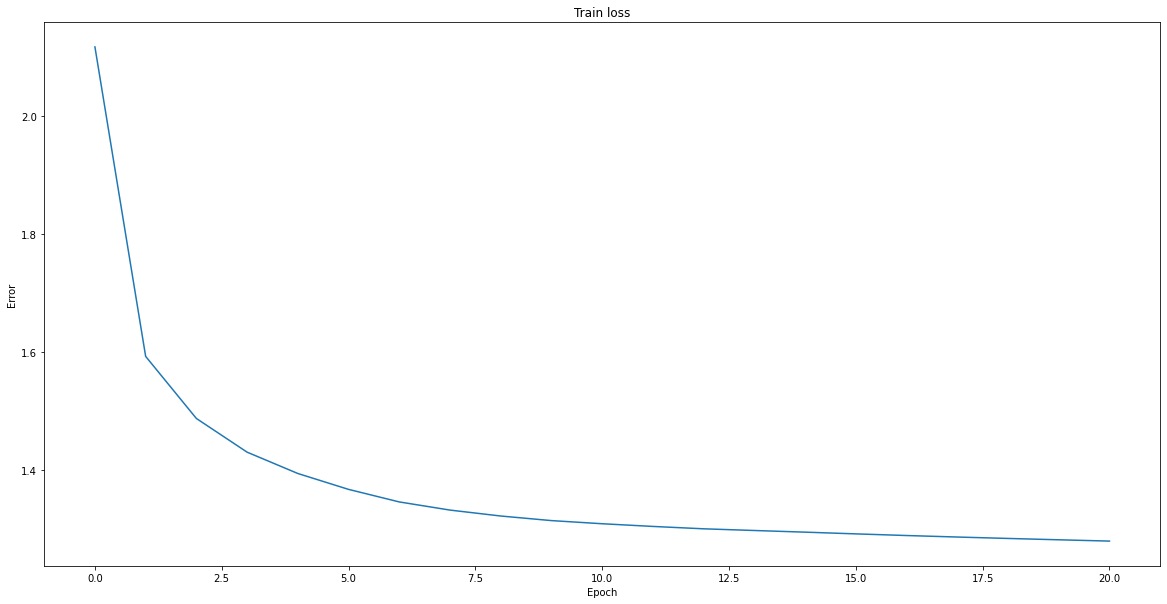

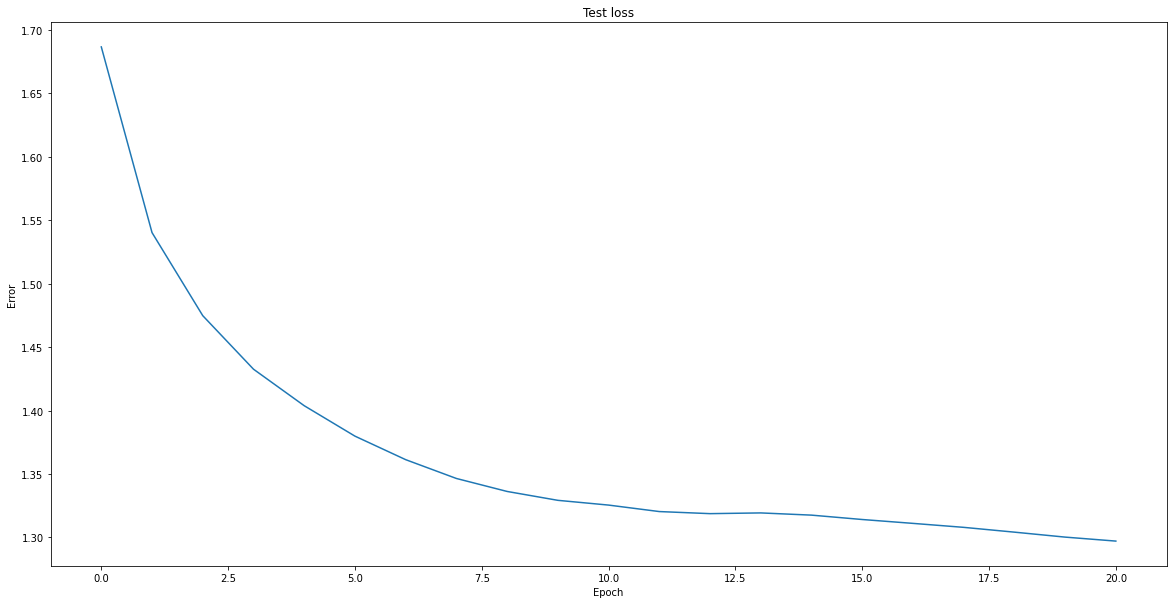

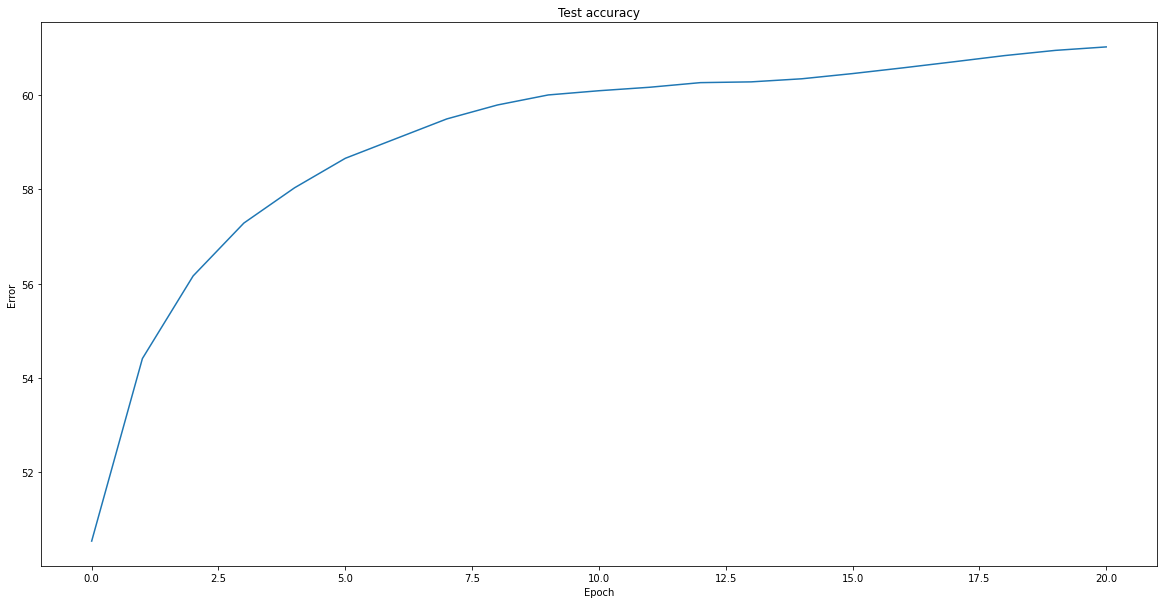

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)
(5.399700596232176, 4.665021004624547, 4.369698542537268, 4.189360490706417, 4.070570754188449, 3.974207331242813, 3.901271911974757, 3.843880182848344, 3.804784080465997, 3.77827677059856, 3.7641645342817225, 3.7450094423330587, 3.7388734839340754, 3.7409984704951595, 3.73449512659666, 3.721656905569794, 3.7103265159172416, 3.6987408954526715, 3.684784799847919, 3.670410300437385, 3.658926673988029)


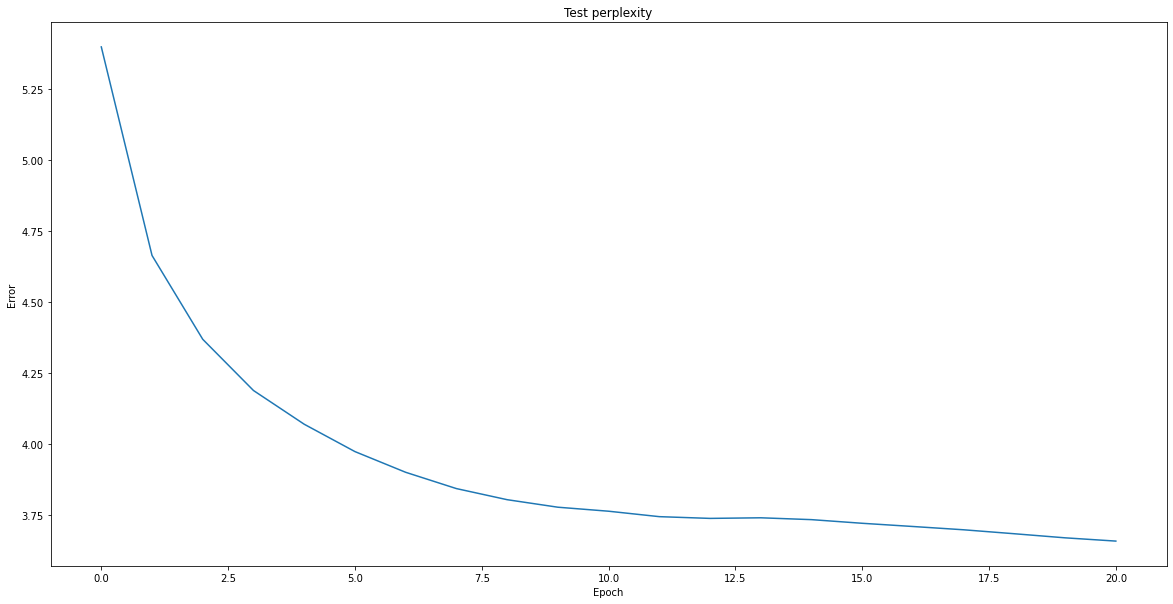

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0003
    USE_CUDA = True
    PRINT_INTERVAL = 10
    VERSION = '5.0'
    LOG_PATH = DATA_PATH + VERSION + '/logs/log.pk' + VERSION


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints/' + VERSION)

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            test_perplexities.append((epoch, math.exp(test_loss)))
            print("perplexity: " + str(test_perplexities))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/' + VERSION + '/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/' + VERSION + '/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')

        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        ep, val = zip(*test_perplexities)
        print(ep)
        print(val)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')

        return model, vocab, device

final_model, vocab, device = main()

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    

    -We decreased learning rate to 0.001 and decreased weight decay to 0.003.

    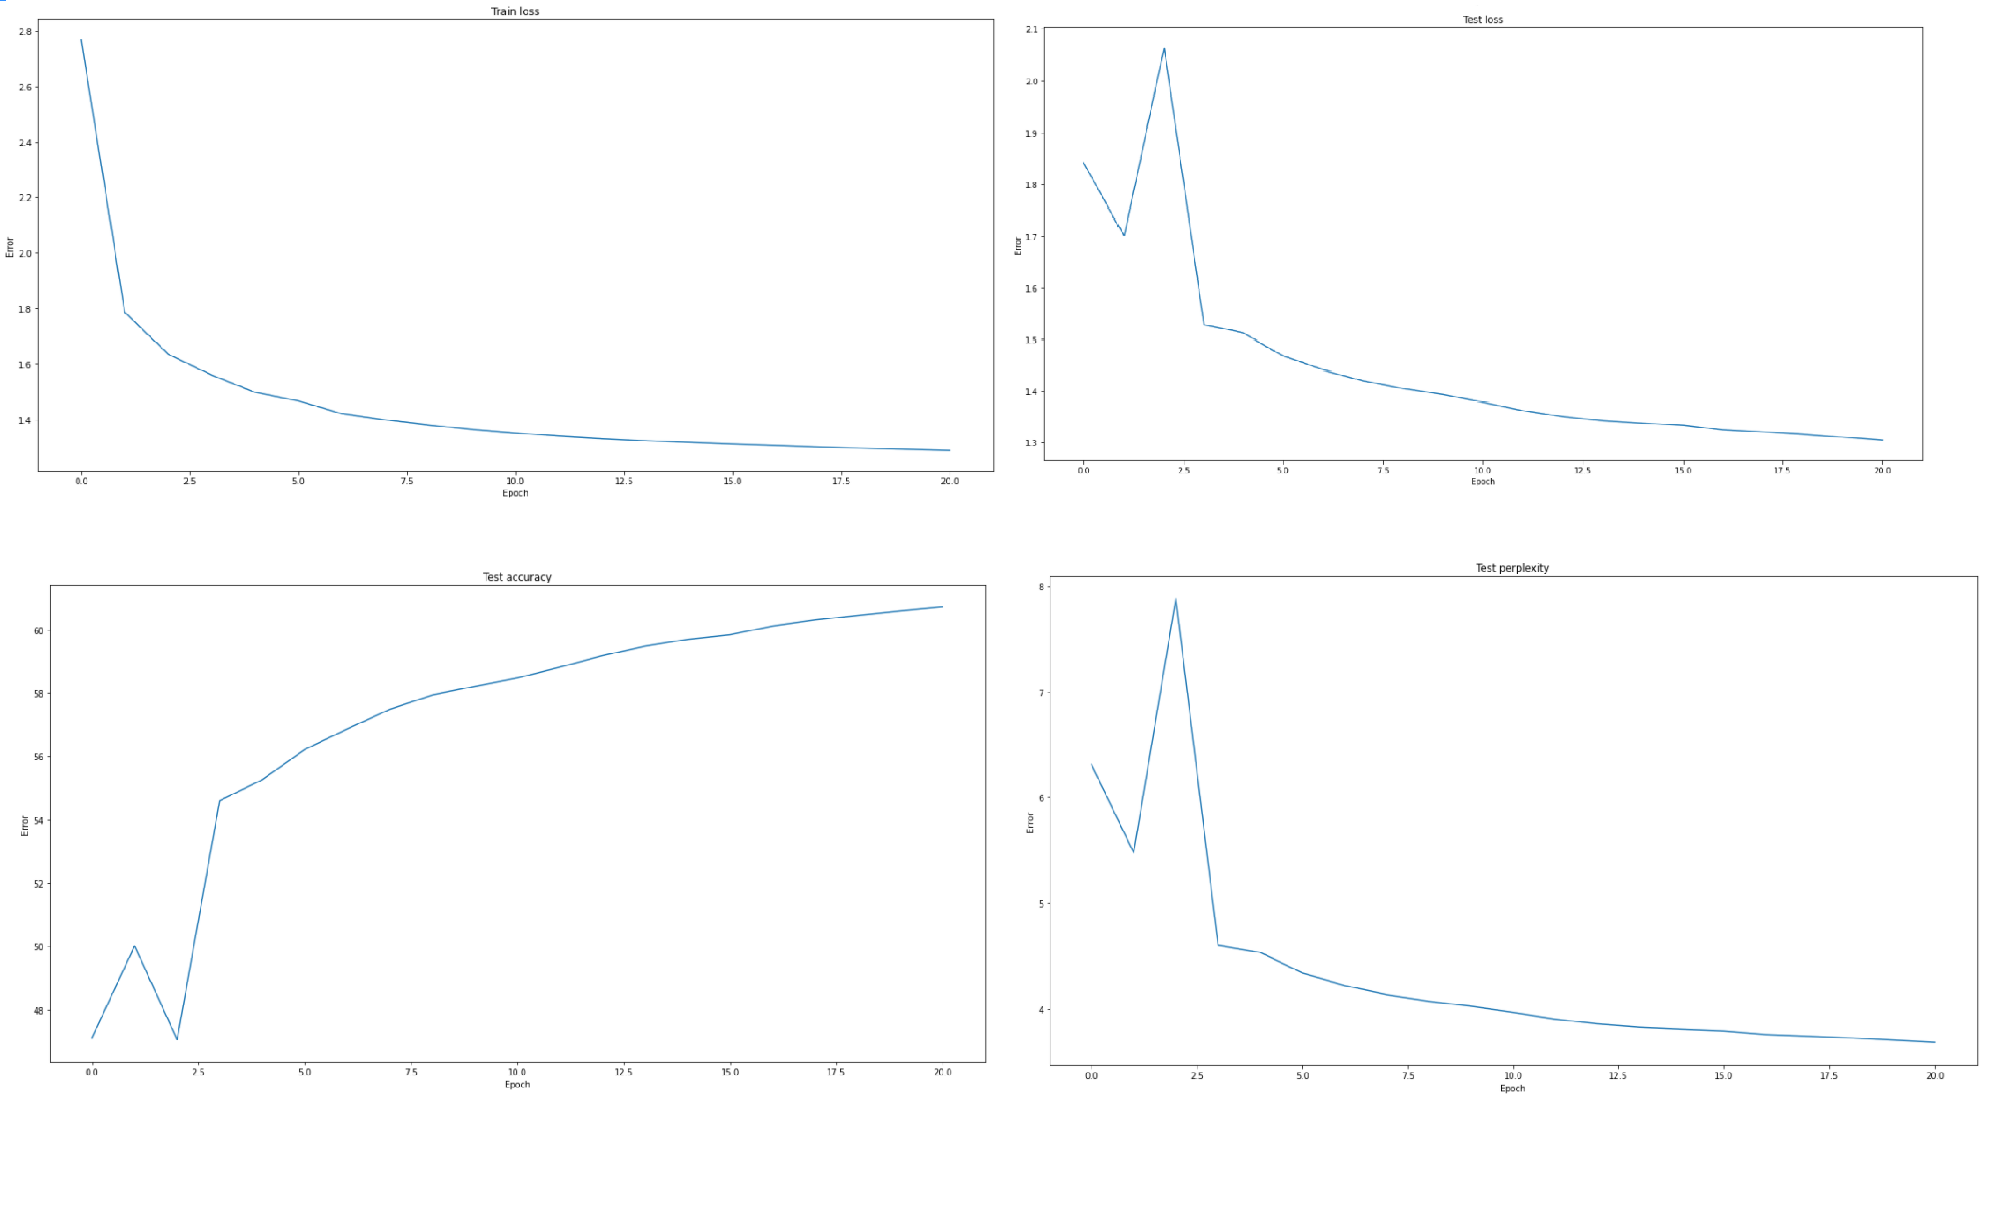
    
2. What was your final test accuracy? What was your final test perplexity?

    - Our final test accuracy was 61%. Our final test perplexity was 3.688.

3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?

    - Our prompt was: "Master has given Dobby a"

    - max: Master has given Dobby a lot of the way of the way of the walls of the walls of the walls of the walls of the walls of the walls of the corner of the walls of the walls of the corner of the walls of the walls of the corner of

    - sample: Master has given Dobby a  protest in the Cho lad world be depning. . . I without way to im."
"You while he can didn't might you Dumbledore," said Harry miged. He was not such of their faces finished, and Sirius he was sitting 
generated with sample	 Master has given Dobby a figthing."
Charl Crouch got to go to chee. He whiched the shoulder, which
earty shining that seemed to her Harry to hour suddenly onthe robes. "One of Todamon cores!" he walked up and started
toward th

    - beam: Master has given Dobby a otk d sikht y  
""ou le s wot  
e mione  "hes was sow ingng tn o the cuittbn  wnd the woor ayd y  "ou wnow "
se said  "n s  moldemort  .  he  wooked aown  and the   wooking ap   se said, "ooking ato


4. Which sampling method seemed to generate the best results? Why do you think that is?

    - Max seems to generate the best results. We think this is the case because our vocabulary is build on characters. Sample is used to generate synonymous sentences, but with characters, this doesn't really make sense because characters do not have definition. Sample still performs alright, but the randomness leads to generation of non-words. Beam uses random sampling to build up sequences and return the most likely one. Because of the random sampling involved, it also generates a lot of non-words. Because characters do not have as much syntactical or grammatical structure as words, Beam search is not a great option here.

5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.

        - sample with temp 1.5: Master has given Dobby a Antive Potions looking us alive decontroter," he said. "I isn't - do what told you things ?"
"Mr.. We org!" he slambed in voice...Y he noticed the plafet with him. He huddering a from why he was sitti

        - beam with temp 1.5: Master has given Dobby a omt  of the wouse"
"he  re sot ced   se sooked airan  aooking ap  
"he  rl be sn ereng  .  
e mione sooked ap ng and thet thet whe  wooked aown tt the cooms. and thet tt s not tn ter ant "    se suie

    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?

        - Temperature of 0 makes the softmax act similar a maxarg, though the code takes temperature of 0 to be 1e-20 to avoid divide by 0 errors. Temperature between 0 and 1 makes the softmax biased towards the maximum. A temperature of 1 is just regular softmax. A temperature of greater than 1 biases the softmax towards a uniform distribution. A negative temperature would result in the softmax being an inverse of the softmax with the positive temperature, so we wouldn't get a probability distribution, so it doesn't make sense to use negative temperature.
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    
      - The corpus that we chose was the complete works of Mark Twain, which we got from Project Gutenberg. It has 16013958 characters, about 10,000,000 more than the Harry Potter corpus.

    2. What differences did you notice between the sentences generated with the new/vs old corpus.

      - The new corpus and old corpus include different people because the characters in each story are different. We see names like Voldemort and Dobby in the old corpus and words like Tom and McClintock. Similarly the types of words that we see are more old fashioned in Twain's corpus.

    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

      - Temperature = 1.5
      
      - beam: Tom said to himself that it was not such a hollow world, after all. Ihe
weuld
hot ce  tt tante   hes ws tote on eed  ah , aut thet s thet  aow,-hat
ou  el  t ll de ahet "
het s the e s aou  piiter  sae psngs   
"       . .................    s aost  aotst  and

      - sample: Tom said to himself that it was not such a hollow world, after all. )at, a
couple of
the authoritis putched to us cave by next moders know.  Gny
what four thoug thirsts twelve expense, and--appeals --
"I ass.  Ohen the column in me a clush of the King-in conditions to

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    
    We have added an additional linear layer before the GRU with a relu activation function, making the model deeper. This decreased the perplexity, while the accuracy was similar. We also tried adding two linear layers (instead of 1) before and after GRU, due to which the accuracy fell down to 49 percent. This might be because the model was overfitting due to the large number of connections between neurons.

    2. What was your lowest test perplexity? Provide training and testing plots.

    The lowest text perplexity obtained was 3.61, which is lower than the perplexity for our original model. This suggests that this model has better performance. The plots obtained are:
    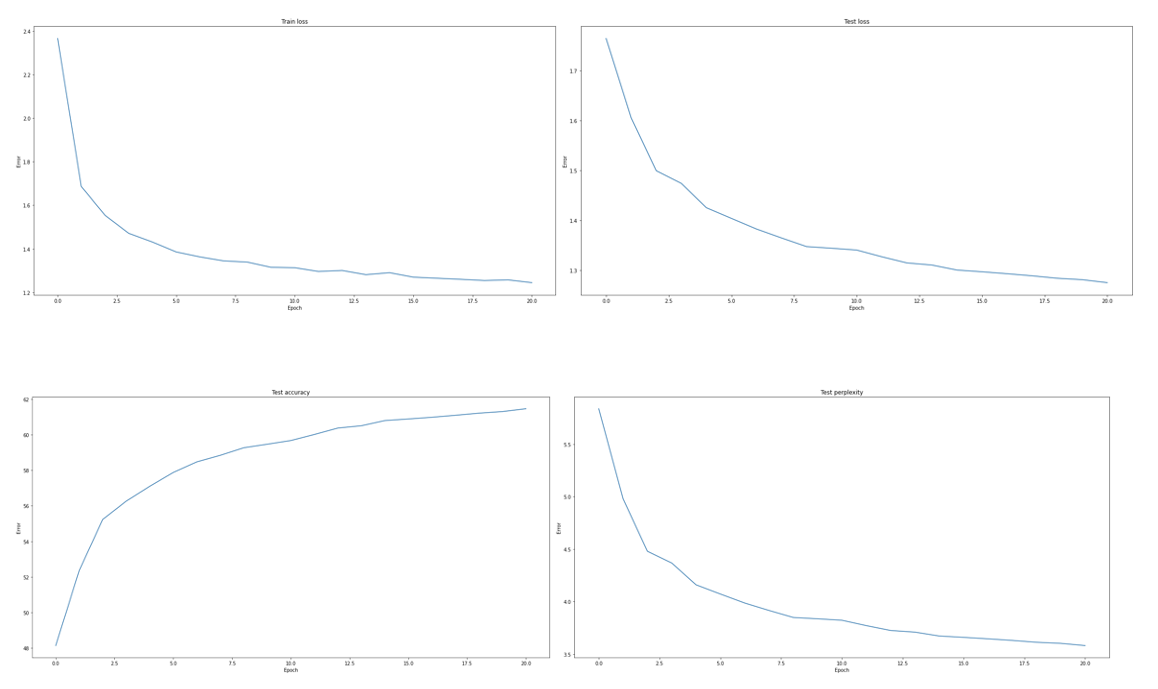

    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

    Temperature - 1.5

    The outputs produced are:

    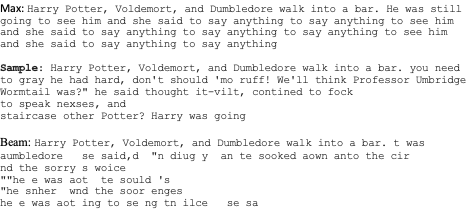

1. LSTM
    1. What new difficulties did you run into while training?

  LSTM produces a tuple, so got some errors because of it. We found that tweaking hyperparameters did not seem to squeeze out additional performance. Also, the LSTM seemed to take longer to train, perhaps because it is a more complicated model.

    2. Were results better than the GRU? Provide training and testing plots.

    The accuracy obtained was 61 percentr which is similar to the GRU. We think the performance is similar because the LSTM is generally used for data that has some sort of long term relationship with previous members in a sequence. Characters in one word most likely do not affect characters in another word very much, so the LSTM may have been discarding these long term memory information, making it work very similar to a GRU.
    
     The plots obtained are:
    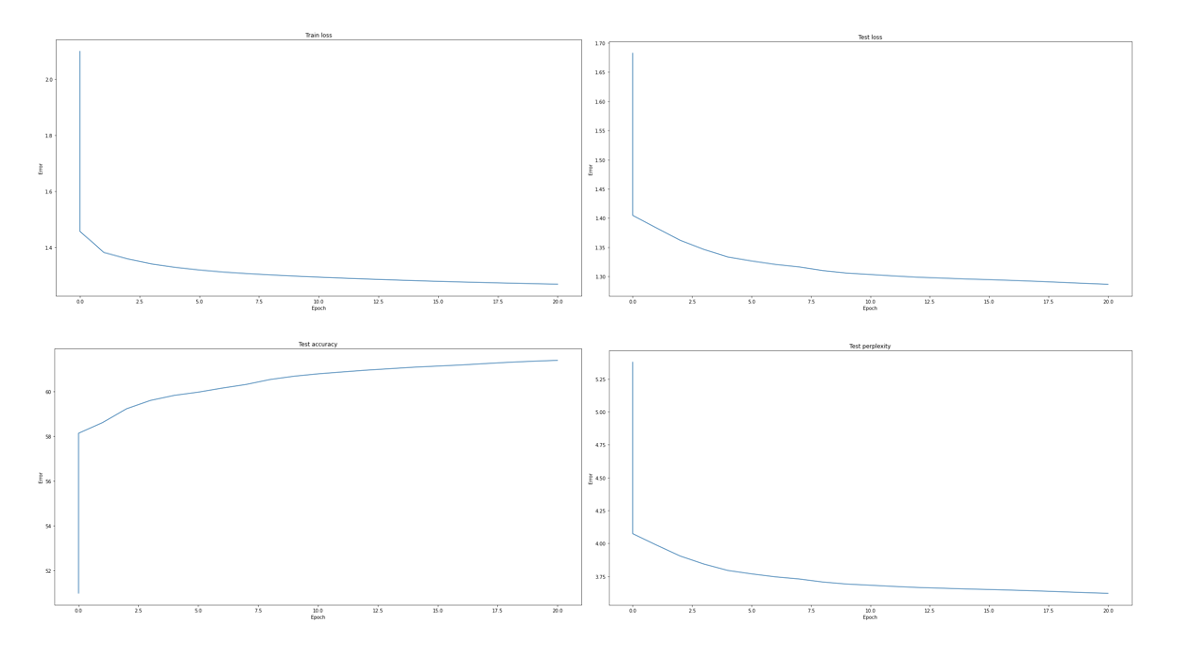 

    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

    Temperature - 1.5

    The output produced are:
    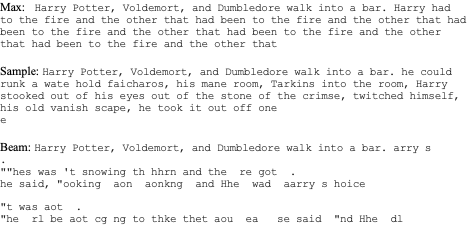

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    